# **# Install Libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
 !pip install -q tqdm

In [ ]:
!pip install -q segmentation-models-pytorch

In [3]:
pip install -q requests beautifulsoup4 tqdm

In [4]:
pip install -q opencv-python-headless

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:

pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.1 MB/s eta 0:00:00


In [7]:
import os
import re
import json
import glob
import shutil
import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import requests
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp
from ultralytics import YOLO

from shapely.geometry import Polygon
from scipy.ndimage import zoom
from scipy.spatial.distance import cdist
from numpy.polynomial.polynomial import polyvander2d, polyval2d

from skimage.filters import threshold_otsu
from skimage.morphology import binary_opening, rectangle, remove_small_objects
from skimage.measure import label, regionprops


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **# Download GONG data**

In [ ]:

# Path to the annotations JSON file
annotations_path =  "/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json"

# Load the annotations file
with open(annotations_path, "r") as f:
    coco_annotations = json.load(f)

# Extract the image_ids (i.e., the 'id' from the 'images' list)
image_ids = [image["id"] for image in coco_annotations["images"]]

# Count how many times each image_id occurs (i.e., how many times each image is listed)
image_counts = Counter(image_ids)

# Now you have a count of images and their frequency in the list (even if they appear multiple times)
print(f"Total number of unique image_ids: {len(image_counts)}")
print(f"Total number of images: {sum(image_counts.values())}")


Total number of unique image_ids: 1593
Total number of images: 1593


In [ ]:

# === Paths ===
annotations_path = "/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json"
download_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-jpgs"

# === Load annotation file
with open(annotations_path, "r") as f:
    coco = json.load(f)

# === Get annotated image_ids
annotated_ids = {str(ann["image_id"]) for ann in coco["annotations"]}

# === Group: file_name → list of matching image_ids
file_to_ids = {}
file_lookup = {}

for img in coco["images"]:
    img_id = str(img["id"])
    file_name = img["file_name"].replace(".jpeg", ".jpg")
    if img_id in annotated_ids:
        file_to_ids.setdefault(file_name, []).append(img_id)
        file_lookup[file_name] = img["file_name"]

print(f"Found {len(file_to_ids)} unique image filenames with annotations.")

# === Utilities
def extract_date(filename):
    match = re.search(r"(20\d{2})(\d{2})(\d{2})", filename)
    return match.groups() if match else (None, None, None)

def download_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total = int(response.headers.get("content-length", 0))
            with open(save_path, "wb") as f, tqdm(
                total=total, unit="B", unit_scale=True, desc=os.path.basename(save_path), leave=False
            ) as bar:
                for chunk in response.iter_content(8192):
                    f.write(chunk)
                    bar.update(len(chunk))
            return True
        else:
            print(f"Failed to download (status {response.status_code}): {url}")
            return False
    except Exception as e:
        print(f"Error: {e}")
        return False

# === Download and save for each file_name
print("\nDownloading annotated images...\n")
total_saved = 0

for file_name, id_list in file_to_ids.items():
    year, month, day = extract_date(file_name)
    if not year:
        print(f"Skipping {file_name} — invalid date")
        continue

    url = f"https://gong2.nso.edu/HA/hag/{year}{month}/{year}{month}{day}/{file_name}"
    temp_path = os.path.join(download_dir, "temp.jpg")

    # Download once
    if not download_image(url, temp_path):
        continue

    # Save under each image ID
    for img_id in id_list:
        save_dir = os.path.join(download_dir, year, month, day)
        os.makedirs(save_dir, exist_ok=True)
        final_path = os.path.join(save_dir, f"{img_id}.jpg")

        with open(temp_path, "rb") as src, open(final_path, "wb") as dst:
            dst.write(src.read())
        total_saved += 1

    os.remove(temp_path)

print(f"\nDownload complete. Total annotated JPGs saved: {total_saved}")


Found 887 unique image filenames with annotations.





Download complete. Total annotated JPGs saved: 1439


In [ ]:

# === Configuration ===
image_path = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-jpgs/2011/01/14/010101-20110114105034Ch.jpg"

# === Load and analyze image ===
if os.path.exists(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        resolution = width * height

        # Convert to grayscale if not already
        img_gray = img.convert("L")
        pixel_array = np.array(img_gray)

        intensity_min = pixel_array.min()
        intensity_max = pixel_array.max()

        print(f"Image: {os.path.basename(image_path)}")
        print(f"Width            : {width} pixels")
        print(f"Height           : {height} pixels")
        print(f"Resolution       : {resolution:,} total pixels")
        print(f"Intensity range  : {intensity_min} to {intensity_max}")

        # Optional: Detect if it's 8-bit
        if intensity_max <= 255:
            print("Bit depth        : 8-bit (0–255 grayscale)")
        elif intensity_max <= 65535:
            print("Bit depth        : 16-bit (0–65535 grayscale)")
        else:
            print("Bit depth        : Higher than 16-bit")
else:
    print(f"File not found: {image_path}")


Image: 010101-20110114105034Ch.jpg
Width            : 2048 pixels
Height           : 2048 pixels
Resolution       : 4,194,304 total pixels
Intensity range  : 0 to 255
Bit depth        : 8-bit (0–255 grayscale)


image dimension: width = 2048, height: 2048


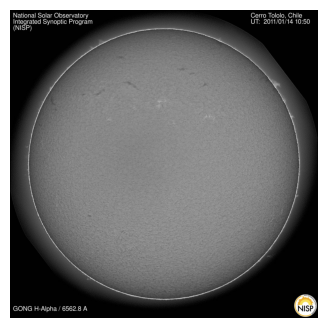

In [ ]:


image_path = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-jpgs/2011/01/14/010101-20110114105034Ch.jpg"

image = Image.open(image_path)
width, height = image.size  # Returns (width, height)
print(f"image dimension: width = {width}, height: {height}")
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()


# **preprocess jpgs**

In [ ]:


# ------------------- Core Preprocessing Functions -------------------

def find_solar_disk(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=50, param2=30, minRadius=100, maxRadius=image.shape[0] // 2)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        return (x, y, r)
    h, w = image.shape
    return (w // 2, h // 2, min(h, w) // 2 - 10)

def subtract_polynomial_background(image, mask, downscale=2, order=4):
    img = image * mask
    small = zoom(img, 1.0 / downscale, order=1)
    small_mask = zoom(mask.astype(float), 1.0 / downscale, order=0)
    ny, nx = small.shape
    xg, yg = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, ny))
    rr = np.sqrt(xg**2 + yg**2)
    radial_mask = rr <= 0.85
    intensity_thresh = np.percentile(small[small_mask > 0], 85)
    fit_mask = (small < intensity_thresh) & (small_mask > 0) & radial_mask
    x_flat = xg[fit_mask]
    y_flat = yg[fit_mask]
    z_flat = small[fit_mask]
    V = polyvander2d(x_flat, y_flat, [order, order])
    coeffs, *_ = np.linalg.lstsq(V, z_flat, rcond=None)
    fitted_small = polyval2d(xg, yg, coeffs.reshape((order + 1, order + 1)))
    fitted_full = zoom(fitted_small, downscale, order=1)
    if fitted_full.shape != image.shape:
        fitted_full = fitted_full[:image.shape[0], :image.shape[1]]
    flat = image - fitted_full
    flat = np.where(mask, flat, image)
    disk_vals = flat[mask]
    disk_norm = (disk_vals - np.min(disk_vals)) / (np.max(disk_vals) - np.min(disk_vals))
    flat[mask] = disk_norm
    return flat

def radial_flatten(image, mask, center, radius):
    y, x = np.indices(image.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2) / radius
    r_masked = r[mask]
    img_masked = image[mask]
    r_bins = np.linspace(0, 1, 100)
    means = []
    for i in range(len(r_bins) - 1):
        ring = (r_masked >= r_bins[i]) & (r_masked < r_bins[i + 1])
        if np.sum(ring) > 10:
            means.append(np.mean(img_masked[ring]))
        else:
            means.append(means[-1] if means else 1.0)
    radial_profile = np.interp(r.flatten(), r_bins[:-1], means).reshape(image.shape)
    flattened = image.copy()
    flattened[mask] = image[mask] / (radial_profile[mask] + 1e-6)
    flattened = np.clip(flattened, 0, np.percentile(flattened[mask], 99))
    flattened[mask] = (flattened[mask] - np.min(flattened[mask])) / (np.max(flattened[mask]) - np.min(flattened[mask]))
    return flattened

def enhance_filaments_strict(image, disk_mask, min_area=300, min_ecc=0.6, contrast_cut=0.1):
    h, w = image.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    central_mask = r < 0.9 * r[disk_mask].max()
    inner_disk = disk_mask & central_mask

    disk_vals = image[inner_disk]
    thresh = threshold_otsu(disk_vals)
    dark_regions = (image < thresh - contrast_cut) & inner_disk

    filtered = np.zeros_like(dark_regions, dtype=bool)
    for se in [rectangle(1, 15), rectangle(15, 1), rectangle(3, 9), rectangle(9, 3)]:
        opened = binary_opening(dark_regions, se)
        filtered |= opened

    labeled = label(filtered)
    mask = np.zeros_like(filtered, dtype=bool)
    for region in regionprops(labeled):
        if region.area > min_area and region.eccentricity > min_ecc:
            mask[labeled == region.label] = True

    mask = remove_small_objects(mask, min_size=min_area)
    return mask

# ------------------- Image Processing -------------------

def process_image(input_path, output_path):
    if os.path.exists(output_path):
        print(f"[SKIP] Already exists: {output_path}")
        return

    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"[ERROR] Could not load: {input_path}")
        return

    try:
        image_norm = image.astype(np.float32) / 255.0
        cx, cy, radius = find_solar_disk(image)
        h, w = image.shape
        Y, X = np.ogrid[:h, :w]
        disk_mask = (X - cx) ** 2 + (Y - cy) ** 2 <= radius ** 2

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_input = (image_norm * 255).astype(np.uint8)
        clahe_applied = clahe.apply(clahe_input)
        clahe_result = image_norm.copy()
        clahe_result[disk_mask] = clahe_applied[disk_mask] / 255.0

        bg_subtracted = subtract_polynomial_background(clahe_result, disk_mask)
        final_image = radial_flatten(bg_subtracted, disk_mask, (cx, cy), radius)
        final_image[~disk_mask] = 0

        filament_mask = enhance_filaments_strict(final_image, disk_mask)
        final_image[filament_mask] *= 0.5

        final_uint8 = (final_image * 255).astype(np.uint8)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, final_uint8)
        print(f"[SAVED] {output_path}")
    except Exception as e:
        print(f"[FAIL] {input_path} => {e}")

def process_directory(input_root, output_root):
    image_tasks = []

    for root, _, files in os.walk(input_root):
        for file in sorted(files):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_root)
                output_path = os.path.join(output_root, relative_path)
                image_tasks.append((input_path, output_path))

    print(f"\n[INFO] Found {len(image_tasks)} image(s) to evaluate.")

    for input_path, output_path in tqdm(image_tasks, desc="Processing images"):
        process_image(input_path, output_path)

# ------------------- Main Execution -------------------

input_root = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-jpgs"
output_root = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"

process_directory(input_root, output_root)



[INFO] Found 1439 image(s) to evaluate.


Processing images:   0%|          | 1/1439 [00:05<2:12:13,  5.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/07/010101-20210607142350Bh.jpg


Processing images:   0%|          | 2/1439 [00:09<1:55:45,  4.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/07/010102-20210607142350Bh.jpg


Processing images:   0%|          | 3/1439 [00:14<1:50:42,  4.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/07/010103-20210607142350Bh.jpg


Processing images:   0%|          | 4/1439 [00:18<1:45:19,  4.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/24/010302-20210624133950Bh.jpg


Processing images:   0%|          | 5/1439 [00:21<1:37:27,  4.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/24/010303-20210624133950Bh.jpg


Processing images:   0%|          | 6/1439 [00:25<1:36:53,  4.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/26/010403-20210626060050Uh.jpg


Processing images:   0%|          | 7/1439 [00:30<1:40:36,  4.22s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/26/040301-20210626133950Bh.jpg


Processing images:   1%|          | 8/1439 [00:34<1:41:36,  4.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/26/040303-20210626133950Bh.jpg


Processing images:   1%|          | 9/1439 [00:39<1:45:12,  4.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/21/010203-20210621133650Bh.jpg


Processing images:   1%|          | 10/1439 [00:58<3:35:14,  9.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/27/030101-20210627163630Mh.jpg


Processing images:   1%|          | 11/1439 [01:04<3:07:46,  7.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/16/040401-20210616142650Bh.jpg


Processing images:   1%|          | 12/1439 [01:08<2:44:26,  6.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/16/040402-20210616142650Bh.jpg


Processing images:   1%|          | 13/1439 [01:25<3:53:47,  9.84s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/06/20/040201-20210620163530Mh.jpg


Processing images:   1%|          | 14/1439 [01:42<4:47:38, 12.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/08/010101-20210708060030Lh.jpg


Processing images:   1%|          | 15/1439 [01:58<5:14:29, 13.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/08/010102-20210708060030Lh.jpg


Processing images:   1%|          | 16/1439 [02:15<5:38:25, 14.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/08/010103-20210708060030Lh.jpg


Processing images:   1%|          | 17/1439 [02:18<4:16:26, 10.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/26/010401-20210726041650Uh.jpg


Processing images:   1%|▏         | 18/1439 [02:22<3:28:05,  8.79s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/26/010402-20210726041650Uh.jpg


Processing images:   1%|▏         | 19/1439 [02:24<2:44:55,  6.97s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/26/010403-20210726041650Uh.jpg


Processing images:   1%|▏         | 20/1439 [03:05<6:46:32, 17.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/01/010101-20210701163730Mh.jpg


Processing images:   1%|▏         | 21/1439 [03:46<9:30:35, 24.14s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/01/010102-20210701163730Mh.jpg


Processing images:   2%|▏         | 22/1439 [04:28<11:35:30, 29.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/01/010103-20210701163730Mh.jpg


Processing images:   2%|▏         | 23/1439 [04:31<8:27:55, 21.52s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/28/040201-20210728164530Mh.jpg


Processing images:   2%|▏         | 24/1439 [05:05<9:58:28, 25.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/31/040102-20210731074710Th.jpg


Processing images:   2%|▏         | 25/1439 [05:16<8:16:00, 21.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/30/050201-20210730044930Lh.jpg


Processing images:   2%|▏         | 26/1439 [05:47<9:23:10, 23.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/07/21/060102-20210721123430Ch.jpg


Processing images:   2%|▏         | 27/1439 [05:58<7:57:23, 20.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/23/010401-20210223222830Ch.jpg


Processing images:   2%|▏         | 28/1439 [06:10<6:57:15, 17.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/23/010402-20210223222830Ch.jpg


Processing images:   2%|▏         | 29/1439 [06:22<6:17:59, 16.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/23/010403-20210223222830Ch.jpg


Processing images:   2%|▏         | 30/1439 [06:27<4:56:18, 12.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/01/010201-20210201020330Lh.jpg


Processing images:   2%|▏         | 31/1439 [06:30<3:49:16,  9.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/01/010202-20210201020330Lh.jpg


Processing images:   2%|▏         | 32/1439 [06:34<3:07:17,  7.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/01/010203-20210201020330Lh.jpg


Processing images:   2%|▏         | 33/1439 [06:39<2:46:15,  7.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/22/010101-20210222222850Bh.jpg


Processing images:   2%|▏         | 34/1439 [06:43<2:23:36,  6.13s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/22/010103-20210222222850Bh.jpg


Processing images:   2%|▏         | 35/1439 [07:36<7:53:26, 20.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/02/19/040301-20210219230330Lh.jpg


Processing images:   3%|▎         | 36/1439 [07:41<6:04:09, 15.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/25/010201-20211225025850Uh.jpg


Processing images:   3%|▎         | 37/1439 [07:44<4:37:01, 11.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/25/010202-20211225025850Uh.jpg


Processing images:   3%|▎         | 38/1439 [07:48<3:43:02,  9.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/25/010203-20211225025850Uh.jpg


Processing images:   3%|▎         | 39/1439 [07:56<3:34:11,  9.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/29/010203-20211229120210Th.jpg


Processing images:   3%|▎         | 40/1439 [08:58<9:40:06, 24.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/29/040102-20211229120130Ch.jpg


Processing images:   3%|▎         | 41/1439 [09:02<7:16:34, 18.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/31/010401-20211231180850Bh.jpg


Processing images:   3%|▎         | 42/1439 [09:07<5:37:12, 14.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/31/010402-20211231180850Bh.jpg


Processing images:   3%|▎         | 43/1439 [09:11<4:23:24, 11.32s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/31/010403-20211231180850Bh.jpg


Processing images:   3%|▎         | 44/1439 [09:44<6:54:04, 17.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/31/030401-20211231223430Lh.jpg


Processing images:   3%|▎         | 45/1439 [10:15<8:31:28, 22.01s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/31/030403-20211231223430Lh.jpg


Processing images:   3%|▎         | 46/1439 [10:20<6:29:14, 16.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/14/030101-20211214174010Mh.jpg


Processing images:   3%|▎         | 47/1439 [11:15<10:58:01, 28.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/24/040401-20211224120130Ch.jpg


Processing images:   3%|▎         | 48/1439 [12:07<13:36:50, 35.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/12/22/060403-20211222120130Ch.jpg


Processing images:   3%|▎         | 49/1439 [12:10<9:56:13, 25.74s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/17/010401-20210817165030Mh.jpg


Processing images:   3%|▎         | 50/1439 [12:14<7:21:36, 19.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/17/010402-20210817165030Mh.jpg


Processing images:   4%|▎         | 51/1439 [12:18<5:35:05, 14.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/17/010403-20210817165030Mh.jpg


Processing images:   4%|▎         | 52/1439 [12:23<4:33:35, 11.84s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/12/020101-20210812044930Lh.jpg


Processing images:   4%|▎         | 53/1439 [12:55<6:48:54, 17.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/11/020101-20210811072510Th.jpg


Processing images:   4%|▍         | 54/1439 [13:25<8:18:11, 21.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/11/020103-20210811072510Th.jpg


Processing images:   4%|▍         | 55/1439 [13:30<6:23:21, 16.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/15/030101-20210815140550Bh.jpg


Processing images:   4%|▍         | 56/1439 [13:36<5:04:40, 13.22s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/10/030403-20210810121630Ch.jpg


Processing images:   4%|▍         | 57/1439 [13:41<4:14:14, 11.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/08/14/040201-20210814044930Lh.jpg


Processing images:   4%|▍         | 58/1439 [13:46<3:29:22,  9.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/10/16/010101-20211016145050Bh.jpg


Processing images:   4%|▍         | 59/1439 [13:52<3:04:44,  8.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/11/19/020401-20211119005210Mh.jpg


Processing images:   4%|▍         | 60/1439 [13:56<2:38:36,  6.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/11/19/020403-20211119005210Mh.jpg


Processing images:   4%|▍         | 61/1439 [14:29<5:38:31, 14.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/11/19/040401-20211119103130Ch.jpg


Processing images:   4%|▍         | 62/1439 [15:32<11:12:26, 29.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/01/03/030101-20210103223630Lh.jpg


Processing images:   4%|▍         | 63/1439 [15:37<8:23:00, 21.93s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/01/01/040401-20210101202450Bh.jpg


Processing images:   4%|▍         | 64/1439 [16:24<11:12:41, 29.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/01/27/060102-20210127110130Ch.jpg


Processing images:   5%|▍         | 65/1439 [16:40<9:40:54, 25.37s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/03/31/040301-20210331231510Mh.jpg


Processing images:   5%|▍         | 66/1439 [16:57<8:44:46, 22.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/03/31/040302-20210331231510Mh.jpg


Processing images:   5%|▍         | 67/1439 [17:02<6:39:05, 17.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/03/29/040302-20210329015250Uh.jpg


Processing images:   5%|▍         | 68/1439 [17:30<7:51:15, 20.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2021/03/29/060102-20210329114430Ch.jpg


Processing images:   5%|▍         | 69/1439 [18:29<12:14:18, 32.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/22/010401-20111222063154Uh.jpg


Processing images:   5%|▍         | 70/1439 [19:28<15:18:30, 40.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/22/010402-20111222063154Uh.jpg


Processing images:   5%|▍         | 71/1439 [20:25<17:13:26, 45.33s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/22/010403-20111222063154Uh.jpg


Processing images:   5%|▌         | 72/1439 [21:06<16:46:39, 44.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/29/010401-20111229063154Uh.jpg


Processing images:   5%|▌         | 73/1439 [21:47<16:22:27, 43.15s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/29/010402-20111229063154Uh.jpg


Processing images:   5%|▌         | 74/1439 [22:30<16:15:45, 42.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/29/010403-20111229063154Uh.jpg


Processing images:   5%|▌         | 75/1439 [22:39<12:28:00, 32.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/15/010401-20111215063134Lh.jpg


Processing images:   5%|▌         | 76/1439 [22:48<9:41:18, 25.59s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/15/010402-20111215063134Lh.jpg


Processing images:   5%|▌         | 77/1439 [22:58<7:55:47, 20.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/15/010403-20111215063134Lh.jpg


Processing images:   5%|▌         | 78/1439 [23:39<10:12:32, 27.00s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/23/010302-20111223085314Th.jpg


Processing images:   5%|▌         | 79/1439 [23:54<8:52:49, 23.51s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/14/030401-20111214132434Ch.jpg


Processing images:   6%|▌         | 80/1439 [24:10<7:56:39, 21.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/14/030403-20111214132434Ch.jpg


Processing images:   6%|▌         | 81/1439 [24:14<6:02:30, 16.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/14/040102-20111214063134Lh.jpg


Processing images:   6%|▌         | 82/1439 [24:18<4:40:20, 12.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/16/040401-20111216174914Mh.jpg


Processing images:   6%|▌         | 83/1439 [24:51<6:57:58, 18.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/16/050101-20111216103234Ch.jpg


Processing images:   6%|▌         | 84/1439 [25:23<8:32:38, 22.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/16/050102-20111216103234Ch.jpg


Processing images:   6%|▌         | 85/1439 [25:55<9:38:11, 25.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/16/050103-20111216103234Ch.jpg


Processing images:   6%|▌         | 86/1439 [26:37<11:28:20, 30.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/01/040301-20111201063154Uh.jpg


Processing images:   6%|▌         | 87/1439 [27:04<10:57:50, 29.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/06/040301-20111206102934Ch.jpg


Processing images:   6%|▌         | 88/1439 [27:20<9:32:49, 25.44s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/08/040301-20111208063134Lh.jpg


Processing images:   6%|▌         | 89/1439 [27:25<7:13:53, 19.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/08/050101-20111208173814Mh.jpg


Processing images:   6%|▋         | 90/1439 [27:31<5:41:37, 15.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/08/050102-20111208173814Mh.jpg


Processing images:   6%|▋         | 91/1439 [27:36<4:34:58, 12.24s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/08/050103-20111208173814Mh.jpg


Processing images:   6%|▋         | 92/1439 [28:04<6:23:04, 17.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/18/050101-20111218085014Th.jpg


Processing images:   6%|▋         | 93/1439 [28:33<7:41:43, 20.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/18/050102-20111218085014Th.jpg


Processing images:   7%|▋         | 94/1439 [29:02<8:33:17, 22.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/18/050103-20111218085014Th.jpg


Processing images:   7%|▋         | 95/1439 [29:06<6:32:20, 17.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/12/26/060403-20111226155454Bh.jpg


Processing images:   7%|▋         | 96/1439 [29:12<5:14:46, 14.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/24/010201-20110724164614Mh.jpg


Processing images:   7%|▋         | 97/1439 [29:28<5:24:51, 14.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/06/020401-20110706164014Mh.jpg


Processing images:   7%|▋         | 98/1439 [29:42<5:23:04, 14.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/06/020403-20110706164014Mh.jpg


Processing images:   7%|▋         | 99/1439 [29:57<5:26:26, 14.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/07/020401-20110707074514Th.jpg


Processing images:   7%|▋         | 100/1439 [30:12<5:26:47, 14.64s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/07/020403-20110707074514Th.jpg


Processing images:   7%|▋         | 101/1439 [30:42<7:07:18, 19.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/11/040301-20110711071214Th.jpg


Processing images:   7%|▋         | 102/1439 [31:10<8:09:24, 21.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/11/040302-20110711071214Th.jpg


Processing images:   7%|▋         | 103/1439 [31:25<7:19:48, 19.75s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/28/040401-20110728084714Th.jpg


Processing images:   7%|▋         | 104/1439 [31:30<5:39:33, 15.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/27/050101-20110727063234Lh.jpg


Processing images:   7%|▋         | 105/1439 [31:33<4:22:44, 11.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/27/050102-20110727063234Lh.jpg


Processing images:   7%|▋         | 106/1439 [31:38<3:37:11,  9.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/07/27/050103-20110727063234Lh.jpg


Processing images:   7%|▋         | 107/1439 [31:55<4:24:04, 11.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/22/010401-20111122063134Lh.jpg


Processing images:   8%|▊         | 108/1439 [32:12<4:52:58, 13.21s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/22/010402-20111122063134Lh.jpg


Processing images:   8%|▊         | 109/1439 [32:27<5:07:09, 13.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/22/010403-20111122063134Lh.jpg


Processing images:   8%|▊         | 110/1439 [32:32<4:06:09, 11.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/24/020401-20111124153054Bh.jpg


Processing images:   8%|▊         | 111/1439 [32:36<3:18:48,  8.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/24/020403-20111124153054Bh.jpg


Processing images:   8%|▊         | 112/1439 [32:44<3:16:52,  8.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/12/020401-20111112193254Bh.jpg


Processing images:   8%|▊         | 113/1439 [32:54<3:19:42,  9.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/12/020403-20111112193254Bh.jpg


Processing images:   8%|▊         | 114/1439 [33:23<5:35:28, 15.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/15/030403-20111115063134Lh.jpg


Processing images:   8%|▊         | 115/1439 [33:44<6:13:53, 16.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/07/030302-20111107063154Uh.jpg


Processing images:   8%|▊         | 116/1439 [34:18<8:05:14, 22.01s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/14/040401-20111114063134Lh.jpg


Processing images:   8%|▊         | 117/1439 [34:23<6:14:35, 17.00s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/14/050101-20111114082314Th.jpg


Processing images:   8%|▊         | 118/1439 [34:30<5:05:08, 13.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/14/050102-20111114082314Th.jpg


Processing images:   8%|▊         | 119/1439 [34:36<4:15:34, 11.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/14/050103-20111114082314Th.jpg


Processing images:   8%|▊         | 120/1439 [34:42<3:36:48,  9.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/28/040401-20111128175514Mh.jpg


Processing images:   8%|▊         | 121/1439 [34:53<3:41:51, 10.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/16/050101-20111116063134Lh.jpg


Processing images:   8%|▊         | 122/1439 [35:04<3:49:35, 10.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/16/050102-20111116063134Lh.jpg


Processing images:   9%|▊         | 123/1439 [35:15<3:53:24, 10.64s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/11/16/050103-20111116063134Lh.jpg


Processing images:   9%|▊         | 124/1439 [35:29<4:16:19, 11.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/03/010101-20110203082634Lh.jpg


Processing images:   9%|▊         | 125/1439 [35:44<4:33:16, 12.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/03/010102-20110203082634Lh.jpg


Processing images:   9%|▉         | 126/1439 [35:56<4:35:01, 12.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/03/010103-20110203082634Lh.jpg


Processing images:   9%|▉         | 127/1439 [36:01<3:41:08, 10.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/15/010401-20110215083814Th.jpg


Processing images:   9%|▉         | 128/1439 [36:06<3:07:20,  8.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/15/010402-20110215083814Th.jpg


Processing images:   9%|▉         | 129/1439 [36:10<2:37:11,  7.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/15/010403-20110215083814Th.jpg


Processing images:   9%|▉         | 130/1439 [36:31<4:07:37, 11.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/20/010101-20110220082634Lh.jpg


Processing images:   9%|▉         | 131/1439 [36:52<5:14:12, 14.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/20/010102-20110220082634Lh.jpg


Processing images:   9%|▉         | 132/1439 [36:56<4:04:02, 11.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/13/010301-20110213093414Th.jpg


Processing images:   9%|▉         | 133/1439 [37:01<3:22:04,  9.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/13/010302-20110213093414Th.jpg


Processing images:   9%|▉         | 134/1439 [37:08<3:09:27,  8.71s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/05/020401-20110205082634Lh.jpg


Processing images:   9%|▉         | 135/1439 [37:16<3:03:58,  8.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/05/020403-20110205082634Lh.jpg


Processing images:   9%|▉         | 136/1439 [37:20<2:35:53,  7.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/14/030403-20110214175414Mh.jpg


Processing images:  10%|▉         | 137/1439 [37:24<2:11:59,  6.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/11/050302-20110211084114Th.jpg


Processing images:  10%|▉         | 138/1439 [37:29<2:02:56,  5.67s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/02/21/060403-20110221173814Mh.jpg


Processing images:  10%|▉         | 139/1439 [37:34<2:03:10,  5.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/27/010101-20110327143554Bh.jpg


Processing images:  10%|▉         | 140/1439 [37:39<1:56:13,  5.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/27/010102-20110327143554Bh.jpg


Processing images:  10%|▉         | 141/1439 [38:02<3:50:59, 10.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/06/010401-20110306082634Lh.jpg


Processing images:  10%|▉         | 142/1439 [38:26<5:19:37, 14.79s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/06/010402-20110306082634Lh.jpg


Processing images:  10%|▉         | 143/1439 [38:49<6:11:31, 17.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/06/010403-20110306082634Lh.jpg


Processing images:  10%|█         | 144/1439 [39:01<5:39:04, 15.71s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/01/010401-20110301082654Uh.jpg


Processing images:  10%|█         | 145/1439 [39:13<5:12:39, 14.50s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/01/010402-20110301082654Uh.jpg


Processing images:  10%|█         | 146/1439 [39:25<4:55:12, 13.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/01/010403-20110301082654Uh.jpg


Processing images:  10%|█         | 147/1439 [41:47<18:46:47, 52.33s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/24/020401-20110324082614Th.jpg


Processing images:  10%|█         | 148/1439 [44:12<28:38:40, 79.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/24/020403-20110324082614Th.jpg


Processing images:  10%|█         | 149/1439 [44:31<22:04:47, 61.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/29/020401-20110329082654Uh.jpg


Processing images:  10%|█         | 150/1439 [44:48<17:20:00, 48.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/29/020403-20110329082654Uh.jpg


Processing images:  10%|█         | 151/1439 [44:52<12:34:17, 35.14s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/25/030302-20110325171014Mh.jpg


Processing images:  11%|█         | 152/1439 [44:57<9:17:26, 25.99s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/17/030101-20110317082654Uh.jpg


Processing images:  11%|█         | 153/1439 [45:15<8:24:00, 23.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/12/040401-20110312082634Lh.jpg


Processing images:  11%|█         | 154/1439 [45:20<6:24:24, 17.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/22/050101-20110322005814Mh.jpg


Processing images:  11%|█         | 155/1439 [45:25<5:01:04, 14.07s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/22/050102-20110322005814Mh.jpg


Processing images:  11%|█         | 156/1439 [45:30<4:01:44, 11.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/22/050103-20110322005814Mh.jpg


Processing images:  11%|█         | 157/1439 [45:34<3:16:10,  9.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/13/060403-20110313082654Uh.jpg


Processing images:  11%|█         | 158/1439 [45:38<2:46:43,  7.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/03/26/060102-20110326170914Mh.jpg


Processing images:  11%|█         | 159/1439 [47:20<12:50:07, 36.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/20/010401-20110120105534Ch.jpg


Processing images:  11%|█         | 160/1439 [49:01<19:44:03, 55.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/20/010402-20110120105534Ch.jpg


Processing images:  11%|█         | 161/1439 [50:44<24:41:05, 69.54s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/20/010403-20110120105534Ch.jpg


Processing images:  11%|█▏        | 162/1439 [50:52<18:11:07, 51.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/14/010101-20110114105034Ch.jpg


Processing images:  11%|█▏        | 163/1439 [51:00<13:36:01, 38.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/14/010103-20110114105034Ch.jpg


Processing images:  11%|█▏        | 164/1439 [51:05<10:00:18, 28.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/28/010401-20110128174814Mh.jpg


Processing images:  11%|█▏        | 165/1439 [51:10<7:28:06, 21.10s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/28/010402-20110128174814Mh.jpg


Processing images:  12%|█▏        | 166/1439 [51:14<5:42:51, 16.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/28/010403-20110128174814Mh.jpg


Processing images:  12%|█▏        | 167/1439 [52:07<9:33:08, 27.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/30/020101-20110130110334Ch.jpg


Processing images:  12%|█▏        | 168/1439 [52:11<7:11:05, 20.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/09/030101-20110109104734Ch.jpg


Processing images:  12%|█▏        | 169/1439 [52:23<6:14:15, 17.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/19/040401-20110119082634Lh.jpg


Processing images:  12%|█▏        | 170/1439 [52:26<4:45:18, 13.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/01/23/060403-20110123174914Mh.jpg


Processing images:  12%|█▏        | 171/1439 [52:35<4:12:33, 11.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/23/010401-20110923165814Mh.jpg


Processing images:  12%|█▏        | 172/1439 [52:42<3:42:23, 10.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/23/010402-20110923165814Mh.jpg


Processing images:  12%|█▏        | 173/1439 [52:49<3:18:46,  9.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/23/010403-20110923165814Mh.jpg


Processing images:  12%|█▏        | 174/1439 [53:44<8:05:57, 23.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/23/030101-20110923112234Ch.jpg


Processing images:  12%|█▏        | 175/1439 [53:49<6:15:25, 17.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/12/010101-20110912142254Bh.jpg


Processing images:  12%|█▏        | 176/1439 [53:55<4:57:01, 14.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/12/010102-20110912142254Bh.jpg


Processing images:  12%|█▏        | 177/1439 [54:42<8:26:08, 24.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/18/010101-20110918112834Ch.jpg


Processing images:  12%|█▏        | 178/1439 [55:30<10:57:38, 31.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/18/010102-20110918112834Ch.jpg


Processing images:  12%|█▏        | 179/1439 [55:48<9:30:07, 27.15s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/14/010101-20110914063134Lh.jpg


Processing images:  13%|█▎        | 180/1439 [56:05<8:27:34, 24.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/14/010102-20110914063134Lh.jpg


Processing images:  13%|█▎        | 181/1439 [56:22<7:39:11, 21.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/14/010103-20110914063134Lh.jpg


Processing images:  13%|█▎        | 182/1439 [56:41<7:23:28, 21.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/09/02/030101-20110902073614Th.jpg


Processing images:  13%|█▎        | 183/1439 [57:44<11:43:40, 33.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/09/010401-20111009110234Ch.jpg


Processing images:  13%|█▎        | 184/1439 [58:46<14:45:05, 42.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/09/010402-20111009110234Ch.jpg


Processing images:  13%|█▎        | 185/1439 [59:50<16:59:03, 48.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/09/010403-20111009110234Ch.jpg


Processing images:  13%|█▎        | 186/1439 [59:54<12:14:56, 35.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/11/010401-20111011112054Uh.jpg


Processing images:  13%|█▎        | 187/1439 [1:00:38<13:11:56, 37.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/15/010101-20111015063134Lh.jpg


Processing images:  13%|█▎        | 188/1439 [1:01:22<13:46:21, 39.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/15/010102-20111015063134Lh.jpg


Processing images:  13%|█▎        | 189/1439 [1:02:05<14:11:56, 40.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/15/010103-20111015063134Lh.jpg


Processing images:  13%|█▎        | 190/1439 [1:02:38<13:17:15, 38.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/29/010101-20111029063154Uh.jpg


Processing images:  13%|█▎        | 191/1439 [1:03:10<12:38:59, 36.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/29/010102-20111029063154Uh.jpg


Processing images:  13%|█▎        | 192/1439 [1:03:15<9:21:05, 27.00s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/27/010101-20111027145954Bh.jpg


Processing images:  13%|█▎        | 193/1439 [1:03:18<6:55:07, 19.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/27/010102-20111027145954Bh.jpg


Processing images:  13%|█▎        | 194/1439 [1:03:22<5:14:53, 15.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/27/010103-20111027145954Bh.jpg


Processing images:  14%|█▎        | 195/1439 [1:03:27<4:07:17, 11.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/18/020401-20111018063134Lh.jpg


Processing images:  14%|█▎        | 196/1439 [1:03:31<3:20:46,  9.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/18/020403-20111018063134Lh.jpg


Processing images:  14%|█▎        | 197/1439 [1:03:36<2:49:42,  8.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/17/030403-20111017113714Th.jpg


Processing images:  14%|█▍        | 198/1439 [1:04:06<5:07:02, 14.84s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/19/040201-20111019063154Uh.jpg


Processing images:  14%|█▍        | 199/1439 [1:04:27<5:44:09, 16.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/10/25/040401-20111025080614Th.jpg


Processing images:  14%|█▍        | 200/1439 [1:05:10<8:26:43, 24.54s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/29/010203-20110429120534Ch.jpg


Processing images:  14%|█▍        | 201/1439 [1:05:15<6:22:14, 18.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/29/050101-20110429135554Bh.jpg


Processing images:  14%|█▍        | 202/1439 [1:05:19<4:53:41, 14.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/29/050102-20110429135554Bh.jpg


Processing images:  14%|█▍        | 203/1439 [1:05:22<3:46:54, 11.01s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/29/050103-20110429135554Bh.jpg


Processing images:  14%|█▍        | 204/1439 [1:05:28<3:13:58,  9.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/24/010201-20110424064534Lh.jpg


Processing images:  14%|█▍        | 205/1439 [1:05:33<2:47:51,  8.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/24/010202-20110424064534Lh.jpg


Processing images:  14%|█▍        | 206/1439 [1:05:38<2:25:10,  7.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/10/010401-20110410141654Bh.jpg


Processing images:  14%|█▍        | 207/1439 [1:05:42<2:07:56,  6.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/10/010402-20110410141654Bh.jpg


Processing images:  14%|█▍        | 208/1439 [1:05:46<1:55:53,  5.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/10/010403-20110410141654Bh.jpg


Processing images:  15%|█▍        | 209/1439 [1:05:52<1:56:44,  5.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/06/020101-20110406082634Lh.jpg


Processing images:  15%|█▍        | 210/1439 [1:06:12<3:24:05,  9.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/21/030302-20110421164914Mh.jpg


Processing images:  15%|█▍        | 211/1439 [1:06:18<2:56:21,  8.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/25/050202-20110425063154Uh.jpg


Processing images:  15%|█▍        | 212/1439 [1:09:05<19:13:28, 56.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/04/08/060403-20110408083214Th.jpg


Processing images:  15%|█▍        | 213/1439 [1:09:09<13:50:17, 40.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/19/010101-20110819131834Ch.jpg


Processing images:  15%|█▍        | 214/1439 [1:09:14<10:07:37, 29.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/19/010102-20110819131834Ch.jpg


Processing images:  15%|█▍        | 215/1439 [1:09:38<9:33:37, 28.12s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/27/010101-20110827141254Bh.jpg


Processing images:  15%|█▌        | 216/1439 [1:10:02<9:08:55, 26.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/27/010102-20110827141254Bh.jpg


Processing images:  15%|█▌        | 217/1439 [1:10:27<8:54:21, 26.24s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/27/010103-20110827141254Bh.jpg


Processing images:  15%|█▌        | 218/1439 [1:10:32<6:44:55, 19.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/23/010201-20110823120334Ch.jpg


Processing images:  15%|█▌        | 219/1439 [1:10:37<5:14:12, 15.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/23/010202-20110823120334Ch.jpg


Processing images:  15%|█▌        | 220/1439 [1:10:42<4:11:17, 12.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/23/010203-20110823120334Ch.jpg


Processing images:  15%|█▌        | 221/1439 [1:10:58<4:33:18, 13.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/03/010401-20110803164914Mh.jpg


Processing images:  15%|█▌        | 222/1439 [1:11:13<4:42:46, 13.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/03/010402-20110803164914Mh.jpg


Processing images:  15%|█▌        | 223/1439 [1:11:29<4:52:15, 14.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/03/010403-20110803164914Mh.jpg


Processing images:  16%|█▌        | 224/1439 [1:11:35<4:05:15, 12.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/15/020401-20110815140454Bh.jpg


Processing images:  16%|█▌        | 225/1439 [1:11:42<3:34:10, 10.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/15/020403-20110815140454Bh.jpg


Processing images:  16%|█▌        | 226/1439 [1:11:59<4:09:32, 12.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/11/030302-20110811121534Ch.jpg


Processing images:  16%|█▌        | 227/1439 [1:12:35<6:32:03, 19.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/24/040102-20110824141054Bh.jpg


Processing images:  16%|█▌        | 228/1439 [1:13:22<9:19:55, 27.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/26/050101-20110826074214Th.jpg


Processing images:  16%|█▌        | 229/1439 [1:14:07<11:04:58, 32.97s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/26/050102-20110826074214Th.jpg


Processing images:  16%|█▌        | 230/1439 [1:14:55<12:33:17, 37.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/26/050103-20110826074214Th.jpg


Processing images:  16%|█▌        | 231/1439 [1:15:00<9:16:04, 27.62s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/08/10/050303-20110810063134Lh.jpg


Processing images:  16%|█▌        | 232/1439 [1:15:05<6:58:25, 20.80s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/25/010101-20110625163814Mh.jpg


Processing images:  16%|█▌        | 233/1439 [1:15:09<5:17:39, 15.80s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/16/020401-20110616133454Bh.jpg


Processing images:  16%|█▋        | 234/1439 [1:15:14<4:12:07, 12.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/16/020403-20110616133454Bh.jpg


Processing images:  16%|█▋        | 235/1439 [1:15:24<3:59:15, 11.92s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/19/020101-20110619063134Lh.jpg


Processing images:  16%|█▋        | 236/1439 [1:15:55<5:52:40, 17.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/17/030101-20110617063134Lh.jpg


Processing images:  16%|█▋        | 237/1439 [1:16:22<6:51:07, 20.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/01/030101-20110601063134Lh.jpg


Processing images:  17%|█▋        | 238/1439 [1:16:28<5:19:41, 15.97s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/03/030302-20110603163414Mh.jpg


Processing images:  17%|█▋        | 239/1439 [1:16:51<6:05:34, 18.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/03/040301-20110603123034Ch.jpg


Processing images:  17%|█▋        | 240/1439 [1:16:57<4:50:18, 14.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/23/030101-20110623063134Lh.jpg


Processing images:  17%|█▋        | 241/1439 [1:17:02<3:53:41, 11.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/21/060403-20110621063134Lh.jpg


Processing images:  17%|█▋        | 242/1439 [1:17:08<3:16:45,  9.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/06/15/060403-20110615133454Bh.jpg


Processing images:  17%|█▋        | 243/1439 [1:17:12<2:44:59,  8.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/20/020201-20110520063154Uh.jpg


Processing images:  17%|█▋        | 244/1439 [1:17:20<2:40:05,  8.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/10/020401-20110510063134Lh.jpg


Processing images:  17%|█▋        | 245/1439 [1:17:28<2:38:24,  7.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/10/020403-20110510063134Lh.jpg


Processing images:  17%|█▋        | 246/1439 [1:18:05<5:33:10, 16.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/26/020101-20110526122534Ch.jpg


Processing images:  17%|█▋        | 247/1439 [1:18:17<5:03:59, 15.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/21/020101-20110521063134Lh.jpg


Processing images:  17%|█▋        | 248/1439 [1:18:22<4:03:17, 12.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/30/030302-20110530122834Ch.jpg


Processing images:  17%|█▋        | 249/1439 [1:18:50<5:34:41, 16.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/09/040401-20110509121334Ch.jpg


Processing images:  17%|█▋        | 250/1439 [1:18:54<4:20:58, 13.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/11/040102-20110511063154Uh.jpg


Processing images:  17%|█▋        | 251/1439 [1:22:30<24:25:07, 74.00s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/31/040102-20110531070514Th.jpg


Processing images:  18%|█▊        | 252/1439 [1:22:35<17:34:59, 53.33s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/25/040102-20110525063154Uh.jpg


Processing images:  18%|█▊        | 253/1439 [1:22:52<13:58:39, 42.43s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/17/050101-20110517164514Mh.jpg


Processing images:  18%|█▊        | 254/1439 [1:23:08<11:20:00, 34.43s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/17/050102-20110517164514Mh.jpg


Processing images:  18%|█▊        | 255/1439 [1:23:24<9:27:59, 28.78s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/17/050103-20110517164514Mh.jpg


Processing images:  18%|█▊        | 256/1439 [1:23:35<7:47:33, 23.71s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/02/050101-20110502063154Uh.jpg


Processing images:  18%|█▊        | 257/1439 [1:23:46<6:28:54, 19.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/02/050102-20110502063154Uh.jpg


Processing images:  18%|█▊        | 258/1439 [1:23:57<5:39:26, 17.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/02/050103-20110502063154Uh.jpg


Processing images:  18%|█▊        | 259/1439 [1:24:01<4:22:12, 13.33s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/29/050303-20110529063154Uh.jpg


Processing images:  18%|█▊        | 260/1439 [1:24:06<3:29:03, 10.64s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2011/05/23/060403-20110523063154Uh.jpg


Processing images:  18%|█▊        | 261/1439 [1:24:15<3:17:57, 10.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/11/010201-20190611032810Mh.jpg


Processing images:  18%|█▊        | 262/1439 [1:24:25<3:21:25, 10.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/11/010202-20190611032810Mh.jpg


Processing images:  18%|█▊        | 263/1439 [1:24:35<3:18:36, 10.13s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/11/010203-20190611032810Mh.jpg


Processing images:  18%|█▊        | 264/1439 [1:24:46<3:21:16, 10.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/09/010301-20190609123330Ch.jpg


Processing images:  18%|█▊        | 265/1439 [1:24:56<3:22:22, 10.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/09/010302-20190609123330Ch.jpg


Processing images:  18%|█▊        | 266/1439 [1:25:01<2:49:48,  8.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/02/010101-20190602025430Lh.jpg


Processing images:  19%|█▊        | 267/1439 [1:25:07<2:32:43,  7.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/02/010102-20190602025430Lh.jpg


Processing images:  19%|█▊        | 268/1439 [1:25:11<2:12:40,  6.80s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/26/010101-20190626025430Lh.jpg


Processing images:  19%|█▊        | 269/1439 [1:25:15<1:55:53,  5.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/26/010102-20190626025430Lh.jpg


Processing images:  19%|█▉        | 270/1439 [1:25:19<1:43:01,  5.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/26/010103-20190626025430Lh.jpg


Processing images:  19%|█▉        | 271/1439 [1:25:26<1:50:09,  5.66s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/07/020101-20190607032610Mh.jpg


Processing images:  19%|█▉        | 272/1439 [1:25:31<1:48:32,  5.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/05/020101-20190605025430Lh.jpg


Processing images:  19%|█▉        | 273/1439 [1:25:36<1:47:21,  5.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/05/020103-20190605025430Lh.jpg


Processing images:  19%|█▉        | 274/1439 [1:25:44<2:02:00,  6.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/06/29/030302-20190629163710Mh.jpg


Processing images:  19%|█▉        | 275/1439 [1:26:08<3:41:19, 11.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/04/12/010401-20190412025430Lh.jpg


Processing images:  19%|█▉        | 276/1439 [1:26:32<4:54:35, 15.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/04/12/010402-20190412025430Lh.jpg


Processing images:  19%|█▉        | 277/1439 [1:26:55<5:43:08, 17.72s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/04/12/010403-20190412025430Lh.jpg


Processing images:  19%|█▉        | 278/1439 [1:27:02<4:36:13, 14.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/09/27/020101-20190927165910Mh.jpg


Processing images:  19%|█▉        | 279/1439 [1:27:08<3:49:19, 11.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/09/25/030101-20190925165810Mh.jpg


Processing images:  19%|█▉        | 280/1439 [1:27:31<4:52:38, 15.15s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/09/26/050302-20190926165810Mh.jpg


Processing images:  20%|█▉        | 281/1439 [1:27:51<5:24:37, 16.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/09/26/050303-20190926165810Mh.jpg


Processing images:  20%|█▉        | 282/1439 [1:27:58<4:27:18, 13.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/07/01/040301-20190701123830Ch.jpg


Processing images:  20%|█▉        | 283/1439 [1:28:04<3:42:27, 11.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/07/01/040302-20190701123830Ch.jpg


Processing images:  20%|█▉        | 284/1439 [1:28:08<2:54:42,  9.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/07/04/040201-20190704123830Ch.jpg


Processing images:  20%|█▉        | 285/1439 [1:28:12<2:24:02,  7.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/08/05/040402-20190805054730Lh.jpg


Processing images:  20%|█▉        | 286/1439 [1:28:17<2:09:45,  6.75s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/03/17/050302-20190317145150Bh.jpg


Processing images:  20%|█▉        | 287/1439 [1:28:20<1:49:56,  5.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2019/03/22/060102-20190322144450Bh.jpg


Processing images:  20%|██        | 288/1439 [1:28:27<1:59:38,  6.24s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/05/010203-20160505025554Uh.jpg


Processing images:  20%|██        | 289/1439 [1:28:31<1:45:01,  5.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/13/010201-20160513133714Th.jpg


Processing images:  20%|██        | 290/1439 [1:28:35<1:34:15,  4.92s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/13/010203-20160513133714Th.jpg


Processing images:  20%|██        | 291/1439 [1:28:39<1:28:25,  4.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/26/010101-20160526011254Uh.jpg


Processing images:  20%|██        | 292/1439 [1:28:42<1:23:17,  4.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/26/010102-20160526011254Uh.jpg


Processing images:  20%|██        | 293/1439 [1:28:47<1:24:51,  4.44s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/26/010103-20160526011254Uh.jpg


Processing images:  20%|██        | 294/1439 [1:29:01<2:18:48,  7.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/01/020401-20160501143154Bh.jpg


Processing images:  21%|██        | 295/1439 [1:29:12<2:42:36,  8.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/01/020403-20160501143154Bh.jpg


Processing images:  21%|██        | 296/1439 [1:29:17<2:17:45,  7.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/18/020101-20160518011654Uh.jpg


Processing images:  21%|██        | 297/1439 [1:29:21<2:00:06,  6.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/16/030101-20160516012454Uh.jpg


Processing images:  21%|██        | 298/1439 [1:29:42<3:23:02, 10.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/10/030302-20160510163914Mh.jpg


Processing images:  21%|██        | 299/1439 [1:30:26<6:34:49, 20.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/05/30/060403-20160530234734Lh.jpg


Processing images:  21%|██        | 300/1439 [1:30:33<5:17:33, 16.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/20/010401-20160920230134Lh.jpg


Processing images:  21%|██        | 301/1439 [1:30:40<4:19:47, 13.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/20/010402-20160920230134Lh.jpg


Processing images:  21%|██        | 302/1439 [1:30:47<3:42:40, 11.75s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/20/010403-20160920230134Lh.jpg


Processing images:  21%|██        | 303/1439 [1:31:55<8:59:01, 28.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/27/040401-20160927133734Ch.jpg


Processing images:  21%|██        | 304/1439 [1:31:58<6:38:19, 21.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/30/040201-20160930165914Mh.jpg


Processing images:  21%|██        | 305/1439 [1:32:03<5:04:44, 16.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/25/050303-20160925225634Lh.jpg


Processing images:  21%|██▏       | 306/1439 [1:32:08<4:02:43, 12.85s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/25/060403-20160925165814Mh.jpg


Processing images:  21%|██▏       | 307/1439 [1:32:14<3:22:23, 10.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/28/050201-20160928143554Bh.jpg


Processing images:  21%|██▏       | 308/1439 [1:32:20<2:57:26,  9.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/09/28/050202-20160928143554Bh.jpg


Processing images:  21%|██▏       | 309/1439 [1:33:03<6:07:13, 19.50s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/29/010101-20161129022454Uh.jpg


Processing images:  22%|██▏       | 310/1439 [1:33:45<8:12:55, 26.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/29/010102-20161129022454Uh.jpg


Processing images:  22%|██▏       | 311/1439 [1:33:50<6:11:10, 19.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/10/010202-20161110151454Bh.jpg


Processing images:  22%|██▏       | 312/1439 [1:33:53<4:37:41, 14.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/10/010203-20161110151454Bh.jpg


Processing images:  22%|██▏       | 313/1439 [1:34:06<4:26:12, 14.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/05/010203-20161105222634Lh.jpg


Processing images:  22%|██▏       | 314/1439 [1:34:13<3:45:35, 12.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/09/020101-20161109171714Mh.jpg


Processing images:  22%|██▏       | 315/1439 [1:34:16<2:56:01,  9.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/04/030302-20161104133714Th.jpg


Processing images:  22%|██▏       | 316/1439 [1:34:21<2:28:32,  7.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/16/030101-20161116133714Th.jpg


Processing images:  22%|██▏       | 317/1439 [1:34:50<4:27:04, 14.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/16/050101-20161116222134Lh.jpg


Processing images:  22%|██▏       | 318/1439 [1:35:20<5:56:53, 19.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/16/050102-20161116222134Lh.jpg


Processing images:  22%|██▏       | 319/1439 [1:35:50<6:57:25, 22.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/16/050103-20161116222134Lh.jpg


Processing images:  22%|██▏       | 320/1439 [1:36:03<6:02:08, 19.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/08/030302-20161108021454Uh.jpg


Processing images:  22%|██▏       | 321/1439 [1:36:59<9:29:06, 30.54s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/11/050101-20161111133734Ch.jpg


Processing images:  22%|██▏       | 322/1439 [1:37:55<11:51:15, 38.21s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/11/050102-20161111133734Ch.jpg


Processing images:  22%|██▏       | 323/1439 [1:38:50<13:21:50, 43.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/11/11/050103-20161111133734Ch.jpg


Processing images:  23%|██▎       | 324/1439 [1:38:53<9:39:58, 31.21s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/10/010401-20160810234034Lh.jpg


Processing images:  23%|██▎       | 325/1439 [1:38:57<7:07:26, 23.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/10/010402-20160810234034Lh.jpg


Processing images:  23%|██▎       | 326/1439 [1:39:01<5:20:03, 17.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/10/010403-20160810234034Lh.jpg


Processing images:  23%|██▎       | 327/1439 [1:39:04<4:00:41, 12.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/31/030101-20160831133714Th.jpg


Processing images:  23%|██▎       | 328/1439 [1:39:08<3:11:50, 10.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/08/040201-20160808133714Th.jpg


Processing images:  23%|██▎       | 329/1439 [1:39:13<2:43:45,  8.85s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/20/050101-20160820233134Lh.jpg


Processing images:  23%|██▎       | 330/1439 [1:39:19<2:27:37,  7.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/20/050102-20160820233134Lh.jpg


Processing images:  23%|██▎       | 331/1439 [1:39:25<2:15:47,  7.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/20/050103-20160820233134Lh.jpg


Processing images:  23%|██▎       | 332/1439 [1:39:30<1:58:39,  6.43s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/28/050101-20160828133734Ch.jpg


Processing images:  23%|██▎       | 333/1439 [1:39:34<1:48:09,  5.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/28/050102-20160828133734Ch.jpg


Processing images:  23%|██▎       | 334/1439 [1:39:40<1:46:40,  5.79s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/28/050103-20160828133734Ch.jpg


Processing images:  23%|██▎       | 335/1439 [1:40:33<6:11:21, 20.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/04/060403-20160804133734Ch.jpg


Processing images:  23%|██▎       | 336/1439 [1:40:51<5:53:58, 19.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/08/09/060102-20160809164914Mh.jpg


Processing images:  23%|██▎       | 337/1439 [1:41:06<5:34:53, 18.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/25/010401-20160225173314Mh.jpg


Processing images:  23%|██▎       | 338/1439 [1:41:22<5:17:47, 17.32s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/25/010402-20160225173314Mh.jpg


Processing images:  24%|██▎       | 339/1439 [1:41:37<5:09:47, 16.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/25/010403-20160225173314Mh.jpg


Processing images:  24%|██▎       | 340/1439 [1:42:17<7:12:17, 23.60s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/15/010401-20160215133734Ch.jpg


Processing images:  24%|██▎       | 341/1439 [1:42:58<8:49:34, 28.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/15/010402-20160215133734Ch.jpg


Processing images:  24%|██▍       | 342/1439 [1:43:38<9:50:10, 32.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/15/010403-20160215133734Ch.jpg


Processing images:  24%|██▍       | 343/1439 [1:43:43<7:16:55, 23.92s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/15/040201-20160215175514Mh.jpg


Processing images:  24%|██▍       | 344/1439 [1:43:46<5:25:25, 17.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/13/010401-20160213153054Bh.jpg


Processing images:  24%|██▍       | 345/1439 [1:43:50<4:10:47, 13.75s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/13/010402-20160213153054Bh.jpg


Processing images:  24%|██▍       | 346/1439 [1:43:56<3:24:37, 11.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/13/010403-20160213153054Bh.jpg


Processing images:  24%|██▍       | 347/1439 [1:44:00<2:47:22,  9.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/26/010101-20160226151654Bh.jpg


Processing images:  24%|██▍       | 348/1439 [1:44:06<2:27:37,  8.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/26/010101-20160226173214Mh.jpg


Processing images:  24%|██▍       | 349/1439 [1:44:11<2:13:25,  7.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/26/010102-20160226151654Bh.jpg


Processing images:  24%|██▍       | 350/1439 [1:44:16<1:57:50,  6.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/26/010102-20160226173214Mh.jpg


Processing images:  24%|██▍       | 351/1439 [1:45:21<7:15:33, 24.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/04/010302-20160204133734Ch.jpg


Processing images:  24%|██▍       | 352/1439 [1:46:25<10:54:02, 36.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/04/010303-20160204133734Ch.jpg


Processing images:  25%|██▍       | 353/1439 [1:46:30<8:05:21, 26.82s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/29/010401-20160229151254Bh.jpg


Processing images:  25%|██▍       | 354/1439 [1:46:35<6:04:50, 20.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/29/010402-20160229151254Bh.jpg


Processing images:  25%|██▍       | 355/1439 [1:46:39<4:35:28, 15.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/29/010403-20160229151254Bh.jpg


Processing images:  25%|██▍       | 356/1439 [1:46:46<3:51:16, 12.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/23/010202-20160223173514Mh.jpg


Processing images:  25%|██▍       | 357/1439 [1:46:52<3:14:54, 10.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/23/010203-20160223173514Mh.jpg


Processing images:  25%|██▍       | 358/1439 [1:46:59<2:52:04,  9.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/02/01/020101-20160201025254Uh.jpg


Processing images:  25%|██▍       | 359/1439 [1:47:15<3:29:47, 11.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/05/010401-20160405014154Uh.jpg


Processing images:  25%|██▌       | 360/1439 [1:47:32<3:55:51, 13.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/05/010402-20160405014154Uh.jpg


Processing images:  25%|██▌       | 361/1439 [1:47:48<4:14:32, 14.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/05/010403-20160405014154Uh.jpg


Processing images:  25%|██▌       | 362/1439 [1:48:03<4:19:23, 14.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/03/010401-20160403170114Mh.jpg


Processing images:  25%|██▌       | 363/1439 [1:48:19<4:26:48, 14.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/03/010402-20160403170114Mh.jpg


Processing images:  25%|██▌       | 364/1439 [1:48:35<4:30:45, 15.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/03/010403-20160403170114Mh.jpg


Processing images:  25%|██▌       | 365/1439 [1:48:42<3:47:25, 12.71s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/01/010101-20160401170314Mh.jpg


Processing images:  25%|██▌       | 366/1439 [1:48:51<3:26:45, 11.56s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/01/010102-20160401170314Mh.jpg


Processing images:  26%|██▌       | 367/1439 [1:48:57<2:57:06,  9.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/01/010103-20160401170314Mh.jpg


Processing images:  26%|██▌       | 368/1439 [1:49:09<3:07:50, 10.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/01/010301-20160401133734Ch.jpg


Processing images:  26%|██▌       | 369/1439 [1:49:13<2:32:53,  8.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/30/010402-20160430133714Th.jpg


Processing images:  26%|██▌       | 370/1439 [1:49:17<2:09:42,  7.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/30/010403-20160430133714Th.jpg


Processing images:  26%|██▌       | 371/1439 [1:50:27<7:43:26, 26.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/30/050202-20160430133734Ch.jpg


Processing images:  26%|██▌       | 372/1439 [1:50:34<6:02:26, 20.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/02/020401-20160402025254Uh.jpg


Processing images:  26%|██▌       | 373/1439 [1:50:41<4:48:48, 16.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/02/020403-20160402025254Uh.jpg


Processing images:  26%|██▌       | 374/1439 [1:51:38<8:26:25, 28.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/08/030101-20160408232234Lh.jpg


Processing images:  26%|██▌       | 375/1439 [1:52:00<7:49:26, 26.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/04/11/030101-20160411134234Ch.jpg


Processing images:  26%|██▌       | 376/1439 [1:52:08<6:12:44, 21.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/14/010101-20160714235434Lh.jpg


Processing images:  26%|██▌       | 377/1439 [1:52:15<4:56:53, 16.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/14/010102-20160714235434Lh.jpg


Processing images:  26%|██▋       | 378/1439 [1:52:20<3:54:25, 13.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/03/010101-20160703133714Th.jpg


Processing images:  26%|██▋       | 379/1439 [1:52:25<3:09:10, 10.71s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/03/010102-20160703133714Th.jpg


Processing images:  26%|██▋       | 380/1439 [1:52:29<2:34:54,  8.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/03/010103-20160703133714Th.jpg


Processing images:  26%|██▋       | 381/1439 [1:52:33<2:12:06,  7.49s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/13/010101-20160713133714Th.jpg


Processing images:  27%|██▋       | 382/1439 [1:52:38<1:55:56,  6.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/13/010102-20160713133714Th.jpg


Processing images:  27%|██▋       | 383/1439 [1:52:42<1:41:28,  5.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/13/010103-20160713133714Th.jpg


Processing images:  27%|██▋       | 384/1439 [1:53:05<3:15:48, 11.14s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/26/030101-20160726135354Bh.jpg


Processing images:  27%|██▋       | 385/1439 [1:53:42<5:27:48, 18.66s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/20/050202-20160720133734Ch.jpg


Processing images:  27%|██▋       | 386/1439 [1:53:48<4:21:18, 14.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/07/24/060102-20160724135554Bh.jpg


Processing images:  27%|██▋       | 387/1439 [1:53:52<3:26:07, 11.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/22/010101-20161222133714Th.jpg


Processing images:  27%|██▋       | 388/1439 [1:53:58<2:52:48,  9.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/22/010102-20161222133714Th.jpg


Processing images:  27%|██▋       | 389/1439 [1:54:13<3:22:50, 11.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/31/010202-20161231133734Ch.jpg


Processing images:  27%|██▋       | 390/1439 [1:54:28<3:39:03, 12.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/31/010203-20161231133734Ch.jpg


Processing images:  27%|██▋       | 391/1439 [1:54:34<3:03:57, 10.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/31/020401-20161231223534Lh.jpg


Processing images:  27%|██▋       | 392/1439 [1:54:41<2:44:26,  9.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/31/020403-20161231223534Lh.jpg


Processing images:  27%|██▋       | 393/1439 [1:55:03<3:53:09, 13.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/24/010101-20161224024154Uh.jpg


Processing images:  27%|██▋       | 394/1439 [1:55:24<4:32:36, 15.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/24/010102-20161224024154Uh.jpg


Processing images:  27%|██▋       | 395/1439 [1:55:46<5:05:18, 17.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/24/010103-20161224024154Uh.jpg


Processing images:  28%|██▊       | 396/1439 [1:55:50<3:52:16, 13.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/05/010401-20161205133714Th.jpg


Processing images:  28%|██▊       | 397/1439 [1:55:54<3:03:45, 10.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/05/010402-20161205133714Th.jpg


Processing images:  28%|██▊       | 398/1439 [1:55:58<2:28:03,  8.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/05/010403-20161205133714Th.jpg


Processing images:  28%|██▊       | 399/1439 [1:56:02<2:08:26,  7.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/10/030302-20161210133714Th.jpg


Processing images:  28%|██▊       | 400/1439 [1:56:07<1:51:00,  6.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/17/040102-20161217133734Ch.jpg


Processing images:  28%|██▊       | 401/1439 [1:56:53<5:19:01, 18.44s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/23/040102-20161223133734Ch.jpg


Processing images:  28%|██▊       | 402/1439 [1:57:35<7:19:09, 25.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/19/040401-20161219133734Ch.jpg


Processing images:  28%|██▊       | 403/1439 [1:57:38<5:25:46, 18.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/01/040102-20161201160954Bh.jpg


Processing images:  28%|██▊       | 404/1439 [1:58:09<6:28:03, 22.50s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/12/29/050202-20161229133734Ch.jpg


Processing images:  28%|██▊       | 405/1439 [1:58:13<4:53:08, 17.01s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/15/010301-20160315133714Th.jpg


Processing images:  28%|██▊       | 406/1439 [1:58:18<3:45:46, 13.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/15/010302-20160315133714Th.jpg


Processing images:  28%|██▊       | 407/1439 [1:58:22<2:58:58, 10.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/20/010101-20160320133714Th.jpg


Processing images:  28%|██▊       | 408/1439 [1:58:26<2:29:28,  8.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/20/010102-20160320133714Th.jpg


Processing images:  28%|██▊       | 409/1439 [1:58:30<2:04:42,  7.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/20/010103-20160320133714Th.jpg


Processing images:  28%|██▊       | 410/1439 [1:59:19<5:36:21, 19.61s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/27/020101-20160327133734Ch.jpg


Processing images:  29%|██▊       | 411/1439 [1:59:24<4:21:01, 15.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/27/030302-20160327133714Th.jpg


Processing images:  29%|██▊       | 412/1439 [1:59:31<3:38:32, 12.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/27/040401-20160327170714Mh.jpg


Processing images:  29%|██▊       | 413/1439 [1:59:46<3:52:14, 13.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/09/020101-20160309172214Mh.jpg


Processing images:  29%|██▉       | 414/1439 [1:59:51<3:06:01, 10.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/17/030101-20160317232434Lh.jpg


Processing images:  29%|██▉       | 415/1439 [2:00:04<3:18:47, 11.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/12/030302-20160312020554Uh.jpg


Processing images:  29%|██▉       | 416/1439 [2:01:20<8:49:15, 31.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/02/040102-20160302133734Ch.jpg


Processing images:  29%|██▉       | 417/1439 [2:01:47<8:23:30, 29.56s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/10/050101-20160310133734Ch.jpg


Processing images:  29%|██▉       | 418/1439 [2:02:13<8:06:51, 28.61s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/10/050102-20160310133734Ch.jpg


Processing images:  29%|██▉       | 419/1439 [2:02:39<7:50:47, 27.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/10/050103-20160310133734Ch.jpg


Processing images:  29%|██▉       | 420/1439 [2:02:42<5:49:05, 20.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/26/050202-20160326143654Bh.jpg


Processing images:  29%|██▉       | 421/1439 [2:02:51<4:46:22, 16.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/03/11/060102-20160311020654Uh.jpg


Processing images:  29%|██▉       | 422/1439 [2:03:18<5:38:35, 19.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/06/010101-20160606163514Mh.jpg


Processing images:  29%|██▉       | 423/1439 [2:03:46<6:18:13, 22.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/06/010102-20160606163514Mh.jpg


Processing images:  29%|██▉       | 424/1439 [2:04:06<6:09:09, 21.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/28/020401-20160628152654Bh.jpg


Processing images:  30%|██▉       | 425/1439 [2:04:26<5:59:22, 21.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/28/020403-20160628152654Bh.jpg


Processing images:  30%|██▉       | 426/1439 [2:04:30<4:30:16, 16.01s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/02/020101-20160602010754Uh.jpg


Processing images:  30%|██▉       | 427/1439 [2:04:35<3:32:11, 12.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/09/030101-20160609133654Bh.jpg


Processing images:  30%|██▉       | 428/1439 [2:05:03<4:53:40, 17.43s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/27/030302-20160627133734Ch.jpg


Processing images:  30%|██▉       | 429/1439 [2:05:08<3:47:42, 13.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/29/040401-20160629133714Th.jpg


Processing images:  30%|██▉       | 430/1439 [2:05:12<3:01:49, 10.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/19/040401-20160619133714Th.jpg


Processing images:  30%|██▉       | 431/1439 [2:05:38<4:14:18, 15.14s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/04/040102-20160604163414Mh.jpg


Processing images:  30%|███       | 432/1439 [2:05:41<3:17:21, 11.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/17/050101-20160617133654Bh.jpg


Processing images:  30%|███       | 433/1439 [2:05:46<2:40:33,  9.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/17/050102-20160617133654Bh.jpg


Processing images:  30%|███       | 434/1439 [2:05:50<2:12:27,  7.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/06/17/050103-20160617133654Bh.jpg


Processing images:  30%|███       | 435/1439 [2:05:56<2:04:35,  7.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/16/020401-20160116133734Ch.jpg


Processing images:  30%|███       | 436/1439 [2:06:02<1:53:56,  6.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/16/020403-20160116133734Ch.jpg


Processing images:  30%|███       | 437/1439 [2:07:15<7:25:13, 26.66s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/03/030101-20160103133734Ch.jpg


Processing images:  30%|███       | 438/1439 [2:07:56<8:39:09, 31.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/27/030101-20160127225034Lh.jpg


Processing images:  31%|███       | 439/1439 [2:08:00<6:22:09, 22.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/25/030302-20160125154854Bh.jpg


Processing images:  31%|███       | 440/1439 [2:09:18<10:57:23, 39.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/29/040102-20160129225334Lh.jpg


Processing images:  31%|███       | 441/1439 [2:09:24<8:09:23, 29.42s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/01/050101-20160101133714Th.jpg


Processing images:  31%|███       | 442/1439 [2:09:29<6:06:22, 22.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/01/050102-20160101133714Th.jpg


Processing images:  31%|███       | 443/1439 [2:09:35<4:44:25, 17.13s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/01/050103-20160101133714Th.jpg


Processing images:  31%|███       | 444/1439 [2:09:39<3:40:17, 13.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/10/060403-20160110133714Th.jpg


Processing images:  31%|███       | 445/1439 [2:09:43<2:56:58, 10.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/01/07/060403-20160107133714Th.jpg


Processing images:  31%|███       | 446/1439 [2:09:56<3:04:42, 11.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/13/020101-20161013133734Ch.jpg


Processing images:  31%|███       | 447/1439 [2:10:01<2:34:39,  9.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/20/030403-20161020145454Bh.jpg


Processing images:  31%|███       | 448/1439 [2:10:04<2:05:29,  7.60s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/12/040301-20161012133734Ch.jpg


Processing images:  31%|███       | 449/1439 [2:10:10<1:53:36,  6.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/02/040102-20161002225034Lh.jpg


Processing images:  31%|███▏      | 450/1439 [2:10:14<1:41:19,  6.15s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/15/040401-20161015144954Bh.jpg


Processing images:  31%|███▏      | 451/1439 [2:10:17<1:26:37,  5.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/19/050302-20161019133714Th.jpg


Processing images:  31%|███▏      | 452/1439 [2:10:21<1:20:52,  4.92s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2016/10/23/060102-20161023133814Th.jpg


Processing images:  31%|███▏      | 453/1439 [2:10:58<3:55:11, 14.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/25/010401-20150825082034Lh.jpg


Processing images:  32%|███▏      | 454/1439 [2:11:34<5:43:06, 20.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/25/010402-20150825082034Lh.jpg


Processing images:  32%|███▏      | 455/1439 [2:12:10<7:00:26, 25.64s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/25/010403-20150825082034Lh.jpg


Processing images:  32%|███▏      | 456/1439 [2:12:15<5:17:30, 19.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/19/010201-20150819082014Th.jpg


Processing images:  32%|███▏      | 457/1439 [2:12:20<4:04:12, 14.92s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/19/010202-20150819082014Th.jpg


Processing images:  32%|███▏      | 458/1439 [2:12:24<3:09:19, 11.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/19/010203-20150819082014Th.jpg


Processing images:  32%|███▏      | 459/1439 [2:13:09<5:55:02, 21.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/06/010101-20150806082034Lh.jpg


Processing images:  32%|███▏      | 460/1439 [2:13:55<7:52:49, 28.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/06/010102-20150806082034Lh.jpg


Processing images:  32%|███▏      | 461/1439 [2:14:11<6:47:20, 24.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/20/020101-20150820152254Bh.jpg


Processing images:  32%|███▏      | 462/1439 [2:14:27<6:03:42, 22.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/08/30/040401-20150830084134Lh.jpg


Processing images:  32%|███▏      | 463/1439 [2:14:31<4:33:41, 16.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/08/010401-20150308081954Uh.jpg


Processing images:  32%|███▏      | 464/1439 [2:14:35<3:32:22, 13.07s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/08/010402-20150308081954Uh.jpg


Processing images:  32%|███▏      | 465/1439 [2:14:39<2:49:02, 10.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/08/010403-20150308081954Uh.jpg


Processing images:  32%|███▏      | 466/1439 [2:14:46<2:32:31,  9.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/25/010401-20150325015554Uh.jpg


Processing images:  32%|███▏      | 467/1439 [2:14:53<2:17:09,  8.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/25/010402-20150325015554Uh.jpg


Processing images:  33%|███▎      | 468/1439 [2:14:59<2:07:54,  7.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/25/010403-20150325015554Uh.jpg


Processing images:  33%|███▎      | 469/1439 [2:15:03<1:50:28,  6.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/30/020101-20150330081954Uh.jpg


Processing images:  33%|███▎      | 470/1439 [2:15:07<1:33:54,  5.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/30/020103-20150330081954Uh.jpg


Processing images:  33%|███▎      | 471/1439 [2:15:14<1:39:23,  6.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/02/030302-20150302082034Lh.jpg


Processing images:  33%|███▎      | 472/1439 [2:15:18<1:30:01,  5.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/24/040401-20150324145954Bh.jpg


Processing images:  33%|███▎      | 473/1439 [2:15:25<1:34:32,  5.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/15/040102-20150315082034Lh.jpg


Processing images:  33%|███▎      | 474/1439 [2:15:29<1:28:05,  5.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/14/040401-20150314081954Uh.jpg


Processing images:  33%|███▎      | 475/1439 [2:15:46<2:23:40,  8.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/27/050202-20150327145114Th.jpg


Processing images:  33%|███▎      | 476/1439 [2:15:50<1:59:44,  7.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/05/050303-20150305081954Uh.jpg


Processing images:  33%|███▎      | 477/1439 [2:16:10<3:00:00, 11.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/03/23/060102-20150323172814Mh.jpg


Processing images:  33%|███▎      | 478/1439 [2:16:14<2:25:12,  9.07s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/25/010401-20150125172714Mh.jpg


Processing images:  33%|███▎      | 479/1439 [2:16:18<1:58:42,  7.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/25/010402-20150125172714Mh.jpg


Processing images:  33%|███▎      | 480/1439 [2:16:21<1:38:47,  6.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/25/010403-20150125172714Mh.jpg


Processing images:  33%|███▎      | 481/1439 [2:16:26<1:32:03,  5.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/12/010101-20150112081954Uh.jpg


Processing images:  33%|███▎      | 482/1439 [2:16:30<1:22:25,  5.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/12/010102-20150112081954Uh.jpg


Processing images:  34%|███▎      | 483/1439 [2:16:34<1:16:04,  4.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/12/010103-20150112081954Uh.jpg


Processing images:  34%|███▎      | 484/1439 [2:17:13<4:02:44, 15.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/05/030302-20150105104334Ch.jpg


Processing images:  34%|███▎      | 485/1439 [2:17:31<4:14:00, 15.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/30/030101-20150130084914Th.jpg


Processing images:  34%|███▍      | 486/1439 [2:17:38<3:29:47, 13.21s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/24/040102-20150124081954Uh.jpg


Processing images:  34%|███▍      | 487/1439 [2:17:42<2:47:24, 10.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/19/040102-20150119082034Lh.jpg


Processing images:  34%|███▍      | 488/1439 [2:18:22<5:05:16, 19.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/13/050101-20150113105034Ch.jpg


Processing images:  34%|███▍      | 489/1439 [2:19:00<6:37:46, 25.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/13/050102-20150113105034Ch.jpg


Processing images:  34%|███▍      | 490/1439 [2:19:40<7:46:44, 29.51s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/13/050103-20150113105034Ch.jpg


Processing images:  34%|███▍      | 491/1439 [2:19:45<5:49:02, 22.09s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/13/060403-20150113155654Bh.jpg


Processing images:  34%|███▍      | 492/1439 [2:19:52<4:36:32, 17.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/16/050101-20150116082034Lh.jpg


Processing images:  34%|███▍      | 493/1439 [2:19:59<3:46:10, 14.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/16/050102-20150116082034Lh.jpg


Processing images:  34%|███▍      | 494/1439 [2:20:06<3:10:12, 12.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/01/16/050103-20150116082034Lh.jpg


Processing images:  34%|███▍      | 495/1439 [2:20:34<4:29:37, 17.14s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/25/010401-20150625082034Lh.jpg


Processing images:  34%|███▍      | 496/1439 [2:21:03<5:21:04, 20.43s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/25/010402-20150625082034Lh.jpg


Processing images:  35%|███▍      | 497/1439 [2:21:31<5:58:56, 22.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/25/010403-20150625082034Lh.jpg


Processing images:  35%|███▍      | 498/1439 [2:21:38<4:44:06, 18.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/25/030302-20150625082014Th.jpg


Processing images:  35%|███▍      | 499/1439 [2:21:49<4:07:59, 15.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/14/010401-20150614162514Mh.jpg


Processing images:  35%|███▍      | 500/1439 [2:22:00<3:44:59, 14.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/14/010402-20150614162514Mh.jpg


Processing images:  35%|███▍      | 501/1439 [2:22:11<3:29:42, 13.41s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/14/010403-20150614162514Mh.jpg


Processing images:  35%|███▍      | 502/1439 [2:22:17<2:57:06, 11.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/26/010101-20150626161514Mh.jpg


Processing images:  35%|███▍      | 503/1439 [2:22:24<2:36:49, 10.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/26/010102-20150626161514Mh.jpg


Processing images:  35%|███▌      | 504/1439 [2:22:27<2:04:14,  7.97s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/10/020401-20150610082014Th.jpg


Processing images:  35%|███▌      | 505/1439 [2:22:32<1:46:43,  6.86s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/10/020403-20150610082014Th.jpg


Processing images:  35%|███▌      | 506/1439 [2:22:37<1:40:17,  6.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/30/020101-20150630083214Th.jpg


Processing images:  35%|███▌      | 507/1439 [2:22:52<2:20:42,  9.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/17/020401-20150617161314Mh.jpg


Processing images:  35%|███▌      | 508/1439 [2:23:08<2:49:45, 10.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/17/020403-20150617161314Mh.jpg


Processing images:  35%|███▌      | 509/1439 [2:23:21<3:01:44, 11.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/01/020101-20150601122834Ch.jpg


Processing images:  35%|███▌      | 510/1439 [2:23:42<3:45:41, 14.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/02/020101-20150602122934Ch.jpg


Processing images:  36%|███▌      | 511/1439 [2:23:47<3:00:12, 11.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/15/030101-20150615133554Bh.jpg


Processing images:  36%|███▌      | 512/1439 [2:23:53<2:32:05,  9.84s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/19/030302-20150619133554Bh.jpg


Processing images:  36%|███▌      | 513/1439 [2:23:58<2:07:55,  8.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/29/040401-20150629161614Mh.jpg


Processing images:  36%|███▌      | 514/1439 [2:24:04<1:56:45,  7.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/23/040301-20150623152934Ch.jpg


Processing images:  36%|███▌      | 515/1439 [2:24:24<2:55:18, 11.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/27/040401-20150627133754Bh.jpg


Processing images:  36%|███▌      | 516/1439 [2:24:43<3:33:20, 13.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/21/050202-20150621161314Mh.jpg


Processing images:  36%|███▌      | 517/1439 [2:24:49<2:54:33, 11.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/20/050303-20150620082014Th.jpg


Processing images:  36%|███▌      | 518/1439 [2:25:02<3:02:08, 11.87s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/06/20/060403-20150620161314Mh.jpg


Processing images:  36%|███▌      | 519/1439 [2:25:37<4:49:25, 18.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/27/010401-20150427162314Mh.jpg


Processing images:  36%|███▌      | 520/1439 [2:26:12<6:03:21, 23.72s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/27/010402-20150427162314Mh.jpg


Processing images:  36%|███▌      | 521/1439 [2:26:47<6:52:45, 26.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/27/010403-20150427162314Mh.jpg


Processing images:  36%|███▋      | 522/1439 [2:27:13<6:47:21, 26.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/23/010401-20150423120034Ch.jpg


Processing images:  36%|███▋      | 523/1439 [2:27:38<6:41:38, 26.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/23/010402-20150423120034Ch.jpg


Processing images:  36%|███▋      | 524/1439 [2:28:03<6:35:35, 25.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/23/010403-20150423120034Ch.jpg


Processing images:  36%|███▋      | 525/1439 [2:28:15<5:28:42, 21.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/30/020101-20150430082014Th.jpg


Processing images:  37%|███▋      | 526/1439 [2:28:27<4:45:28, 18.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/30/020103-20150430082014Th.jpg


Processing images:  37%|███▋      | 527/1439 [2:28:32<3:41:43, 14.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/21/050101-20150421140454Bh.jpg


Processing images:  37%|███▋      | 528/1439 [2:28:38<3:02:13, 12.00s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/21/050102-20150421140454Bh.jpg


Processing images:  37%|███▋      | 529/1439 [2:28:44<2:34:36, 10.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/21/050103-20150421140454Bh.jpg


Processing images:  37%|███▋      | 530/1439 [2:28:48<2:06:50,  8.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/09/060403-20150409081954Uh.jpg


Processing images:  37%|███▋      | 531/1439 [2:29:03<2:37:40, 10.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/04/17/060403-20150417082314Th.jpg


Processing images:  37%|███▋      | 532/1439 [2:29:50<5:23:33, 21.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/19/010301-20151119133734Ch.jpg


Processing images:  37%|███▋      | 533/1439 [2:30:36<7:12:19, 28.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/19/010302-20151119133734Ch.jpg


Processing images:  37%|███▋      | 534/1439 [2:30:53<6:22:22, 25.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/22/010101-20151122172614Mh.jpg


Processing images:  37%|███▋      | 535/1439 [2:31:11<5:47:01, 23.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/22/010102-20151122172614Mh.jpg


Processing images:  37%|███▋      | 536/1439 [2:31:29<5:22:23, 21.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/22/010103-20151122172614Mh.jpg


Processing images:  37%|███▋      | 537/1439 [2:31:33<4:05:20, 16.32s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/17/010101-20151117172314Mh.jpg


Processing images:  37%|███▋      | 538/1439 [2:31:38<3:12:41, 12.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/17/010102-20151117172314Mh.jpg


Processing images:  37%|███▋      | 539/1439 [2:31:42<2:34:56, 10.33s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/17/010103-20151117172314Mh.jpg


Processing images:  38%|███▊      | 540/1439 [2:31:46<2:06:41,  8.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/17/020101-20151117212434Ch.jpg


Processing images:  38%|███▊      | 541/1439 [2:31:50<1:45:19,  7.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/06/020101-20151106171514Mh.jpg


Processing images:  38%|███▊      | 542/1439 [2:32:55<6:04:30, 24.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/28/030302-20151128222134Lh.jpg


Processing images:  38%|███▊      | 543/1439 [2:33:44<7:56:07, 31.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/28/040301-20151128133734Ch.jpg


Processing images:  38%|███▊      | 544/1439 [2:34:33<9:10:50, 36.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/28/040302-20151128133734Ch.jpg


Processing images:  38%|███▊      | 545/1439 [2:34:37<6:44:00, 27.11s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/28/040401-20151128133714Th.jpg


Processing images:  38%|███▊      | 546/1439 [2:35:34<8:58:16, 36.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/07/040401-20151107133734Ch.jpg


Processing images:  38%|███▊      | 547/1439 [2:35:43<6:52:43, 27.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/18/040102-20151118172314Mh.jpg


Processing images:  38%|███▊      | 548/1439 [2:36:59<10:29:13, 42.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/16/050202-20151116224034Lh.jpg


Processing images:  38%|███▊      | 549/1439 [2:37:12<8:16:31, 33.47s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/16/060403-20151116201114Mh.jpg


Processing images:  38%|███▊      | 550/1439 [2:37:19<6:18:52, 25.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/11/05/050303-20151105133734Ch.jpg


Processing images:  38%|███▊      | 551/1439 [2:38:24<9:12:54, 37.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/18/010101-20150518145654Bh.jpg


Processing images:  38%|███▊      | 552/1439 [2:39:27<11:08:28, 45.22s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/18/010102-20150518145654Bh.jpg


Processing images:  38%|███▊      | 553/1439 [2:39:41<8:48:52, 35.82s/it] 

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/27/010101-20150527161214Mh.jpg


Processing images:  38%|███▊      | 554/1439 [2:39:55<7:10:18, 29.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/27/010102-20150527161214Mh.jpg


Processing images:  39%|███▊      | 555/1439 [2:40:06<5:49:31, 23.72s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/27/060403-20150527082014Th.jpg


Processing images:  39%|███▊      | 556/1439 [2:40:35<6:14:53, 25.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/31/010101-20150531082034Lh.jpg


Processing images:  39%|███▊      | 557/1439 [2:41:05<6:32:42, 26.72s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/31/010102-20150531082034Lh.jpg


Processing images:  39%|███▉      | 558/1439 [2:41:16<5:23:31, 22.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/05/01/030101-20150501120634Ch.jpg


Processing images:  39%|███▉      | 559/1439 [2:41:20<4:05:25, 16.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/16/010202-20150716162114Mh.jpg


Processing images:  39%|███▉      | 560/1439 [2:41:24<3:05:22, 12.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/16/010203-20150716162114Mh.jpg


Processing images:  39%|███▉      | 561/1439 [2:41:30<2:39:38, 10.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/06/020401-20150706083014Th.jpg


Processing images:  39%|███▉      | 562/1439 [2:41:36<2:16:59,  9.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/06/020403-20150706083014Th.jpg


Processing images:  39%|███▉      | 563/1439 [2:41:40<1:52:27,  7.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/20/020401-20150720082014Th.jpg


Processing images:  39%|███▉      | 564/1439 [2:41:45<1:38:48,  6.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/20/020403-20150720082014Th.jpg


Processing images:  39%|███▉      | 565/1439 [2:41:52<1:39:11,  6.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/18/030302-20150718082014Th.jpg


Processing images:  39%|███▉      | 566/1439 [2:41:55<1:25:48,  5.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/27/030401-20150727082014Th.jpg


Processing images:  39%|███▉      | 567/1439 [2:41:59<1:15:34,  5.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/27/030403-20150727082014Th.jpg


Processing images:  39%|███▉      | 568/1439 [2:42:32<3:16:27, 13.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/19/030101-20150719182314Mh.jpg


Processing images:  40%|███▉      | 569/1439 [2:42:46<3:20:33, 13.83s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/31/050101-20150731082034Lh.jpg


Processing images:  40%|███▉      | 570/1439 [2:43:01<3:23:53, 14.08s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/31/050102-20150731082034Lh.jpg


Processing images:  40%|███▉      | 571/1439 [2:43:16<3:25:28, 14.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/07/31/050103-20150731082034Lh.jpg


Processing images:  40%|███▉      | 572/1439 [2:43:20<2:44:34, 11.39s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/21/010401-20150221155154Bh.jpg


Processing images:  40%|███▉      | 573/1439 [2:43:25<2:17:11,  9.51s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/21/010402-20150221155154Bh.jpg


Processing images:  40%|███▉      | 574/1439 [2:43:31<1:59:00,  8.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/21/010403-20150221155154Bh.jpg


Processing images:  40%|███▉      | 575/1439 [2:43:41<2:08:17,  8.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/28/010401-20150228082414Th.jpg


Processing images:  40%|████      | 576/1439 [2:43:51<2:11:19,  9.13s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/28/010402-20150228082414Th.jpg


Processing images:  40%|████      | 577/1439 [2:44:02<2:17:49,  9.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/28/010403-20150228082414Th.jpg


Processing images:  40%|████      | 578/1439 [2:44:06<1:53:52,  7.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/03/030101-20150203084714Th.jpg


Processing images:  40%|████      | 579/1439 [2:44:10<1:40:35,  7.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/25/040102-20150225171114Mh.jpg


Processing images:  40%|████      | 580/1439 [2:44:15<1:30:49,  6.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/22/040301-20150222090014Th.jpg


Processing images:  40%|████      | 581/1439 [2:44:57<4:02:01, 16.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/22/040301-20150222112034Ch.jpg


Processing images:  40%|████      | 582/1439 [2:45:03<3:14:51, 13.64s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/16/050101-20150216171714Mh.jpg


Processing images:  41%|████      | 583/1439 [2:45:07<2:35:55, 10.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/16/050102-20150216171714Mh.jpg


Processing images:  41%|████      | 584/1439 [2:45:12<2:09:11,  9.07s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/16/050103-20150216171714Mh.jpg


Processing images:  41%|████      | 585/1439 [2:45:22<2:10:13,  9.15s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/02/07/060102-20150207084414Th.jpg


Processing images:  41%|████      | 586/1439 [2:45:51<3:36:57, 15.26s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/27/010101-20150927111834Ch.jpg


Processing images:  41%|████      | 587/1439 [2:46:20<4:36:16, 19.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/27/010102-20150927111834Ch.jpg


Processing images:  41%|████      | 588/1439 [2:46:49<5:16:29, 22.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/27/010103-20150927111834Ch.jpg


Processing images:  41%|████      | 589/1439 [2:46:54<4:01:28, 17.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/19/030101-20150919165814Mh.jpg


Processing images:  41%|████      | 590/1439 [2:47:04<3:29:59, 14.84s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/16/040401-20150916055454Uh.jpg


Processing images:  41%|████      | 591/1439 [2:47:08<2:46:45, 11.80s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/13/050202-20150913082014Th.jpg


Processing images:  41%|████      | 592/1439 [2:47:17<2:30:47, 10.68s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/13/050202-20150913082034Lh.jpg


Processing images:  41%|████      | 593/1439 [2:47:20<1:59:07,  8.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/09/26/050202-20150926111934Ch.jpg


Processing images:  41%|████▏     | 594/1439 [2:47:27<1:54:04,  8.10s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/26/010101-20151026171014Mh.jpg


Processing images:  41%|████▏     | 595/1439 [2:47:34<1:49:43,  7.80s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/26/010102-20151026171014Mh.jpg


Processing images:  41%|████▏     | 596/1439 [2:48:21<4:35:10, 19.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/15/020401-20151015170634Ch.jpg


Processing images:  41%|████▏     | 597/1439 [2:49:09<6:33:34, 28.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/15/020403-20151015170634Ch.jpg


Processing images:  42%|████▏     | 598/1439 [2:49:13<4:54:03, 20.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/03/020401-20151003081954Uh.jpg


Processing images:  42%|████▏     | 599/1439 [2:49:23<4:05:34, 17.54s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/03/020403-20151003081954Uh.jpg


Processing images:  42%|████▏     | 600/1439 [2:49:29<3:18:37, 14.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/11/030302-20151011144554Bh.jpg


Processing images:  42%|████▏     | 601/1439 [2:49:46<3:28:17, 14.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/13/030101-20151013144654Bh.jpg


Processing images:  42%|████▏     | 602/1439 [2:49:56<3:06:52, 13.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/10/19/060102-20151019223534Lh.jpg


Processing images:  42%|████▏     | 603/1439 [2:50:00<2:29:48, 10.75s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/13/010302-20151213023454Uh.jpg


Processing images:  42%|████▏     | 604/1439 [2:50:04<1:58:23,  8.51s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/07/010303-20151207173614Mh.jpg


Processing images:  42%|████▏     | 605/1439 [2:50:08<1:42:34,  7.38s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/12/020101-20151212171154Bh.jpg


Processing images:  42%|████▏     | 606/1439 [2:51:18<6:00:27, 25.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/24/030401-20151224133734Ch.jpg


Processing images:  42%|████▏     | 607/1439 [2:52:06<7:30:39, 32.50s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/19/040401-20151219133734Ch.jpg


Processing images:  42%|████▏     | 608/1439 [2:52:55<8:39:19, 37.50s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/26/040301-20151226133734Ch.jpg


Processing images:  42%|████▏     | 609/1439 [2:52:58<6:16:51, 27.24s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/14/040401-20151214171854Bh.jpg


Processing images:  42%|████▏     | 610/1439 [2:53:55<8:20:12, 36.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/27/040401-20151227133734Ch.jpg


Processing images:  42%|████▏     | 611/1439 [2:54:03<6:23:49, 27.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/09/050303-20151209201754Bh.jpg


Processing images:  43%|████▎     | 612/1439 [2:54:16<5:21:03, 23.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/28/060102-20151228024254Uh.jpg


Processing images:  43%|████▎     | 613/1439 [2:54:21<4:03:12, 17.67s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2015/12/04/060102-20151204133714Th.jpg


Processing images:  43%|████▎     | 614/1439 [2:54:45<4:31:40, 19.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/04/010101-20140604195854Bh.jpg


Processing images:  43%|████▎     | 615/1439 [2:55:12<4:59:05, 21.78s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/04/010102-20140604195854Bh.jpg


Processing images:  43%|████▎     | 616/1439 [2:55:38<5:16:43, 23.09s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/04/010103-20140604195854Bh.jpg


Processing images:  43%|████▎     | 617/1439 [2:56:32<7:24:50, 32.47s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/05/010301-20140605195854Bh.jpg


Processing images:  43%|████▎     | 618/1439 [2:57:28<8:58:15, 39.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/05/010302-20140605195854Bh.jpg


Processing images:  43%|████▎     | 619/1439 [2:57:44<7:22:22, 32.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/15/010202-20140615195854Bh.jpg


Processing images:  43%|████▎     | 620/1439 [2:57:53<5:48:20, 25.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/15/030302-20140615195814Mh.jpg


Processing images:  43%|████▎     | 621/1439 [2:57:57<4:19:41, 19.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/07/040102-20140607112354Uh.jpg


Processing images:  43%|████▎     | 622/1439 [2:58:14<4:09:00, 18.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/07/040102-20140607195854Bh.jpg


Processing images:  43%|████▎     | 623/1439 [2:58:40<4:41:25, 20.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/29/040102-20140629195814Mh.jpg


Processing images:  43%|████▎     | 624/1439 [2:58:47<3:46:11, 16.65s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/01/040201-20140601195814Mh.jpg


Processing images:  43%|████▎     | 625/1439 [2:59:18<4:41:20, 20.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/09/040301-20140609195854Bh.jpg


Processing images:  44%|████▎     | 626/1439 [2:59:46<5:14:10, 23.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/06/03/040102-20140603070414Th.jpg


Processing images:  44%|████▎     | 627/1439 [2:59:59<4:31:05, 20.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010201-20141016022554Uh.jpg


Processing images:  44%|████▎     | 628/1439 [3:00:12<4:00:02, 17.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010202-20141016022554Uh.jpg


Processing images:  44%|████▎     | 629/1439 [3:00:24<3:36:45, 16.06s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010203-20141016022554Uh.jpg


Processing images:  44%|████▍     | 630/1439 [3:00:37<3:26:36, 15.32s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010401-20141016195834Ch.jpg


Processing images:  44%|████▍     | 631/1439 [3:00:52<3:22:39, 15.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010402-20141016195834Ch.jpg


Processing images:  44%|████▍     | 632/1439 [3:01:05<3:16:28, 14.61s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/16/010403-20141016195834Ch.jpg


Processing images:  44%|████▍     | 633/1439 [3:01:11<2:40:17, 11.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/27/010101-20141027025054Uh.jpg


Processing images:  44%|████▍     | 634/1439 [3:01:16<2:12:07,  9.85s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/27/010101-20141027224834Lh.jpg


Processing images:  44%|████▍     | 635/1439 [3:01:23<1:59:14,  8.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/27/010102-20141027025054Uh.jpg


Processing images:  44%|████▍     | 636/1439 [3:01:29<1:47:56,  8.07s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/27/010102-20141027224834Lh.jpg


Processing images:  44%|████▍     | 637/1439 [3:02:00<3:20:54, 15.03s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/04/010202-20141004075414Th.jpg


Processing images:  44%|████▍     | 638/1439 [3:02:30<4:21:14, 19.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/04/010203-20141004075414Th.jpg


Processing images:  44%|████▍     | 639/1439 [3:02:41<3:47:53, 17.09s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/12/010201-20141012015654Uh.jpg


Processing images:  44%|████▍     | 640/1439 [3:02:52<3:21:47, 15.15s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/12/010202-20141012015654Uh.jpg


Processing images:  45%|████▍     | 641/1439 [3:03:02<2:58:54, 13.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/12/010203-20141012015654Uh.jpg


Processing images:  45%|████▍     | 642/1439 [3:03:07<2:25:32, 10.96s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/12/060403-20141012195854Bh.jpg


Processing images:  45%|████▍     | 643/1439 [3:03:11<1:59:08,  8.98s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/06/010401-20141006224634Lh.jpg


Processing images:  45%|████▍     | 644/1439 [3:03:15<1:38:32,  7.44s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/06/010402-20141006224634Lh.jpg


Processing images:  45%|████▍     | 645/1439 [3:03:19<1:26:46,  6.56s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/06/010403-20141006224634Lh.jpg


Processing images:  45%|████▍     | 646/1439 [3:03:25<1:24:10,  6.37s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/22/010203-20141022223334Lh.jpg


Processing images:  45%|████▍     | 647/1439 [3:03:48<2:29:50, 11.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/13/020401-20141013195834Ch.jpg


Processing images:  45%|████▌     | 648/1439 [3:04:11<3:15:12, 14.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/13/020403-20141013195834Ch.jpg


Processing images:  45%|████▌     | 649/1439 [3:04:36<3:53:33, 17.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/13/030101-20141013195854Bh.jpg


Processing images:  45%|████▌     | 650/1439 [3:04:48<3:31:59, 16.12s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/25/030302-20141025031154Uh.jpg


Processing images:  45%|████▌     | 651/1439 [3:04:56<3:00:28, 13.74s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/09/030302-20141009023454Uh.jpg


Processing images:  45%|████▌     | 652/1439 [3:05:17<3:25:35, 15.67s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/09/040401-20141009195814Mh.jpg


Processing images:  45%|████▌     | 653/1439 [3:05:25<2:56:08, 13.45s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/10/040401-20141010195834Ch.jpg


Processing images:  45%|████▌     | 654/1439 [3:05:29<2:21:33, 10.82s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/07/040102-20141007224934Lh.jpg


Processing images:  46%|████▌     | 655/1439 [3:05:39<2:14:36, 10.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/24/040102-20141024195834Ch.jpg


Processing images:  46%|████▌     | 656/1439 [3:05:44<1:56:12,  8.90s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/01/050303-20141001195834Ch.jpg


Processing images:  46%|████▌     | 657/1439 [3:06:01<2:28:35, 11.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/10/26/060403-20141026024454Uh.jpg


Processing images:  46%|████▌     | 658/1439 [3:06:07<2:05:17,  9.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010101-20140509195814Mh.jpg


Processing images:  46%|████▌     | 659/1439 [3:06:12<1:47:47,  8.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010102-20140509195814Mh.jpg


Processing images:  46%|████▌     | 660/1439 [3:06:17<1:33:13,  7.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010103-20140509195814Mh.jpg


Processing images:  46%|████▌     | 661/1439 [3:06:52<3:24:21, 15.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010401-20140509071314Th.jpg


Processing images:  46%|████▌     | 662/1439 [3:07:28<4:42:24, 21.81s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010402-20140509071314Th.jpg


Processing images:  46%|████▌     | 663/1439 [3:08:03<5:30:18, 25.54s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/09/010403-20140509071314Th.jpg


Processing images:  46%|████▌     | 664/1439 [3:08:10<4:17:44, 19.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/31/010202-20140531195834Ch.jpg


Processing images:  46%|████▌     | 665/1439 [3:08:17<3:30:59, 16.36s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/31/010203-20140531195834Ch.jpg


Processing images:  46%|████▋     | 666/1439 [3:08:25<2:57:20, 13.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/16/010302-20140516234034Lh.jpg


Processing images:  46%|████▋     | 667/1439 [3:08:30<2:21:44, 11.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/13/010101-20140513012554Uh.jpg


Processing images:  46%|████▋     | 668/1439 [3:08:33<1:50:20,  8.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/13/010102-20140513012554Uh.jpg


Processing images:  46%|████▋     | 669/1439 [3:08:45<2:05:13,  9.76s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/14/010401-20140514195854Bh.jpg


Processing images:  47%|████▋     | 670/1439 [3:08:57<2:12:42, 10.35s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/14/010402-20140514195854Bh.jpg


Processing images:  47%|████▋     | 671/1439 [3:09:09<2:20:43, 10.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/14/010403-20140514195854Bh.jpg


Processing images:  47%|████▋     | 672/1439 [3:09:23<2:28:35, 11.62s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/25/020101-20140525070514Th.jpg


Processing images:  47%|████▋     | 673/1439 [3:09:27<2:00:33,  9.44s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/01/030302-20140501195814Mh.jpg


Processing images:  47%|████▋     | 674/1439 [3:09:31<1:41:19,  7.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/23/030302-20140523195814Mh.jpg


Processing images:  47%|████▋     | 675/1439 [3:09:34<1:21:43,  6.42s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/08/040301-20140508195834Ch.jpg


Processing images:  47%|████▋     | 676/1439 [3:09:38<1:09:42,  5.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/08/040302-20140508195834Ch.jpg


Processing images:  47%|████▋     | 677/1439 [3:09:53<1:46:44,  8.40s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/22/040401-20140522070614Th.jpg


Processing images:  47%|████▋     | 678/1439 [3:10:02<1:50:46,  8.73s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/19/040401-20140519195834Ch.jpg


Processing images:  47%|████▋     | 679/1439 [3:10:06<1:31:19,  7.21s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/26/050202-20140526195834Ch.jpg


Processing images:  47%|████▋     | 680/1439 [3:10:11<1:21:43,  6.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/05/20/060403-20140520200054Bh.jpg


Processing images:  47%|████▋     | 681/1439 [3:10:37<2:35:39, 12.32s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/20/010401-20140420195854Bh.jpg


Processing images:  47%|████▋     | 682/1439 [3:11:02<3:25:02, 16.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/20/010402-20140420195854Bh.jpg


Processing images:  47%|████▋     | 683/1439 [3:11:28<4:01:31, 19.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/20/010403-20140420195854Bh.jpg


Processing images:  48%|████▊     | 684/1439 [3:11:46<3:56:08, 18.77s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/20/040201-20140420085614Th.jpg


Processing images:  48%|████▊     | 685/1439 [3:11:50<3:02:35, 14.53s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/06/010401-20140406195854Bh.jpg


Processing images:  48%|████▊     | 686/1439 [3:11:56<2:26:44, 11.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/06/010402-20140406195854Bh.jpg


Processing images:  48%|████▊     | 687/1439 [3:12:01<2:01:46,  9.72s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/06/010403-20140406195854Bh.jpg


Processing images:  48%|████▊     | 688/1439 [3:12:05<1:42:12,  8.17s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/13/010401-20140413195914Mh.jpg


Processing images:  48%|████▊     | 689/1439 [3:12:09<1:27:22,  6.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/13/010403-20140413195914Mh.jpg


Processing images:  48%|████▊     | 690/1439 [3:12:44<3:10:47, 15.28s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/14/010201-20140414020354Uh.jpg


Processing images:  48%|████▊     | 691/1439 [3:13:19<4:22:24, 21.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/14/010202-20140414020354Uh.jpg


Processing images:  48%|████▊     | 692/1439 [3:13:34<3:59:53, 19.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/14/050101-20140414195834Ch.jpg


Processing images:  48%|████▊     | 693/1439 [3:13:49<3:43:11, 17.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/14/050102-20140414195834Ch.jpg


Processing images:  48%|████▊     | 694/1439 [3:14:04<3:33:33, 17.20s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/14/050103-20140414195834Ch.jpg


Processing images:  48%|████▊     | 695/1439 [3:14:08<2:44:49, 13.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/28/010202-20140428233234Lh.jpg


Processing images:  48%|████▊     | 696/1439 [3:14:19<2:36:50, 12.67s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/09/010203-20140409081614Th.jpg


Processing images:  48%|████▊     | 697/1439 [3:14:36<2:50:28, 13.79s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/03/020401-20140403081714Th.jpg


Processing images:  49%|████▊     | 698/1439 [3:14:51<2:56:39, 14.30s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/03/020403-20140403081714Th.jpg


Processing images:  49%|████▊     | 699/1439 [3:15:27<4:15:16, 20.70s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/30/020101-20140430071914Th.jpg


Processing images:  49%|████▊     | 700/1439 [3:15:33<3:19:56, 16.23s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/01/030401-20140401014754Uh.jpg


Processing images:  49%|████▊     | 701/1439 [3:15:39<2:43:10, 13.27s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/01/030403-20140401014754Uh.jpg


Processing images:  49%|████▉     | 702/1439 [3:15:46<2:17:50, 11.22s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/10/040102-20140410195814Mh.jpg


Processing images:  49%|████▉     | 703/1439 [3:15:54<2:07:24, 10.39s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/04/11/060403-20140411013854Uh.jpg


Processing images:  49%|████▉     | 704/1439 [3:16:37<4:06:59, 20.16s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/10/010101-20141210201814Mh.jpg


Processing images:  49%|████▉     | 705/1439 [3:17:21<5:32:39, 27.19s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/10/010102-20141210201814Mh.jpg


Processing images:  49%|████▉     | 706/1439 [3:17:30<4:27:41, 21.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/20/010401-20141220201934Ch.jpg


Processing images:  49%|████▉     | 707/1439 [3:17:39<3:40:12, 18.05s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/20/010402-20141220201934Ch.jpg


Processing images:  49%|████▉     | 708/1439 [3:17:48<3:06:15, 15.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/20/010403-20141220201934Ch.jpg


Processing images:  49%|████▉     | 709/1439 [3:17:54<2:32:40, 12.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/22/010101-20141222201814Mh.jpg


Processing images:  49%|████▉     | 710/1439 [3:18:00<2:07:16, 10.48s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/22/010102-20141222201814Mh.jpg


Processing images:  49%|████▉     | 711/1439 [3:18:34<3:33:26, 17.59s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/25/020401-20141225024354Uh.jpg


Processing images:  49%|████▉     | 712/1439 [3:19:08<4:33:39, 22.58s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/25/020403-20141225024354Uh.jpg


Processing images:  50%|████▉     | 713/1439 [3:19:13<3:29:50, 17.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/25/060403-20141225172214Mh.jpg


Processing images:  50%|████▉     | 714/1439 [3:19:28<3:19:38, 16.52s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/16/050101-20141216222634Lh.jpg


Processing images:  50%|████▉     | 715/1439 [3:19:43<3:13:16, 16.02s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/16/050102-20141216222634Lh.jpg


Processing images:  50%|████▉     | 716/1439 [3:19:57<3:04:52, 15.34s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/16/050103-20141216222634Lh.jpg


Processing images:  50%|████▉     | 717/1439 [3:20:01<2:23:42, 11.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/14/050101-20141214201834Ch.jpg


Processing images:  50%|████▉     | 718/1439 [3:20:04<1:53:38,  9.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/14/050102-20141214201834Ch.jpg


Processing images:  50%|████▉     | 719/1439 [3:20:09<1:35:51,  7.99s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/12/14/050103-20141214201834Ch.jpg


Processing images:  50%|█████     | 720/1439 [3:20:30<2:23:12, 11.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/16/010401-20140216230134Lh.jpg


Processing images:  50%|█████     | 721/1439 [3:20:50<2:50:28, 14.25s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/16/010402-20140216230134Lh.jpg


Processing images:  50%|█████     | 722/1439 [3:21:09<3:09:25, 15.85s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/16/010403-20140216230134Lh.jpg


Processing images:  50%|█████     | 723/1439 [3:21:35<3:45:20, 18.88s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/05/010401-20140205180154Bh.jpg


Processing images:  50%|█████     | 724/1439 [3:22:01<4:09:35, 20.94s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/05/010402-20140205180154Bh.jpg


Processing images:  50%|█████     | 725/1439 [3:22:26<4:25:30, 22.31s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/05/010403-20140205180154Bh.jpg


Processing images:  50%|█████     | 726/1439 [3:22:38<3:45:12, 18.95s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/25/010201-20140225163314Th.jpg


Processing images:  51%|█████     | 727/1439 [3:22:48<3:16:22, 16.55s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/25/010202-20140225163314Th.jpg


Processing images:  51%|█████     | 728/1439 [3:22:54<2:35:35, 13.13s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/12/020401-20140212024554Uh.jpg


Processing images:  51%|█████     | 729/1439 [3:22:59<2:08:51, 10.89s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/12/020403-20140212024554Uh.jpg


Processing images:  51%|█████     | 730/1439 [3:23:09<2:04:51, 10.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/18/040301-20140218230234Lh.jpg


Processing images:  51%|█████     | 731/1439 [3:23:20<2:06:09, 10.69s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/18/040303-20140218230234Lh.jpg


Processing images:  51%|█████     | 732/1439 [3:23:27<1:53:13,  9.61s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/13/040301-20140213024554Uh.jpg


Processing images:  51%|█████     | 733/1439 [3:23:59<3:11:41, 16.29s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/10/050101-20140210180154Bh.jpg


Processing images:  51%|█████     | 734/1439 [3:24:31<4:05:59, 20.93s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/10/050102-20140210180154Bh.jpg


Processing images:  51%|█████     | 735/1439 [3:25:03<4:43:42, 24.18s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/02/10/050103-20140210180154Bh.jpg


Processing images:  51%|█████     | 736/1439 [3:25:22<4:25:36, 22.67s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/21/010101-20140321195814Mh.jpg


Processing images:  51%|█████     | 737/1439 [3:25:41<4:12:23, 21.57s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/21/010102-20140321195814Mh.jpg


Processing images:  51%|█████▏    | 738/1439 [3:25:45<3:12:20, 16.46s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/12/010101-20140312081114Th.jpg


Processing images:  51%|█████▏    | 739/1439 [3:25:50<2:32:10, 13.04s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/12/010102-20140312081114Th.jpg


Processing images:  51%|█████▏    | 740/1439 [3:26:03<2:31:02, 12.97s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/12/040102-20140312025454Uh.jpg


Processing images:  51%|█████▏    | 741/1439 [3:26:08<2:01:28, 10.44s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/23/030101-20140323020654Uh.jpg


Processing images:  52%|█████▏    | 742/1439 [3:26:15<1:50:29,  9.51s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/09/060403-20140309170314Mh.jpg


Processing images:  52%|█████▏    | 743/1439 [3:26:23<1:45:28,  9.09s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/03/22/060403-20140322200714Mh.jpg


Processing images:  52%|█████▏    | 744/1439 [3:26:32<1:43:15,  8.91s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/06/010401-20141106195854Bh.jpg


Processing images:  52%|█████▏    | 745/1439 [3:26:39<1:38:29,  8.51s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/06/010402-20141106195854Bh.jpg


Processing images:  52%|█████▏    | 746/1439 [3:26:47<1:34:56,  8.22s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/06/010403-20141106195854Bh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/12/010401-20141112195854Bh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/12/010402-20141112195854Bh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/12/010403-20141112195854Bh.jpg


Processing images:  52%|█████▏    | 750/1439 [3:26:52<44:02,  3.83s/it]  

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/29/010101-20141129222134Lh.jpg


Processing images:  52%|█████▏    | 751/1439 [3:26:57<46:52,  4.09s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/29/010102-20141129222134Lh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/05/020401-20141105195814Mh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/05/020403-20141105195814Mh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/04/030101-20141104195854Bh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/16/030101-20141116222234Lh.jpg


Processing images: 100%|██████████| 1439/1439 [3:27:02<00:00,  8.63s/it]

[SAVED] /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/11/20/040201-20141120195834Ch.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/27/010101-20140127180134Ch.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/27/010102-20140127180134Ch.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/12/010102-20140112180134Ch.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/12/010103-20140112180134Ch.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/11/010202-20140111224134Lh.jpg
[SKIP] Already exists: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs/2014/01/16/040401-2014011

In [ ]:


def find_solar_disk(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=50, param2=30, minRadius=100, maxRadius=image.shape[0] // 2)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        return (x, y, r)
    h, w = image.shape
    return (w // 2, h // 2, min(h, w) // 2 - 10)

def subtract_polynomial_background(image, mask, downscale=2, order=4):
    img = image * mask
    small = zoom(img, 1.0 / downscale, order=1)
    small_mask = zoom(mask.astype(float), 1.0 / downscale, order=0)
    ny, nx = small.shape
    xg, yg = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, ny))
    rr = np.sqrt((xg - 0)**2 + (yg - 0)**2)
    radial_mask = rr <= 0.85
    intensity_thresh = np.percentile(small[small_mask > 0], 85)
    fit_mask = (small < intensity_thresh) & (small_mask > 0) & radial_mask
    x_flat = xg[fit_mask]
    y_flat = yg[fit_mask]
    z_flat = small[fit_mask]
    V = polyvander2d(x_flat, y_flat, [order, order])
    coeffs, *_ = np.linalg.lstsq(V, z_flat, rcond=None)
    fitted_small = polyval2d(xg, yg, coeffs.reshape((order + 1, order + 1)))
    fitted_full = zoom(fitted_small, downscale, order=1)
    if fitted_full.shape != image.shape:
        fitted_full = fitted_full[:image.shape[0], :image.shape[1]]
    flat = image - fitted_full
    flat = np.where(mask, flat, image)
    disk_vals = flat[mask]
    disk_norm = (disk_vals - np.min(disk_vals)) / (np.max(disk_vals) - np.min(disk_vals))
    flat[mask] = disk_norm
    return flat

def radial_flatten(image, mask, center, radius):
    y, x = np.indices(image.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2) / radius
    r_masked = r[mask]
    img_masked = image[mask]
    r_bins = np.linspace(0, 1, 100)
    means = []
    for i in range(len(r_bins) - 1):
        ring = (r_masked >= r_bins[i]) & (r_masked < r_bins[i + 1])
        if np.sum(ring) > 10:
            means.append(np.mean(img_masked[ring]))
        else:
            means.append(means[-1] if means else 1.0)
    radial_profile = np.interp(r.flatten(), r_bins[:-1], means).reshape(image.shape)
    flattened = image.copy()
    flattened[mask] = image[mask] / (radial_profile[mask] + 1e-6)
    flattened = np.clip(flattened, 0, np.percentile(flattened[mask], 99))
    flattened[mask] = (flattened[mask] - np.min(flattened[mask])) / (np.max(flattened[mask]) - np.min(flattened[mask]))
    return flattened

def process_and_save(input_path, output_path):
    image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f" Could not load: {input_path}")
        return False

    image_norm = image.astype(np.float32) / 255.0
    cx, cy, radius = find_solar_disk(image)
    h, w = image.shape
    Y, X = np.ogrid[:h, :w]
    disk_mask = (X - cx) ** 2 + (Y - cy) ** 2 <= radius ** 2

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_input = (image_norm * 255).astype(np.uint8)
    clahe_applied = clahe.apply(clahe_input)
    clahe_result = image_norm.copy()
    clahe_result[disk_mask] = clahe_applied[disk_mask] / 255.0

    bg_subtracted = subtract_polynomial_background(clahe_result, disk_mask)
    final_image = radial_flatten(bg_subtracted, disk_mask, (cx, cy), radius)

    final_uint8 = (final_image * 255).astype(np.uint8)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, final_uint8)
    return True

def process_directory(input_dir, output_dir):
    count = 0
    for root, _, files in os.walk(input_dir):
        for file in tqdm(files, desc="Processing images"):
            if file.lower().endswith(".jpg"):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                if process_and_save(input_path, output_path):
                    count += 1
    print(f"\n Done! {count} image(s) processed and saved to '{output_dir}'")


In [ ]:
input_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-jpgs"
output_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
process_directory(input_dir, output_dir)

Processing images: 0it [00:00, ?it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 4/4 [00:04<00:00,  1.10s/i


 Done! 1593 image(s) processed and saved to '/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs'


# **morphology segmentation**

In [ ]:


# === Define the structuring elements globally ===
directions = [
    rectangle(1, 15), rectangle(15, 1),
    np.eye(15, dtype=bool),
    np.flip(np.eye(15, dtype=bool), axis=1),
    rectangle(3, 15), rectangle(15, 3),
    np.pad(np.eye(7, dtype=bool), ((4, 4), (4, 4))),
    np.pad(np.flip(np.eye(7, dtype=bool), axis=1), ((4, 4), (4, 4)))
]

def process_image(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load: {image_path}")
        return

    h, w = image.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    radius = min(h, w) // 2 - 5
    disk_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2

    # Adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        image, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51,
        C=5
    )
    adaptive_thresh[~disk_mask] = 0

    # Stricter seed filtering
    cleaned = remove_small_objects(adaptive_thresh > 0, min_size=300)
    intensity_filter = (image < 100)
    cleaned = np.logical_and(cleaned, intensity_filter)

    # Morphology
    survival_mask = np.zeros_like(cleaned, dtype=np.uint8)
    for selem in directions:
        opened = binary_opening(cleaned, selem)
        survival_mask += opened.astype(np.uint8)

    candidate_mask = survival_mask >= 3
    masked_candidates = np.where(disk_mask, candidate_mask, 0).astype(np.uint8)

    # Final filtering
    labeled = label(masked_candidates)
    final_mask = np.zeros_like(masked_candidates, dtype=np.uint8)
    for region in regionprops(labeled):
        cy_r, cx_r = region.centroid
        dist = np.sqrt((cx_r - cx) ** 2 + (cy_r - cy) ** 2)

        if (
            region.area >= 30 and
            dist < 0.95 * radius and
            not (region.area > 1000 and region.eccentricity < 0.5)
        ):
            final_mask[labeled == region.label] = 255

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, final_mask)
    print(f"Saved: {output_path}")

def process_directory(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(".jpg"):
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(image_path, input_dir)
                output_path = os.path.join(output_dir, os.path.splitext(relative_path)[0] + ".png")

                if os.path.exists(output_path):
                    print(f"[SKIP] Already exists: {output_path}")
                    continue

                process_image(image_path, output_path)

# === Example usage ===
input_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
output_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/morph-masks"

process_directory(input_dir, output_dir)


Starting multiprocessing with 8 cores...
[010103-20210607142350Bh.jpg] No regions passed filters.
[030101-20211214174010Mh.jpg] Retained 6 filament regions. Saved mask.
[050101-20111208173814Mh.jpg] Retained 24 filament regions. Saved mask.
[030302-20110811121534Ch.jpg] Retained 11 filament regions. Saved mask.
[030403-20110214175414Mh.jpg] Retained 1 filament regions. Saved mask.
[010102-20110914063134Lh.jpg] Retained 4 filament regions. Saved mask.
[020101-20190607032610Mh.jpg] Retained 3 filament regions. Saved mask.
[030101-20161116133714Th.jpg] Retained 4 filament regions. Saved mask.
[010101-20210607142350Bh.jpg] No regions passed filters.
[040401-20211224120130Ch.jpg] Retained 9 filament regions. Saved mask.
[050101-20111218085014Th.jpg] Retained 12 filament regions. Saved mask.
[040102-20110824141054Bh.jpg] Retained 3 filament regions. Saved mask.
[050302-20110211084114Th.jpg] Retained 1 filament regions. Saved mask.
[020103-20190605025430Lh.jpg] Retained 2 filament regions. Sa

# **morph segmentation prediction vs ground truth**

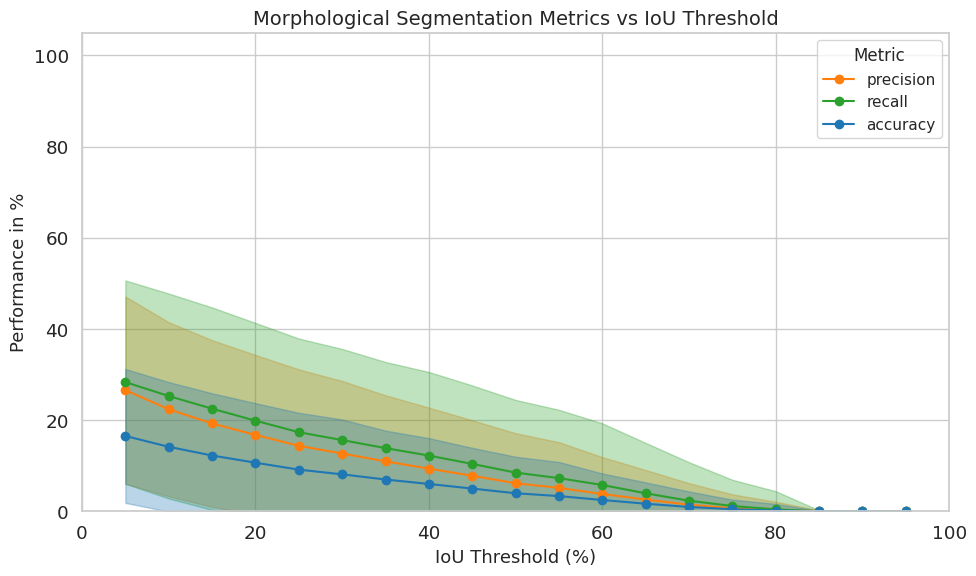

<ipython-input-5-6aa101523773>:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="metric", y="score", palette="pastel")


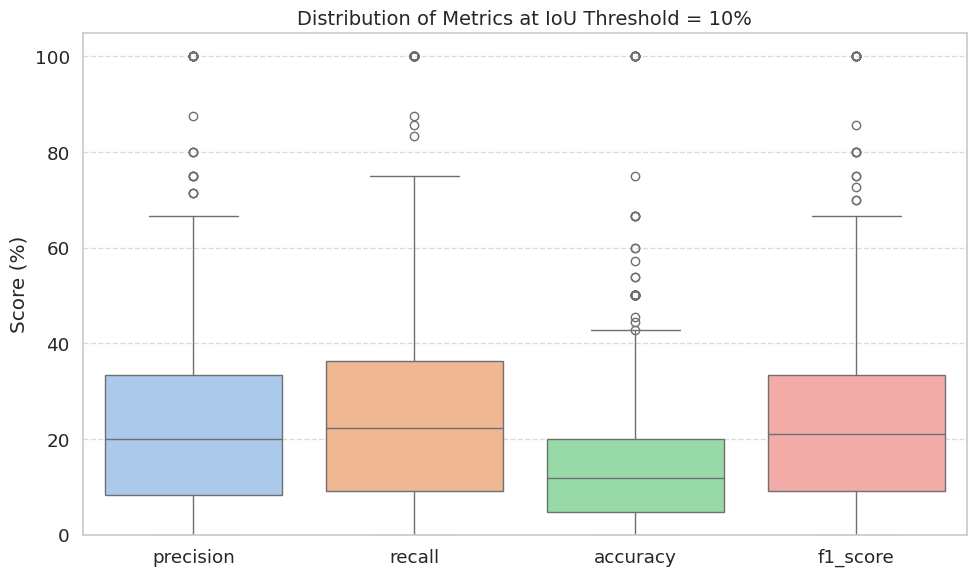

In [ ]:


# === CONFIGURATION ===
image_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
label_dirs = [
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg/labels",
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg/labels",
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/test-seg/labels"
]
morph_mask_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/morph-masks"
IOU_MATCH_THRESHOLD = 0.1  # Use 10% IoU threshold for TP
MERGE_DISTANCE_THRESHOLD = 200  # pixel distance to merge segments

# === Build image map ===
image_map = {}
for path in glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True):
    base = os.path.splitext(os.path.basename(path))[0]
    image_map[base] = path

# === Region-level evaluation ===
eval_rows = []

for mask_path in glob(os.path.join(morph_mask_dir, "**", "*.png"), recursive=True):
    base = os.path.splitext(os.path.basename(mask_path))[0]

    # Match label
    label_path = None
    for label_dir in label_dirs:
        candidate = os.path.join(label_dir, base + ".txt")
        if os.path.exists(candidate):
            label_path = candidate
            break

    image_path = image_map.get(base)
    if not label_path or not image_path:
        continue

    image = cv2.imread(image_path)
    if image is None:
        continue
    h, w = image.shape[:2]

    # Load predicted mask and merge close segments
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    labeled = label(mask > 0)
    props = regionprops(labeled)
    if len(props) == 0:
        continue

    centroids = np.array([r.centroid for r in props])
    distances = cdist(centroids, centroids)

    merged = np.zeros_like(mask, dtype=np.uint8)
    visited = set()
    for i, r1 in enumerate(props):
        if i in visited:
            continue
        group = [i]
        for j in range(i + 1, len(props)):
            if distances[i, j] <= MERGE_DISTANCE_THRESHOLD:
                group.append(j)
        merged_mask = np.zeros_like(mask, dtype=bool)
        for g in group:
            merged_mask |= (labeled == props[g].label)
            visited.add(g)
        merged[label(merged_mask) == 1] = 255  # assign merged segment

    labeled_mask = label(merged > 0)
    pred_regions = [region for region in regionprops(labeled_mask) if region.area > 0]

    # Load ground truth polygons from YOLO format
    gt_polygons = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            coords = list(map(float, parts[1:]))
            points = np.array([[coords[i] * w, coords[i + 1] * h] for i in range(0, len(coords), 2)])
            gt_polygons.append(Polygon(points))

    matched_gts = set()
    for region in pred_regions:
        region_mask = (labeled_mask == region.label).astype(np.uint8)
        contours, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        contour = contours[0].squeeze()
        if contour.ndim != 2:
            continue
        pred_poly = Polygon(contour)

        best_iou = 0
        best_gt = -1
        for j, gt in enumerate(gt_polygons):
            if not gt.is_valid or not pred_poly.is_valid:
                continue
            iou = pred_poly.intersection(gt).area / pred_poly.union(gt).area
            if iou > best_iou:
                best_iou = iou
                best_gt = j

        eval_rows.append({
            "image": base,
            "iou": best_iou,
            "matched_gt": best_gt if best_iou >= IOU_MATCH_THRESHOLD else None,
            "is_tp": int(best_iou >= IOU_MATCH_THRESHOLD),
            "is_fp": int(best_iou < IOU_MATCH_THRESHOLD),
            "is_fn": 0
        })

    for j in range(len(gt_polygons)):
        if j not in {r["matched_gt"] for r in eval_rows if r["image"] == base}:
            eval_rows.append({
                "image": base,
                "iou": 0.0,
                "matched_gt": j,
                "is_tp": 0,
                "is_fp": 0,
                "is_fn": 1
            })

# === Metric evaluation ===
if eval_rows:
    df_eval = pd.DataFrame(eval_rows)

    thresholds = np.arange(0.05, 0.95 + 0.01, 0.05)
    all_metrics = []

    for t in thresholds:
        df_t = df_eval.copy()
        df_t["is_tp"] = ((df_t["iou"] >= t) & (df_t["is_fn"] == 0)).astype(int)
        df_t["is_fp"] = ((df_t["iou"] < t) & (df_t["is_fn"] == 0)).astype(int)
        df_t["is_fn"] = (df_t["is_fn"] == 1).astype(int)

        for image_id, group in df_t.groupby("image"):
            tp = group["is_tp"].sum()
            fp = group["is_fp"].sum()
            fn = group["is_fn"].sum()

            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            accuracy = tp / (tp + fp + fn + 1e-6)
            f1 = 2 * precision * recall / (precision + recall + 1e-6)

            all_metrics.append({
                "image": image_id,
                "iou_threshold": t,
                "precision": precision * 100,
                "recall": recall * 100,
                "accuracy": accuracy * 100,
                "f1_score": f1 * 100
            })

    df_metrics = pd.DataFrame(all_metrics)

    # === Summary plot (line + shaded std) ===
    summary = df_metrics.groupby("iou_threshold").agg({
        "precision": ["mean", "std"],
        "recall": ["mean", "std"],
        "accuracy": ["mean", "std"]
    }).reset_index()
    summary.columns = ["iou_threshold",
                       "precision_mean", "precision_std",
                       "recall_mean", "recall_std",
                       "accuracy_mean", "accuracy_std"]

    plot_df = pd.DataFrame({
        "iou_threshold": np.tile(summary["iou_threshold"] * 100, 3),
        "metric": ["precision"] * len(summary) + ["recall"] * len(summary) + ["accuracy"] * len(summary),
        "mean": pd.concat([summary["precision_mean"],
                           summary["recall_mean"],
                           summary["accuracy_mean"]], ignore_index=True),
        "std": pd.concat([summary["precision_std"],
                          summary["recall_std"],
                          summary["accuracy_std"]], ignore_index=True)
    })

    # === Plot 1: Line + shaded performance ===
    plt.figure(figsize=(10, 6))
    palette = {"accuracy": "#1f77b4", "precision": "#ff7f0e", "recall": "#2ca02c"}
    for metric in plot_df["metric"].unique():
        subset = plot_df[plot_df["metric"] == metric]
        x_vals = subset["iou_threshold"]
        plt.plot(x_vals, subset["mean"], label=metric, marker='o', color=palette[metric])
        plt.fill_between(x_vals,
                         subset["mean"] - subset["std"],
                         subset["mean"] + subset["std"],
                         alpha=0.3, color=palette[metric])
    plt.xlabel("IoU Threshold (%)", fontsize=13)
    plt.ylabel("Performance in %", fontsize=13)
    plt.title("Morphological Segmentation Metrics vs IoU Threshold", fontsize=14)
    plt.xticks(np.arange(0, 101, 20))
    plt.ylim(0, 105)
    plt.legend(title="Metric", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Boxplot at IoU = 0.1 ===
    df_box = df_metrics[df_metrics["iou_threshold"] == 0.1][
        ["image", "precision", "recall", "accuracy", "f1_score"]
    ]
    df_melted = df_box.melt(id_vars="image", var_name="metric", value_name="score")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="metric", y="score", palette="pastel")
    plt.title("Distribution of Metrics at IoU Threshold = 10%", fontsize=14)
    plt.ylabel("Score (%)")
    plt.xlabel("")
    plt.ylim(0, 105)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("❌ No region-level evaluations found.")


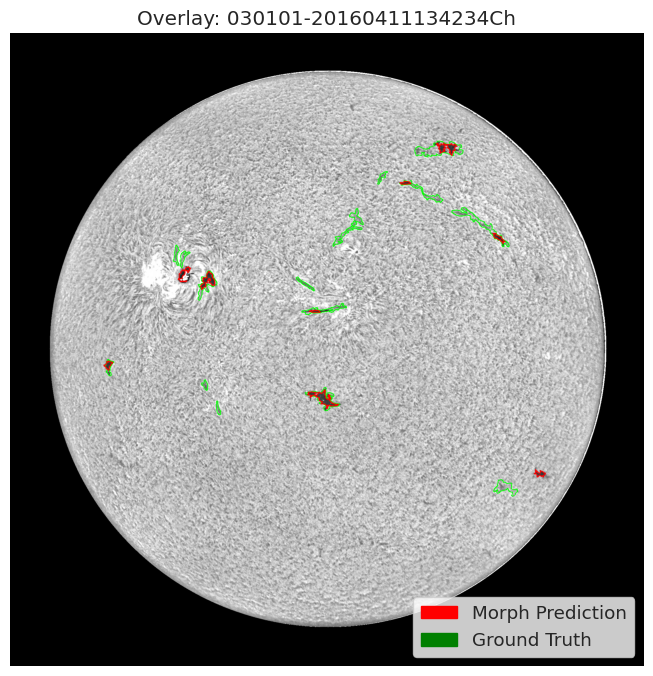

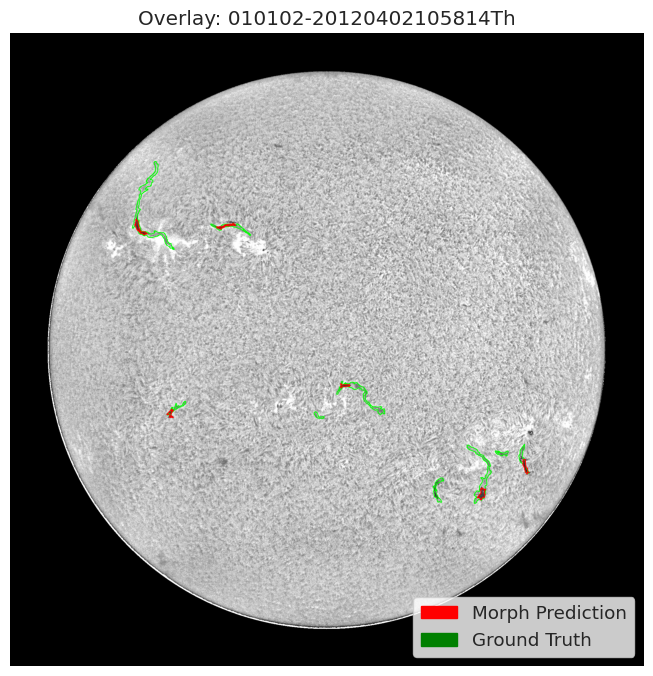

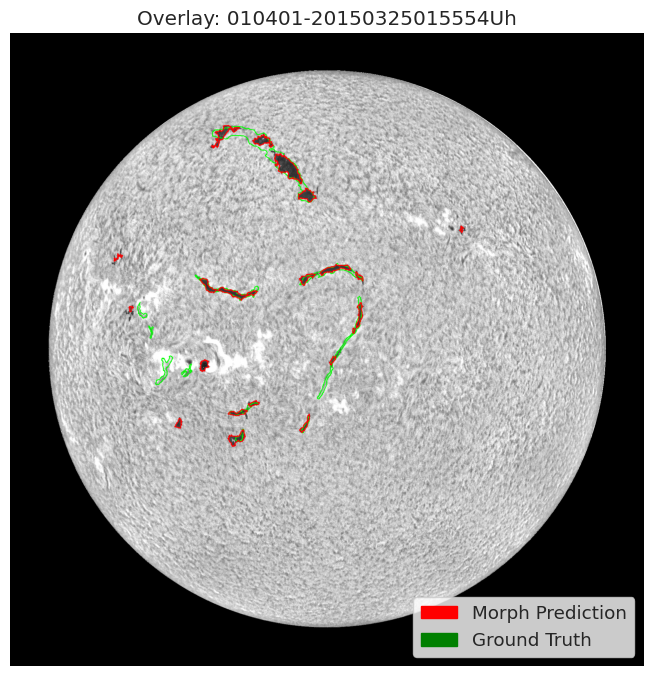

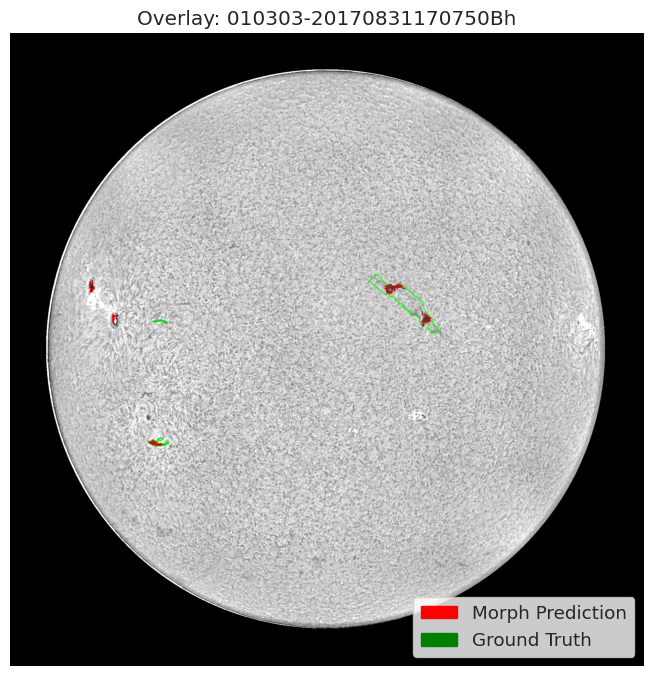

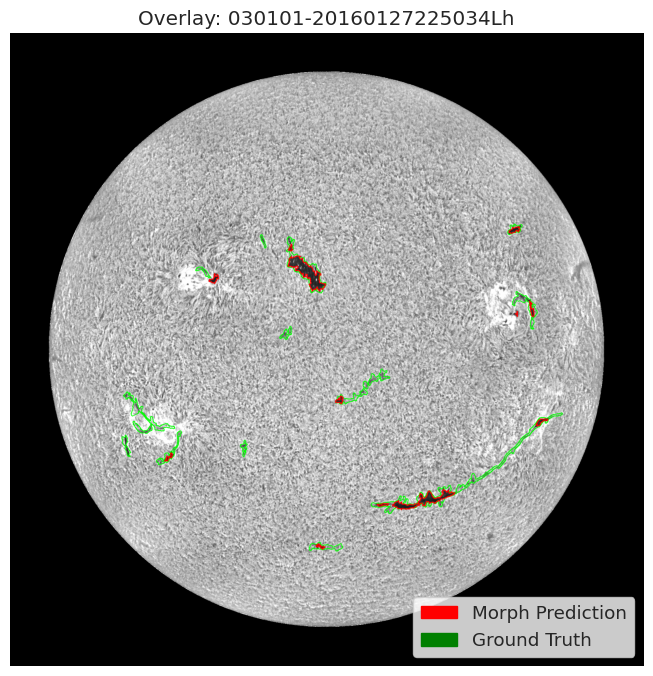

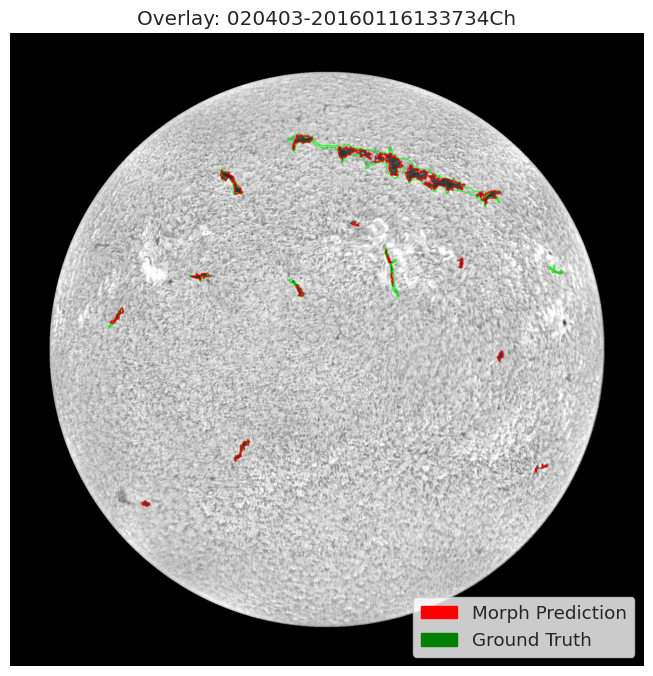

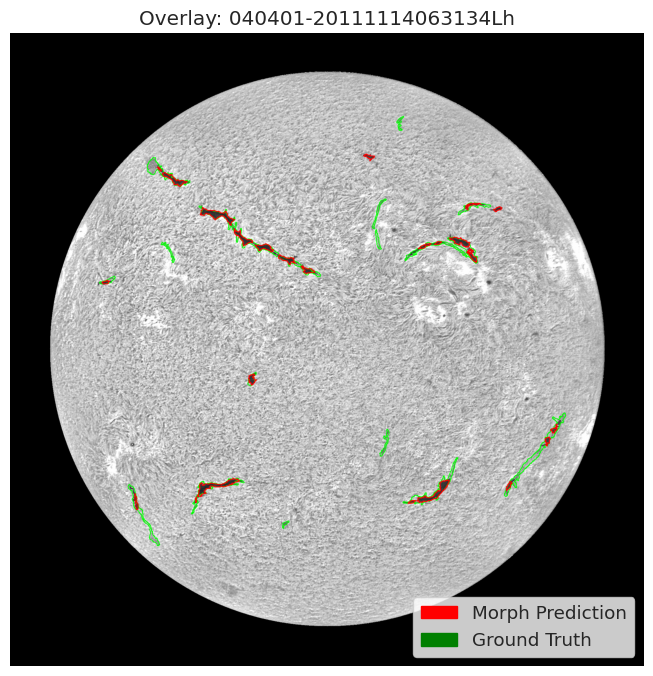

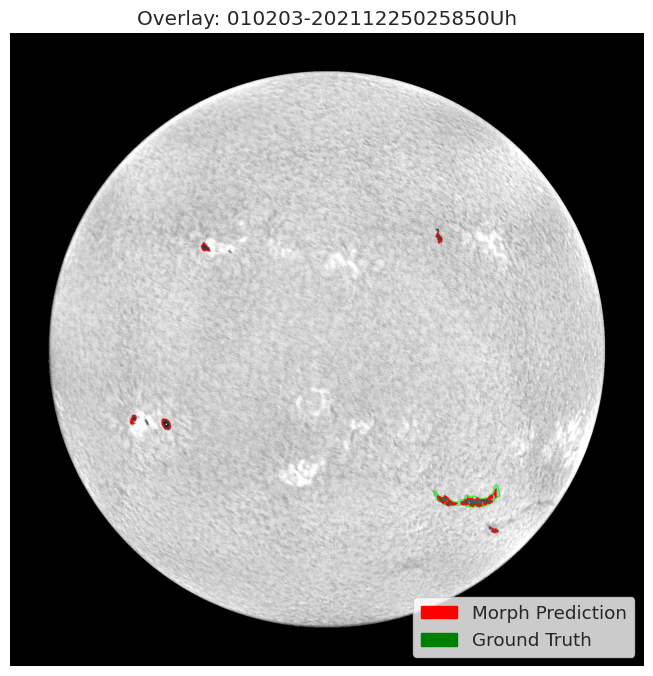

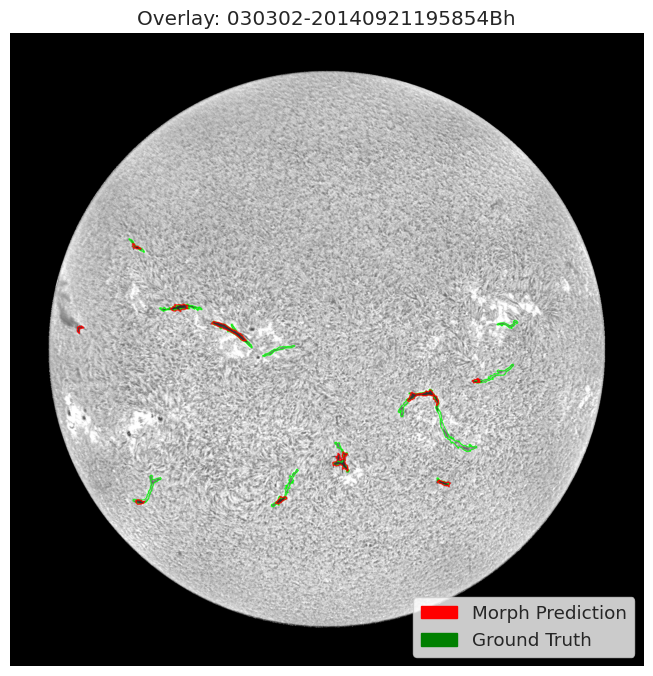

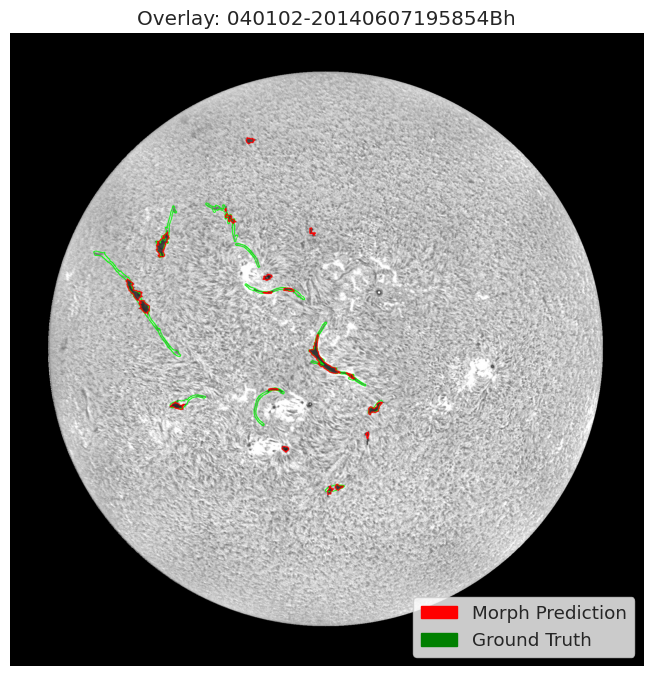

In [ ]:


# === CONFIGURATION ===
image_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
label_dirs = [
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg/labels",
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg/labels",
    "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/test-seg/labels"
]
morph_mask_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/morph-masks"

# === Build image map ===
image_map = {}
for path in glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True):
    base = os.path.splitext(os.path.basename(path))[0]
    image_map[base] = path

# === Get 10 random valid base names that have labels and masks ===
all_mask_paths = glob(os.path.join(morph_mask_dir, "**", "*.png"), recursive=True)
valid_bases = []
for mask_path in all_mask_paths:
    base = os.path.splitext(os.path.basename(mask_path))[0]
    if base in image_map:
        for label_dir in label_dirs:
            if os.path.exists(os.path.join(label_dir, base + ".txt")):
                valid_bases.append((base, mask_path))
                break

# Sample 10 random
random.shuffle(valid_bases)
selected = valid_bases[:10]

# === Visualize overlays ===
for base, mask_path in selected:
    image_path = image_map[base]
    label_path = None
    for label_dir in label_dirs:
        candidate = os.path.join(label_dir, base + ".txt")
        if os.path.exists(candidate):
            label_path = candidate
            break

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = image_rgb.copy()
    h, w = image.shape[:2]

    # === Ground Truth: Draw green polygons ===
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            coords = list(map(float, parts[1:]))
            points = np.array([[coords[i] * w, coords[i + 1] * h] for i in range(0, len(coords), 2)], dtype=np.int32)
            cv2.polylines(overlay, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    # === Morph Predictions: Draw red contours ===
    pred_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours((pred_mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cnt.shape[0] >= 3:
            cv2.polylines(overlay, [cnt], isClosed=True, color=(255, 0, 0), thickness=2)

    # === Display ===
    plt.figure(figsize=(7, 7))
    plt.imshow(overlay)
    plt.title(f"Overlay: {base}")
    plt.axis("off")
    legend_patches = [
        Patch(color='red', label='Morph Prediction'),
        Patch(color='green', label='Ground Truth ')
    ]
    plt.legend(handles=legend_patches, loc='lower right', frameon=True)
    plt.tight_layout()
    plt.show()


# **# Read MAGFILO annotations**

In [ ]:
# Path to the annotation file
annotations_path = "/home/vsolomon3/failed-filaments-project/magfilo/magfilo_2024_v1.0.json"
# Load the JSON file
with open(annotations_path, "r") as f:
    coco_annotations = json.load(f)

# Print dataset summary
print("Number of images:", len(coco_annotations["images"]))
print("Number of annotations:", len(coco_annotations["annotations"]))
print("Categories:", [cat["name"] for cat in coco_annotations["categories"]])
#Extract unique image filenames
unique_filenames = set(img["file_name"] for img in coco_annotations["images"])

# Print the number of unique images
# print("Number of unique images:", len(unique_filenames))
# # Display a sample annotation
# print("\nSample Annotation:")
# print(json.dumps(coco_annotations["annotations"][1], indent=4))


Number of images: 1593
Number of annotations: 10244
Categories: ['Left', 'Right', 'Unidentifiable']


# **# create segmentation masks**

In [ ]:


# Paths
annotations_path = "/home/vsolomon3/failed-filaments-project/magfilo/magfilo_2024_v1.0.json"
image_dir = os.path.join(os.getcwd(), "gong-halpha")  # Root directory containing images
output_dir = "/home/vsolomon3/failed-filaments-project/seg-masks"  # Output directory for segmentation masks

# Load COCO annotations
with open(annotations_path, "r") as f:
    coco_annotations = json.load(f)

# Create output directory if it doesn’t exist
os.makedirs(output_dir, exist_ok=True)

# Create a lookup for image dimensions by image_id
image_dims = {img["id"]: (img["height"], img["width"]) for img in coco_annotations["images"]}

# Group annotations by image_id (some images have multiple IDs)
annotations_by_image = {}
for annotation in coco_annotations["annotations"]:
    image_id = annotation["image_id"]
    if image_id not in annotations_by_image:
        annotations_by_image[image_id] = []
    annotations_by_image[image_id].append(annotation)

def polygons_to_mask(image_shape, polygons, instance_id):
    """Convert COCO polygon annotations into an instance mask."""
    mask = np.zeros(image_shape, dtype=np.uint8)
    reshaped_polygons = [np.array(polygons, dtype=np.int32).reshape(-1, 2)]
    cv2.fillPoly(mask, reshaped_polygons, instance_id)
    return mask

def get_all_images(image_dir):
    """Recursively find all JPEG image filenames (without extension) in all subdirectories."""
    existing_filenames = {}
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".jpeg"):
                base_name = os.path.splitext(file)[0]
                relative_path = os.path.relpath(os.path.join(root, file), image_dir)
                existing_filenames[base_name] = relative_path

    print(f"Found {len(existing_filenames)} images in {image_dir} (all subdirectories)")
    return existing_filenames

def find_related_annotations(image_filename):
    """Find all image IDs in annotations that contain this filename."""
    match = re.search(r'(\d{14}[A-Za-z]+)', image_filename)
    if match:
        timestamp = match.group(1)

        # Collect all matching annotations for this image
        matching_annotations = []
        for img_id, annotations in annotations_by_image.items():
            if timestamp in img_id:  # Check if timestamp exists within the full image_id
                matching_annotations.extend(annotations)

        return matching_annotations

    return []

# Get all JPEG images in `image_dir`
available_images = get_all_images(image_dir)

# Generate segmentation masks for every image in `gong-halpha`
print("\nGenerating segmentation masks for all images in `image_dir`...\n")
processed_count = 0

for file_name in tqdm(available_images.keys(), desc="Processing images"):
    # Find all annotations linked to this image
    annotations = find_related_annotations(file_name)

    # Get image dimensions (use actual dimensions from annotations if available)
    if annotations:
        height, width = image_dims.get(annotations[0]["image_id"], (1024, 1024))
    else:
        height, width = (1024, 1024)  # Default for images without annotations

    # Initialize blank mask
    instance_mask = np.zeros((height, width), dtype=np.uint8)

    # Overlay all segmentation masks from different annotations (if available)
    instance_id = 1
    for annotation in annotations:
        for segmentation in annotation["segmentation"]:
            filament_mask = polygons_to_mask((height, width), segmentation, instance_id)
            instance_mask = np.maximum(instance_mask, filament_mask)
            instance_id += 1

    # Construct output filename and preserve subdirectory structure
    relative_path = available_images[file_name]
    mask_subdir = os.path.dirname(relative_path)
    mask_filename = f"{file_name}_seg_mask.png"
    mask_path = os.path.join(output_dir, mask_subdir, mask_filename)

    # Ensure the subdirectory exists in `output_dir`
    os.makedirs(os.path.dirname(mask_path), exist_ok=True)

    # Save the segmentation mask
    Image.fromarray(instance_mask).save(mask_path)

    processed_count += 1

print(f"\nDone! {processed_count} segmentation masks saved to: {output_dir}\n")


Found 958 images in /home/vsolomon3/gong-halpha (all subdirectories)

Generating segmentation masks for all images in `image_dir`...



Processing images: 100%|████████████████████████████████████████████████████| 958/958 [00:39<00:00, 24.04it/s]


Done! 958 segmentation masks saved to: /home/vsolomon3/failed-filaments-project/seg-masks



# **# View masks on full disk**

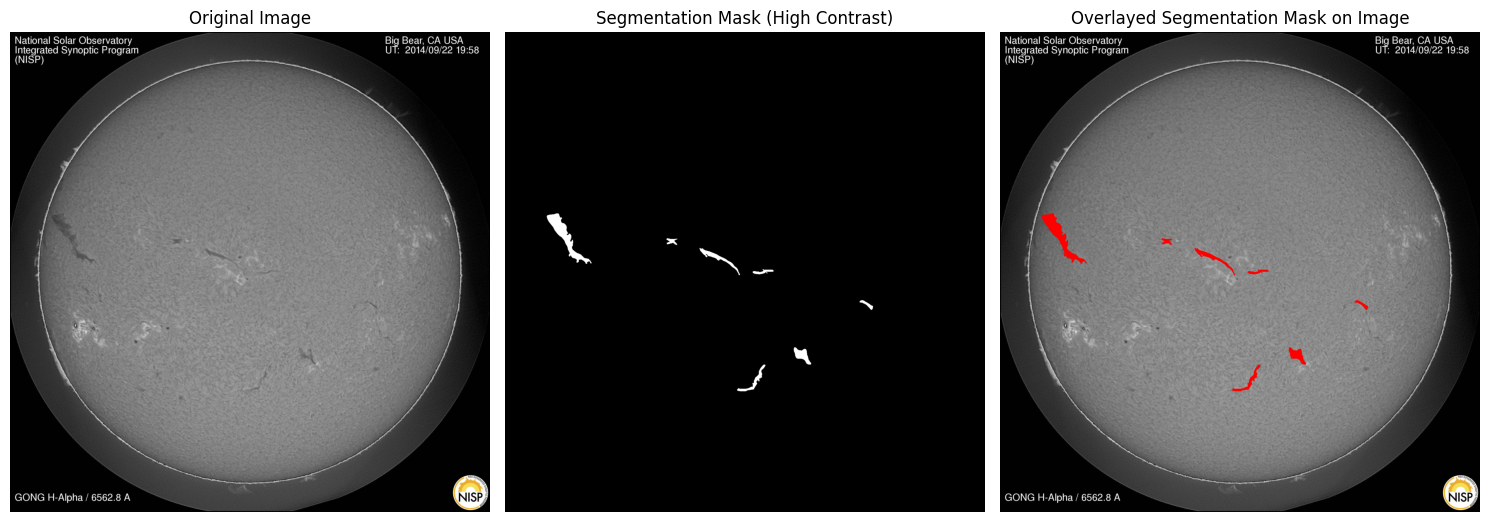

In [ ]:


# Choose an image to visualize
image_filename = "20140922195854Bh.jpeg"  # Change this to your filename
image_dir = '/content/drive/MyDrive/filament-detection-project/data/YOLO-data/images'  # Root directory for all years
output_dir = "/content/drive/MyDrive/filament-detection-project/data/seg-masks"  # Output directory for segmentation masks

# Define paths
image_path = os.path.join(image_dir, "2014", "09", "22", image_filename)
mask_filename = image_filename.replace(".jpeg", "_seg_mask.png")  # Adjusted for segmentation masks
mask_path = os.path.join(output_dir, "2014", "09", "22", mask_filename)

# Load original image
if os.path.exists(image_path):
    original_image = Image.open(image_path)
    original_array = np.array(original_image)
else:
    print(f"Image not found: {image_path}")
    exit()

# Load segmentation mask
if os.path.exists(mask_path):
    mask_image = Image.open(mask_path)
    mask_array = np.array(mask_image)
else:
    print(f"Mask not found: {mask_path}")
    exit()

# Ensure segmentation masks are visible by increasing contrast
mask_array = np.where(mask_array > 0, 255, 0).astype(np.uint8)  # Make all segmentations fully white

# Overlay mask on the original image
overlay = original_array.copy()
if len(overlay.shape) == 2:  # Convert grayscale to RGB if needed
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)

# Color the segmentation masks in red
overlay[mask_array > 0] = [255, 0, 0]  # Red segmentation overlay

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Show the original image
axes[0].imshow(original_image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show the segmentation mask (high contrast)
axes[1].imshow(mask_array, cmap="gray")
axes[1].set_title("Segmentation Mask (High Contrast)")
axes[1].axis("off")

# Show the overlayed image
axes[2].imshow(overlay)
axes[2].set_title("Overlayed Segmentation Mask on Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# **create YOLO bbox labels**

In [ ]:


# Paths
annotations_path = "/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json"
images_folder = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
output_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/labels"

os.makedirs(output_dir, exist_ok=True)

# Load COCO JSON
with open(annotations_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

# Validate keys
if "images" not in coco_data or "annotations" not in coco_data:
    print("JSON file missing required keys: 'images' or 'annotations'")
    exit()

# Map image_id → metadata
image_info = {
    str(img["id"]): {
        "file_name": img["file_name"],
        "height": img["height"],
        "width": img["width"]
    }
    for img in coco_data["images"]
}

# Group annotations by image_id
annotations_by_id = {}
for ann in coco_data["annotations"]:
    image_id = str(ann["image_id"])
    annotations_by_id.setdefault(image_id, []).append(ann)

# Get all image paths
def get_all_images(image_dir):
    image_paths = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_all_images(images_folder)

# Generate YOLO label files
num_labels_generated = 0

for image_path in image_paths:
    stem = Path(image_path).stem

    if stem not in image_info:
        print(f"Image ID not found in JSON: {stem}")
        continue

    if stem not in annotations_by_id:
        print(f"Skipping (no annotations): {stem}")
        continue

    label_file_path = os.path.join(output_dir, f"{stem}.txt")
    if os.path.exists(label_file_path):
        print(f"Skipping (already exists): {stem}.txt")
        continue

    annotations = annotations_by_id[stem]

    try:
        with Image.open(image_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"Error opening image {stem}: {e}")
        continue

    with open(label_file_path, "w") as label_file:
        for ann in annotations:
            x_min, y_min, box_width, box_height = ann["bbox"]

            x_center = (x_min + box_width / 2) / img_width
            y_center = (y_min + box_height / 2) / img_height
            norm_width = box_width / img_width
            norm_height = box_height / img_height

            class_id = 0  #  Use single class for all annotations
            label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}\n")

    num_labels_generated += 1
    print(f"Processed: {stem} ({len(annotations)} annotations)")

print(f"\n Total YOLO label files created: {num_labels_generated}")
print(f" Labels saved in: {output_dir}")


Processed: 010103-20210607142350Bh (2 annotations)
Processed: 010101-20210607142350Bh (3 annotations)
Processed: 010102-20210607142350Bh (2 annotations)
Processed: 010303-20210624133950Bh (1 annotations)
Processed: 010302-20210624133950Bh (2 annotations)
Processed: 010403-20210626060050Uh (2 annotations)
Processed: 040301-20210626133950Bh (3 annotations)
Processed: 040303-20210626133950Bh (1 annotations)
Processed: 010203-20210621133650Bh (2 annotations)
Processed: 030101-20210627163630Mh (7 annotations)
Processed: 040401-20210616142650Bh (1 annotations)
Processed: 040402-20210616142650Bh (4 annotations)
Processed: 040201-20210620163530Mh (6 annotations)
Processed: 010103-20210708060030Lh (1 annotations)
Processed: 010101-20210708060030Lh (3 annotations)
Processed: 010102-20210708060030Lh (2 annotations)
Processed: 010402-20210726041650Uh (6 annotations)
Processed: 010401-20210726041650Uh (2 annotations)
Processed: 010403-20210726041650Uh (3 annotations)
Processed: 010103-2021070116373

# **#Split data into train and validation**

In [ ]:


# === Paths ===
dataset_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data"
images_folder = os.path.join(dataset_dir, "gong-jpgs")
labels_folder = os.path.join(dataset_dir, "labels")

# === Output folders ===
train_dir = os.path.join(dataset_dir, "train")
valid_dir = os.path.join(dataset_dir, "validation")
test_dir  = os.path.join(dataset_dir, "test")

# Create folders with subdirectories
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# === Gather all valid image-label pairs ===
image_paths = glob.glob(os.path.join(images_folder, "**", "*.jpg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.jpeg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.png"), recursive=True)

valid_image_label_pairs = []
for image_path in image_paths:
    file_name = os.path.basename(image_path)
    base_name, _ = os.path.splitext(file_name)
    label_path = os.path.join(labels_folder, base_name + ".txt")

    if os.path.exists(label_path):
        valid_image_label_pairs.append((image_path, label_path))
    else:
        print(f" Warning: No label found for {file_name}, skipping.")

if len(valid_image_label_pairs) == 0:
    print(" No images with labels found. Check your dataset paths.")
    exit()

# === Shuffle and Split ===
random.seed(42)
random.shuffle(valid_image_label_pairs)

total = len(valid_image_label_pairs)
train_split = int(0.8 * total)
valid_split = int(0.9 * total)

train_pairs = valid_image_label_pairs[:train_split]
valid_pairs = valid_image_label_pairs[train_split:valid_split]
test_pairs  = valid_image_label_pairs[valid_split:]

# === Copy helper ===
def copy_files(pairs, target_image_dir, target_label_dir):
    for image_path, label_path in pairs:
        shutil.copy(image_path, os.path.join(target_image_dir, os.path.basename(image_path)))
        shutil.copy(label_path, os.path.join(target_label_dir, os.path.basename(label_path)))

# === Copy files to destinations ===
copy_files(train_pairs, os.path.join(train_dir, "images"), os.path.join(train_dir, "labels"))
copy_files(valid_pairs, os.path.join(valid_dir, "images"), os.path.join(valid_dir, "labels"))
copy_files(test_pairs,  os.path.join(test_dir,  "images"), os.path.join(test_dir,  "labels"))

# === Summary ===
print("\n Dataset split completed:")
print(f"  Train      -> {len(train_pairs)} image-label pairs")
print(f"  Validation -> {len(valid_pairs)} image-label pairs")
print(f"  Test       -> {len(test_pairs)} image-label pairs")



 Dataset split completed:
  Train      -> 1151 image-label pairs
  Validation -> 144 image-label pairs
  Test       -> 144 image-label pairs


# **#create .yaml file**

In [ ]:


def create_data_yaml(classes, path_to_data_yaml):
    number_of_classes = len(classes)

    if number_of_classes == 0:
        print(" Error: No class names provided.")
        return

    data = {
        'path': '/content/drive/MyDrive/filament-detection-project/data/YOLO-data',
        'train': 'train/images',
        'val': 'validation/images',
        'test': 'test/images',
        'nc': number_of_classes,
        'names': classes,  # Directly use provided class names
    }

    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f" Created config file at {path_to_data_yaml}")

# ==== Define class names directly here ====
classes = ['F']  # You can modify this list directly

# ==== Define output path ====
path_to_data_yaml = '/content/drive/MyDrive/filament-detection-project/data/data.yaml'

# ==== Run it ====
create_data_yaml(classes, path_to_data_yaml)

# === Print the contents ===
print("\n📄 File contents:\n")
with open(path_to_data_yaml, 'r', encoding='utf-8') as f:
    print(f.read())


 Created config file at /content/drive/MyDrive/filament-detection-project/data/data.yaml

📄 File contents:

path: /content/drive/MyDrive/filament-detection-project/data/YOLO-data
train: train/images
val: validation/images
test: test/images
nc: 1
names:
- F



In [ ]:
!pip uninstall -y albumentations

Found existing installation: albumentations 2.0.5
Uninstalling albumentations-2.0.5:
  Successfully uninstalled albumentations-2.0.5


# **# Train Model**

In [ ]:

# Load YOLO model
model = YOLO("yolo11l.yaml")  # Load YOLO model (not pretrained)

# Training parameters
data_path = "/content/drive/MyDrive/filament-detection-project/data/data.yaml"

results = model.train(data=data_path, epochs=50,  batch=8)



Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.yaml, data=/content/drive/MyDrive/filament-detection-project/data/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 92.3MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

 10                  -1  2   1455616  ultralytics.nn.modules.block.C2PSA           [512, 512, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   2496512  ultralytics.nn.modules.block.C3k2            [1024, 512, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  2    756736  ultralytics.nn.modules.block.C3k2            [1024, 256, 2, True]          
 17                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 283MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.8±0.1 MB/s, size: 814.9 KB)


train: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-bbox/labels.cache... 1151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1151/1151 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.5±0.0 ms, read: 1.0±0.2 MB/s, size: 848.3 KB)


val: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-bbox/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.29G      4.246        4.1      3.209         49        640: 100%|██████████| 144/144 [01:18<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all        144        980      0.184      0.123     0.0717     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.42G      3.008      2.221      1.994         43        640: 100%|██████████| 144/144 [00:52<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

                   all        144        980      0.262      0.252      0.162     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.52G      2.679      1.973      1.762         45        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]

                   all        144        980      0.293      0.199      0.143      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.52G       2.51      1.886      1.665         46        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.354      0.378      0.293      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.52G      2.375      1.777      1.585         69        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        144        980       0.43      0.365      0.343      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.52G      2.257      1.673      1.522         88        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.531      0.409      0.394       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.52G       2.23       1.67      1.516         46        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

                   all        144        980        0.5      0.422      0.423      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.61G      2.137      1.629      1.473         37        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.509      0.439      0.434       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.71G      2.076      1.579      1.433         79        640: 100%|██████████| 144/144 [00:52<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]

                   all        144        980      0.513      0.427      0.412       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.71G      2.039      1.545      1.416         54        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.508      0.485      0.466        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.71G      2.008      1.517      1.399         87        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        144        980      0.517      0.438      0.431      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.71G      1.982      1.536       1.39         82        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.512      0.436      0.436      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.71G      1.961      1.505      1.379         70        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        144        980      0.544      0.449      0.451      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.71G      1.922       1.48      1.354         62        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980       0.57      0.455      0.476      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.71G       1.93      1.455      1.359         56        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        144        980      0.566      0.486      0.499      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.71G      1.931      1.481      1.367         48        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.532      0.533      0.504      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.71G      1.887      1.454      1.352         49        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]

                   all        144        980      0.567      0.473       0.49       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.71G      1.883      1.457      1.351        118        640: 100%|██████████| 144/144 [00:52<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.577      0.511      0.532      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.71G      1.863      1.418      1.338         75        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        144        980       0.55      0.484      0.497      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.71G      1.835      1.424      1.335         70        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.573      0.532       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.71G      1.818      1.394      1.309        114        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        144        980      0.597      0.466      0.506      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.71G       1.82      1.397      1.303         79        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        144        980      0.568      0.506      0.535      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.71G      1.788      1.381      1.319         48        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        144        980      0.607      0.492      0.536      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.71G      1.767      1.367      1.296         37        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.607       0.48      0.541      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.71G      1.769      1.369      1.285         64        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        144        980      0.541      0.529      0.523      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.71G      1.763      1.333      1.271         64        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.615      0.516      0.561      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.71G      1.735      1.345      1.282         62        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        144        980      0.532      0.483      0.512      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.71G      1.746      1.354      1.285         50        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.592      0.506      0.535      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.71G      1.715      1.322      1.276         71        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.562      0.533      0.548      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.71G      1.702      1.306      1.271         67        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.581      0.514      0.544      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.71G      1.698      1.291       1.25         52        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.566      0.538      0.544      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.71G      1.686      1.301      1.252         84        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.619      0.536      0.573      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.71G      1.678      1.285      1.243         46        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        144        980      0.579      0.527      0.555       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.71G       1.68       1.27      1.253         72        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        144        980      0.588      0.529      0.557      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.71G      1.665      1.305      1.255         69        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        144        980      0.566       0.51      0.537      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.71G      1.654      1.267      1.238         47        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.587      0.559       0.58      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.71G      1.659      1.278      1.235         80        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.541      0.563      0.546      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.71G      1.641      1.256      1.224        105        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.601      0.526      0.578      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.71G       1.65      1.258      1.238         77        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980       0.59      0.545      0.573      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.71G      1.615      1.236      1.224         52        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

                   all        144        980      0.637      0.548      0.596      0.303


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.71G      1.583      1.239      1.252         48        640: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

                   all        144        980      0.585      0.577      0.587      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.71G       1.56      1.227      1.248         45        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980        0.6      0.555      0.597      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.71G      1.548      1.194      1.241         39        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.594      0.565      0.594      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.71G      1.546      1.182      1.237         34        640: 100%|██████████| 144/144 [00:52<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.588      0.582      0.602      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.71G      1.544      1.182      1.236         59        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        144        980      0.605      0.569      0.606      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.71G      1.526      1.182      1.232         48        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.615      0.553      0.605      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.71G      1.524      1.172      1.225         33        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        144        980      0.591      0.601      0.606      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.71G      1.504       1.16      1.225         49        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        144        980      0.619      0.573      0.614       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.71G      1.495      1.158      1.211         44        640: 100%|██████████| 144/144 [00:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        144        980      0.579      0.607      0.616      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.71G      1.486      1.149      1.216         55        640: 100%|██████████| 144/144 [00:52<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        144        980      0.608      0.577      0.617      0.323



50 epochs completed in 0.784 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


                   all        144        980      0.608      0.577      0.617      0.323
Speed: 0.2ms preprocess, 14.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


In [ ]:

# === Load custom model ===
model = YOLO("/content/runs/detect/train/weights/best.pt")  # Load trained YOLO model

# === Run prediction on test set (images only, no labels or conf shown) ===
results = model.predict(
    source="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images",  # test image folder
    save=True,              # save annotated results
    show_labels=False,      # hide class labels
    show_conf=False         # hide confidence values
)

# === Optionally, evaluate performance on the test set ===
metrics = model.val(split='test')
print(f"mAP@50: {metrics.box.map50:.4f}")



image 1/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20130903060834Lh.jpg: 1024x1024 8 Fs, 103.2ms
image 2/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20131017185334Ch.jpg: 1024x1024 10 Fs, 62.2ms
image 3/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20140513012554Uh.jpg: 1024x1024 12 Fs, 62.4ms
image 4/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20140604195854Bh.jpg: 1024x1024 3 Fs, 61.5ms
image 5/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20150626161514Mh.jpg: 1024x1024 6 Fs, 59.7ms
image 6/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20151117172314Mh.jpg: 1024x1024 6 Fs, 60.3ms
image 7/144 /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/images/010101-20160320133714Th.jpg: 1024x1024 6 Fs, 59.6ms
image 8/1

val: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/test/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


                   all        144       1179      0.655      0.625      0.653      0.367
Speed: 3.7ms preprocess, 77.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val4
mAP@50: 0.6529


# **#YOLO segmentation**

generate segmentation masks for YOLO

In [ ]:

# === Paths ===
annotations_path = "/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json"
output_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/seg-labels"

os.makedirs(output_dir, exist_ok=True)

# === Load COCO JSON
with open(annotations_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)
print(" JSON loaded successfully!")

# === Group annotations by image_id
annotations_by_image_id = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    annotations_by_image_id.setdefault(img_id, []).append(ann)

# === Process each image in COCO
num_labels_generated = 0

print(" All categories will be treated as class 0 for YOLO segmentation.\n")

for image in coco_data["images"]:
    img_id = image["id"]
    img_height = image["height"]
    img_width = image["width"]

    annotations = annotations_by_image_id.get(img_id, [])
    if not annotations:
        continue  # No annotations for this image

    # Save label file using the image_id
    label_file_path = os.path.join(output_dir, f"{img_id}.txt")
    valid_annotation_found = False

    with open(label_file_path, "w") as label_file:
        for annotation in annotations:
            class_id = 0  # All treated as class 0
            segmentations = annotation.get("segmentation", [])

            # Ensure segmentations is a list of polygons (lists of floats)
            if not segmentations:
                print(f" No segmentation found for image ID {img_id}")
                continue

            # Handle flat list case
            if isinstance(segmentations[0], float):
                segmentations = [segmentations]

            if not all(isinstance(seg, list) and len(seg) >= 6 for seg in segmentations):
                print(f" Invalid polygon(s) in image ID {img_id}")
                continue

            for seg in segmentations:
                normalized_points = []
                for i in range(0, len(seg), 2):
                    x = seg[i] / img_width
                    y = seg[i + 1] / img_height
                    normalized_points.append(f"{x:.6f} {y:.6f}")

                label_line = f"{class_id} " + " ".join(normalized_points) + "\n"
                label_file.write(label_line)
                valid_annotation_found = True

    if valid_annotation_found:
        num_labels_generated += 1

print(f"\n Total YOLO segmentation label files created: {num_labels_generated}")
print(f"📂 Labels saved in: {output_dir}")


✅ JSON loaded successfully!
✅ All categories will be treated as class 0 for YOLO segmentation.


✅ Total YOLO segmentation label files created: 1439
📂 Labels saved in: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/seg-labels


split train, val, test

In [ ]:


# === Paths ===
dataset_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data"
images_folder = os.path.join(dataset_dir, "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs")
labels_folder = os.path.join(dataset_dir, "seg-labels")

# === Output folders ===
train_dir = os.path.join(dataset_dir, "train-seg")
valid_dir = os.path.join(dataset_dir, "validation-seg")
test_dir  = os.path.join(dataset_dir, "test-seg")

# Create folders with subdirectories
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# === Gather all valid image-label pairs ===
image_paths = glob.glob(os.path.join(images_folder, "**", "*.jpg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.jpeg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.png"), recursive=True)

valid_image_label_pairs = []
for image_path in image_paths:
    file_name = os.path.basename(image_path)
    base_name, _ = os.path.splitext(file_name)
    label_path = os.path.join(labels_folder, base_name + ".txt")

    if os.path.exists(label_path):
        valid_image_label_pairs.append((image_path, label_path))
    else:
        print(f" Warning: No label found for {file_name}, skipping.")

if len(valid_image_label_pairs) == 0:
    print(" No images with labels found. Check your dataset paths.")
    exit()

# === Shuffle and Split ===
random.seed(42)
random.shuffle(valid_image_label_pairs)

total = len(valid_image_label_pairs)
train_split = int(0.8 * total)
valid_split = int(0.9 * total)

train_pairs = valid_image_label_pairs[:train_split]
valid_pairs = valid_image_label_pairs[train_split:valid_split]
test_pairs  = valid_image_label_pairs[valid_split:]

# === Copy helper ===
def copy_files(pairs, target_image_dir, target_label_dir):
    for image_path, label_path in pairs:
        shutil.copy(image_path, os.path.join(target_image_dir, os.path.basename(image_path)))
        shutil.copy(label_path, os.path.join(target_label_dir, os.path.basename(label_path)))

# === Copy files to destinations ===
copy_files(train_pairs, os.path.join(train_dir, "images"), os.path.join(train_dir, "labels"))
copy_files(valid_pairs, os.path.join(valid_dir, "images"), os.path.join(valid_dir, "labels"))
copy_files(test_pairs,  os.path.join(test_dir,  "images"), os.path.join(test_dir,  "labels"))

# === Summary ===
print("\n Dataset split completed:")
print(f"  Train      -> {len(train_pairs)} image-label pairs")
print(f"  Validation -> {len(valid_pairs)} image-label pairs")
print(f"  Test       -> {len(test_pairs)} image-label pairs")



 Dataset split completed:
  Train      -> 1151 image-label pairs
  Validation -> 144 image-label pairs
  Test       -> 144 image-label pairs


Create YAML for Segmentation

In [ ]:

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):
    # Read classes.txt to get class names
    if not os.path.exists(path_to_classes_txt):
        print(f'Error: classes.txt file not found at {path_to_classes_txt}')
        return

    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]

    number_of_classes = len(classes)

    # Ensure at least one class exists
    if number_of_classes == 0:
        print("Error: No class names found in classes.txt.")
        return

    # Create data dictionary (now includes labels)
    data = {
        'path': '/content/drive/MyDrive/filament-detection-project/data/YOLO-data',
        'train': 'train-seg/images',
        'val': 'validation-seg/images',
        'test' : 'test-seg/images',
        'nc': number_of_classes,
        'names': classes  # Uses actual class names
    }

    # Write data to YAML file
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f' Created config file at {path_to_data_yaml}')

# Define paths and run function
path_to_classes_txt = '/content/drive/MyDrive/filament-detection-project/data/YOLO-data/classes.txt'
path_to_data_yaml = '/content/drive/MyDrive/filament-detection-project/data/seg-data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

# Display the generated file
print('\nFile contents:\n')
with open(path_to_data_yaml, 'r', encoding='utf-8') as f:
    print(f.read())



 Created config file at /content/drive/MyDrive/filament-detection-project/data/seg-data.yaml

File contents:

path: /content/drive/MyDrive/filament-detection-project/data/YOLO-data
train: train-seg/images
val: validation-seg/images
test: test-seg/images
nc: 1
names:
- F



In [ ]:
model = YOLO("yolo11x-seg.yaml")  #initialize model to be trianed from scratch
data_path = '/content/drive/MyDrive/filament-detection-project/data/seg-data.yaml'
# Train the model
results = model.train(data=data_path, epochs=100, imgsz=640, batch=4)

Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11x-seg.pt, data=/content/drive/MyDrive/filament-detection-project/data/seg-data.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg/labels... 1151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1151/1151 [00:26<00:00, 43.14it/s]


train: New cache created: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 1.2±0.3 MB/s, size: 848.3 KB)


val: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg/labels... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:28<00:00,  5.13it/s]

val: New cache created: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg/labels.cache


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.84G      2.006      2.179      1.954      1.362         19        640: 100%|██████████| 288/288 [02:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:08<00:00,  2.22it/s]

                   all        144        980      0.394      0.425      0.332      0.135      0.382      0.411      0.313     0.0956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.08G      2.115      2.034      1.763       1.42         28        640: 100%|██████████| 288/288 [01:59<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]

                   all        144        980          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.21G      2.074       2.01      1.666      1.412         30        640: 100%|██████████| 288/288 [01:58<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.94it/s]

                   all        144        980      0.491      0.473      0.422       0.17      0.478      0.464      0.398      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.35G      2.078      2.009      1.666      1.417         15        640: 100%|██████████| 288/288 [01:58<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.424      0.353      0.303      0.135      0.426       0.33      0.307     0.0942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.48G      1.957      1.875      1.575      1.366         25        640: 100%|██████████| 288/288 [01:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all        144        980      0.546      0.466      0.443      0.188      0.543      0.446      0.436       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.97G      1.931      1.882      1.531      1.344         51        640: 100%|██████████| 288/288 [01:58<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]

                   all        144        980      0.546      0.479      0.472      0.226       0.56       0.49      0.496      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.91G       1.87       1.84      1.506      1.325         33        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.543      0.491      0.479      0.224      0.547      0.468      0.457      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.98G      1.852      1.808      1.485      1.314         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all        144        980      0.524      0.455      0.443      0.203      0.528      0.431      0.418       0.14



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.12G       1.83      1.809      1.456      1.312         30        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.536      0.472      0.464      0.214      0.556      0.458      0.461      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.25G      1.788       1.77      1.456      1.299         14        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.578      0.502      0.515      0.247      0.574      0.468      0.496      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.97G      1.773      1.764      1.409      1.284         36        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.96it/s]

                   all        144        980      0.554      0.502      0.518      0.247      0.513      0.471      0.466       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.54G      1.745      1.728      1.387      1.272         41        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980       0.56      0.489      0.515      0.252      0.561      0.461      0.476      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.62G       1.76      1.717      1.388      1.278         54        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]

                   all        144        980      0.589      0.479      0.507      0.255      0.587      0.451      0.496      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.76G      1.744      1.733      1.366      1.263         32        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]

                   all        144        980      0.563      0.532      0.523      0.238      0.592      0.535      0.544      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.97G      1.732      1.731      1.351      1.254         34        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.579      0.548      0.554      0.273       0.57      0.517      0.535      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.33G      1.699      1.692      1.341      1.254         34        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all        144        980      0.586      0.546      0.553      0.274      0.571      0.528      0.538      0.187



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         6G      1.698      1.684      1.333      1.265         48        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all        144        980      0.541      0.553      0.534      0.266      0.543      0.506      0.501      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.32G      1.693      1.664      1.347      1.247         66        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.555      0.479      0.502      0.228       0.51      0.444      0.435      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.38G      1.673      1.701      1.313      1.241         36        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980       0.59      0.572      0.585       0.29      0.535      0.537      0.531      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.6G       1.62      1.617      1.282      1.228         24        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980       0.59      0.545      0.561       0.28      0.583      0.538      0.558      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.98G      1.648      1.669      1.291      1.228         48        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.624      0.557      0.592      0.297      0.609      0.539      0.569      0.202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.34G      1.603      1.653      1.274      1.215         27        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.604      0.553      0.569      0.283      0.575      0.515      0.533      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.7G      1.618      1.667      1.276       1.22         21        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.576      0.549      0.563      0.281      0.569      0.513      0.541      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.01G      1.624      1.659      1.267      1.218         25        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all        144        980      0.522      0.546      0.534      0.269      0.532      0.524      0.527      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.66G      1.602      1.646      1.244      1.211         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.615      0.506      0.556      0.293      0.573      0.476      0.515      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.69G      1.597      1.606      1.221      1.206         36        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]

                   all        144        980      0.584      0.577      0.588      0.305        0.6      0.516      0.561      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.82G      1.548      1.589      1.232       1.19          5        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all        144        980      0.579       0.53      0.565      0.286      0.545      0.479      0.509      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.96G      1.573      1.632       1.23      1.196          9        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.639      0.551      0.593      0.307      0.635      0.534      0.573      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.34G       1.57      1.589      1.246      1.199         15        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.606       0.58      0.599      0.312      0.584      0.562      0.586       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.91G      1.574      1.619      1.242      1.208         15        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.631      0.555      0.605      0.319       0.59      0.518      0.557      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.24G      1.565      1.591      1.207      1.201         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.644      0.528       0.59      0.304      0.619      0.532      0.581      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.31G      1.571      1.629      1.225       1.19         22        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.626      0.565      0.609      0.314      0.607      0.535      0.575      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.62G      1.524      1.566      1.179      1.169         11        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.543      0.604      0.591      0.306      0.533      0.578      0.562      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.08G      1.536      1.559      1.195      1.199         21        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.626      0.562      0.617      0.319      0.628      0.541      0.591      0.207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.46G       1.53      1.565      1.184      1.179         23        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all        144        980      0.595      0.579      0.613      0.323      0.602      0.564      0.602       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.96G       1.54      1.587      1.178      1.178         23        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.97it/s]

                   all        144        980      0.602      0.564      0.599       0.31      0.586      0.539      0.566      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.29G      1.541      1.558      1.188      1.184         19        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.611      0.592      0.613      0.317      0.597      0.552      0.577      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.33G       1.52      1.586      1.174      1.169         47        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.572      0.603      0.597       0.32      0.572      0.583      0.586      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.61G      1.516      1.565      1.166      1.179         23        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.607      0.564      0.598      0.315      0.612      0.532      0.576      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.96G       1.51      1.551      1.179      1.175         45        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.603      0.595       0.61      0.318      0.577      0.556      0.565      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.29G       1.49      1.527      1.154      1.163         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980      0.626      0.556      0.607      0.319      0.621      0.567      0.613      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.71G      1.522      1.547       1.17      1.173         33        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all        144        980      0.562      0.562      0.586      0.304      0.566      0.543      0.578      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.05G      1.495      1.525       1.14      1.163         27        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.595      0.576      0.607      0.323      0.585      0.565      0.595      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.37G      1.476      1.562      1.147      1.156         26        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.626       0.58      0.618      0.334      0.612      0.554      0.596      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.4G      1.493      1.566      1.168      1.162         25        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

                   all        144        980       0.65      0.557      0.623       0.33      0.636      0.551      0.604      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.59G      1.502      1.541       1.15      1.164         36        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all        144        980      0.643      0.557      0.618      0.328      0.643      0.531      0.605      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.06G      1.487      1.564       1.14      1.159         16        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.616      0.593      0.632      0.342      0.605       0.58      0.613      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.32G      1.464      1.548      1.133       1.16         14        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.622      0.582       0.62      0.337      0.656      0.518      0.588      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.67G      1.465       1.53      1.161      1.161         25        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all        144        980       0.57      0.608      0.621      0.333      0.564      0.567      0.587      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.06G      1.457       1.55      1.107      1.148         14        640: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.635       0.56      0.627       0.33       0.59      0.557      0.577      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.3G      1.465      1.527      1.125      1.159         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all        144        980      0.616      0.585      0.619      0.327      0.584      0.554      0.576      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.3G      1.461      1.521      1.118      1.151         50        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.98it/s]

                   all        144        980      0.662      0.578      0.633      0.333      0.618      0.544      0.588      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.75G      1.449      1.512      1.104      1.147          7        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.613       0.59      0.624      0.335      0.601      0.565      0.596      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.21G      1.471      1.528       1.13      1.158         34        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.618      0.601      0.638      0.341      0.593      0.581      0.605      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.35G      1.435      1.482      1.097      1.137         30        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.606       0.61      0.638      0.342      0.574      0.589       0.61      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.69G      1.436      1.544      1.119      1.142         28        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.616      0.565       0.62      0.331      0.578       0.53      0.565      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.88G      1.429       1.52      1.111      1.138         15        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.617      0.568      0.621      0.332      0.609       0.55      0.584      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.07G      1.409      1.471      1.075      1.141         19        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.606      0.565      0.622      0.329      0.588      0.541      0.582      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.27G       1.42      1.504      1.072      1.135         36        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980       0.59      0.604      0.635      0.342      0.565      0.577        0.6      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.6G      1.412      1.506      1.066      1.133         16        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.623      0.562      0.621      0.333      0.589      0.567      0.598      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.97G      1.392      1.468      1.072      1.123         32        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.605      0.577      0.628      0.334      0.596      0.535      0.583      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.31G      1.397      1.483      1.071      1.134         11        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.607       0.58      0.631      0.341      0.585      0.558      0.597      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.68G      1.392      1.461      1.066      1.126         44        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.581      0.608      0.629      0.338      0.582      0.551      0.589      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.06G      1.384      1.491      1.047      1.127         62        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.593      0.594      0.622       0.33      0.605      0.553      0.594       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.39G      1.403      1.509      1.062      1.125         24        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]

                   all        144        980        0.6      0.615      0.629      0.333      0.582      0.588      0.596      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.39G        1.4      1.481      1.066      1.121         13        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.628      0.587      0.633      0.346      0.612      0.584       0.62      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.61G      1.389      1.476      1.057      1.123         26        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.615      0.566      0.627      0.339      0.555      0.582        0.6      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.07G      1.368      1.486       1.05      1.113         18        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.616      0.565       0.63       0.34      0.596      0.547      0.603      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.32G      1.388      1.462      1.039      1.115         23        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.624      0.585      0.625      0.341      0.589      0.547      0.589      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.67G      1.385      1.485      1.058      1.123         41        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.624      0.588      0.636      0.343      0.584      0.589       0.61      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.06G      1.359       1.45      1.039      1.097         52        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.626      0.579      0.631       0.34      0.596      0.548      0.589      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.63G      1.346      1.479      1.025      1.114         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.611      0.608      0.634      0.343      0.596      0.572      0.595      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.64G      1.357      1.482      1.035      1.112         30        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.613      0.586      0.635      0.345      0.593      0.567      0.615      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.77G       1.36      1.455      1.018      1.107         31        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.634      0.591      0.646      0.351       0.61      0.577      0.623      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.96G      1.348      1.473      1.025      1.093         26        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.615      0.583      0.634      0.353      0.624      0.534      0.595      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.32G      1.346      1.453      1.025      1.102         41        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.652      0.551      0.634      0.345      0.623      0.534       0.59      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.93G      1.354      1.474      1.024      1.104         38        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.568      0.644      0.636      0.344      0.565      0.587      0.605      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.26G      1.336      1.442      1.017      1.094         33        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.592      0.608      0.639      0.352      0.596      0.564      0.608      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.33G      1.326      1.418      1.006      1.096         32        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.01it/s]

                   all        144        980      0.582      0.598      0.629      0.344      0.578      0.604      0.614      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.62G       1.33      1.439      1.016      1.095         15        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.596      0.615      0.646      0.353       0.57      0.588      0.602      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.96G      1.335      1.476     0.9943      1.097         14        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.599      0.605      0.641      0.352      0.584      0.597      0.622       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.34G      1.323      1.456          1      1.092         44        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.587      0.607       0.63      0.346      0.573      0.577      0.591      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.66G      1.298      1.422     0.9639       1.08         22        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.02it/s]

                   all        144        980      0.623      0.592      0.647      0.358      0.609      0.579      0.613      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.02G      1.299      1.417     0.9837      1.081         35        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.632      0.579      0.645      0.357      0.615      0.565      0.609      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.35G       1.32      1.415     0.9829        1.1         61        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.602      0.631      0.645      0.351      0.582      0.596       0.61      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.35G      1.292      1.416     0.9839      1.079         47        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.611        0.6      0.642      0.354      0.628      0.569      0.622      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.6G        1.3       1.42     0.9745      1.088         44        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.617      0.624      0.653      0.359      0.588      0.617      0.634      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.95G      1.289      1.436     0.9661      1.079         18        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.614      0.598      0.638      0.358      0.605      0.565      0.605       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.33G      1.296       1.42     0.9639      1.087         38        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.631      0.589      0.632      0.348      0.611      0.566      0.598      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.66G      1.292      1.403     0.9478      1.085         17        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]

                   all        144        980      0.639      0.586       0.65      0.355      0.619      0.568      0.622      0.235


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.03G       1.29      1.409     0.9755      1.109         18        640: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.624      0.624      0.652      0.362      0.627      0.614      0.646       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.35G      1.288      1.412     0.9862      1.116         20        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.647      0.593       0.65      0.362      0.621      0.596      0.636      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.35G      1.276        1.4     0.9645      1.108         21        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.617      0.615      0.648      0.362      0.602      0.603      0.627      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.59G      1.293      1.427     0.9806      1.108         10        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.613      0.618       0.65      0.363      0.588      0.594       0.62      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.96G      1.284       1.42      0.963      1.106         15        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.05it/s]

                   all        144        980      0.655      0.589      0.647      0.361      0.641      0.581      0.639      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       7.3G      1.258      1.414     0.9471      1.102         22        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.611      0.615      0.649      0.363      0.607      0.593      0.629       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.65G      1.271      1.405     0.9547      1.107          9        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]

                   all        144        980      0.614      0.605      0.642       0.36      0.639      0.573      0.632       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.99G       1.25      1.388     0.9535      1.097         17        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.636      0.598      0.646       0.36      0.612      0.599       0.63      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.56G      1.251       1.39     0.9397      1.094         18        640: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.07it/s]

                   all        144        980      0.642      0.584      0.645      0.362      0.641      0.587      0.638      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.6G      1.238      1.399     0.9326      1.096         17        640: 100%|██████████| 288/288 [01:56<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]

                   all        144        980      0.661       0.58      0.643      0.362      0.625      0.579      0.632      0.241



100 epochs completed in 3.479 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 124.8MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x-seg summary (fused): 203 layers, 62,003,283 parameters, 0 gradients, 318.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/18 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   6%|▌         | 1/18 [00:00<00:06,  2.69it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 2/18 [00:00<00:06,  2.57it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


                   all        144        980      0.656       0.59      0.647      0.361      0.642      0.581       0.64      0.245
Speed: 0.4ms preprocess, 32.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train2


# **# classification with YOLO Segmentation**

generate multi-class YOLO segmentaion masks

In [ ]:


# === Paths ===
annotations_path = "/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json"
output_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/seg-labels-multiclass"

os.makedirs(output_dir, exist_ok=True)

# === Load COCO JSON
with open(annotations_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)
print(" JSON loaded successfully!")

# === Build category ID to class index mapping ===
category_id_to_index = {cat["id"]: idx for idx, cat in enumerate(coco_data["categories"])}
print(f" Categories found: {category_id_to_index}")

# === Group annotations by image_id
annotations_by_image_id = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    annotations_by_image_id.setdefault(img_id, []).append(ann)

# === Process each image in COCO
num_labels_generated = 0

for image in coco_data["images"]:
    img_id = image["id"]
    img_height = image["height"]
    img_width = image["width"]

    annotations = annotations_by_image_id.get(img_id, [])
    if not annotations:
        continue  # No annotations for this image

    # Save label file using the image_id
    label_file_path = os.path.join(output_dir, f"{img_id}.txt")
    valid_annotation_found = False

    with open(label_file_path, "w") as label_file:
        for annotation in annotations:
            category_id = annotation["category_id"]
            class_id = category_id_to_index.get(category_id, None)
            if class_id is None:
                print(f" Unknown category_id {category_id} in image ID {img_id}")
                continue

            segmentations = annotation.get("segmentation", [])

            # Ensure segmentations is a list of polygons (lists of floats)
            if not segmentations:
                print(f" No segmentation found for image ID {img_id}")
                continue

            if isinstance(segmentations[0], float):
                segmentations = [segmentations]

            if not all(isinstance(seg, list) and len(seg) >= 6 for seg in segmentations):
                print(f" Invalid polygon(s) in image ID {img_id}")
                continue

            for seg in segmentations:
                normalized_points = []
                for i in range(0, len(seg), 2):
                    x = seg[i] / img_width
                    y = seg[i + 1] / img_height
                    normalized_points.append(f"{x:.6f} {y:.6f}")

                label_line = f"{class_id} " + " ".join(normalized_points) + "\n"
                label_file.write(label_line)
                valid_annotation_found = True

    if valid_annotation_found:
        num_labels_generated += 1

print(f"\n Total YOLO segmentation label files created: {num_labels_generated}")
print(f" Labels saved in: {output_dir}")


In [16]:

def adjust_class_ids_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if not filename.endswith('.txt'):
            continue

        file_path = os.path.join(folder_path, filename)
        new_lines = []

        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if not parts[0].isdigit():
                    print(f" Skipping malformed line in {filename}: {line}")
                    continue
                class_id = int(parts[0]) - 1
                if class_id < 0:
                    print(f" Invalid class ID after decrement in {filename}: {line}")
                    continue
                new_line = f"{class_id} " + " ".join(parts[1:])
                new_lines.append(new_line)

        with open(file_path, 'w') as file:
            file.write('\n'.join(new_lines) + '\n')

    print(f"All class IDs adjusted in folder: {folder_path}")

# Example usage
adjust_class_ids_in_folder("/content/drive/MyDrive/filament-detection-project/data/YOLO-data/seg-labels-multiclass")


✅ All class IDs adjusted in folder: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/seg-labels-multiclass


split train, val, test

In [8]:


# === Paths ===
dataset_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data"
images_folder = os.path.join(dataset_dir, "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs")
labels_folder = os.path.join(dataset_dir, "seg-labels-multiclass")

# === Output folders ===
train_dir = os.path.join(dataset_dir, "train-seg-multi")
valid_dir = os.path.join(dataset_dir, "validation-seg-multi")
test_dir  = os.path.join(dataset_dir, "test-seg-multi")

# Create folders with subdirectories
for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# === Gather all valid image-label pairs ===
image_paths = glob.glob(os.path.join(images_folder, "**", "*.jpg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.jpeg"), recursive=True) + \
              glob.glob(os.path.join(images_folder, "**", "*.png"), recursive=True)

valid_image_label_pairs = []
for image_path in image_paths:
    file_name = os.path.basename(image_path)
    base_name, _ = os.path.splitext(file_name)
    label_path = os.path.join(labels_folder, base_name + ".txt")

    if os.path.exists(label_path):
        valid_image_label_pairs.append((image_path, label_path))
    else:
        print(f" Warning: No label found for {file_name}, skipping.")

if len(valid_image_label_pairs) == 0:
    print(" No images with labels found. Check your dataset paths.")
    exit()

# === Shuffle and Split ===
random.seed(42)
random.shuffle(valid_image_label_pairs)

total = len(valid_image_label_pairs)
train_split = int(0.8 * total)
valid_split = int(0.9 * total)

train_pairs = valid_image_label_pairs[:train_split]
valid_pairs = valid_image_label_pairs[train_split:valid_split]
test_pairs  = valid_image_label_pairs[valid_split:]

# === Copy helper ===
def copy_files(pairs, target_image_dir, target_label_dir):
    for image_path, label_path in pairs:
        shutil.copy(image_path, os.path.join(target_image_dir, os.path.basename(image_path)))
        shutil.copy(label_path, os.path.join(target_label_dir, os.path.basename(label_path)))

# === Copy files to destinations ===
copy_files(train_pairs, os.path.join(train_dir, "images"), os.path.join(train_dir, "labels"))
copy_files(valid_pairs, os.path.join(valid_dir, "images"), os.path.join(valid_dir, "labels"))
copy_files(test_pairs,  os.path.join(test_dir,  "images"), os.path.join(test_dir,  "labels"))

# === Summary ===
print("\n Dataset split completed:")
print(f"  Train      -> {len(train_pairs)} image-label pairs")
print(f"  Validation -> {len(valid_pairs)} image-label pairs")
print(f"  Test       -> {len(test_pairs)} image-label pairs")



 Dataset split completed:
  Train      -> 1151 image-label pairs
  Validation -> 144 image-label pairs
  Test       -> 144 image-label pairs


create YAML for multi-class segmentation (classification)

In [9]:


def create_data_yaml(path_to_classes_txt, path_to_data_yaml):
    # Read classes.txt to get class names
    if not os.path.exists(path_to_classes_txt):
        print(f'Error: classes.txt file not found at {path_to_classes_txt}')
        return

    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]

    number_of_classes = len(classes)

    # Ensure at least one class exists
    if number_of_classes == 0:
        print("Error: No class names found in classes.txt.")
        return

    # Create data dictionary (now includes labels)
    data = {
        'path': '/content/drive/MyDrive/filament-detection-project/data/YOLO-data',
        'train': 'train-seg-multi/images',
        'val': 'validation-seg-multi/images',
        'test' : 'test-seg-multi/images',
        'nc': number_of_classes,
        'names': classes  # Uses actual class names
    }

    # Write data to YAML file
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f' Created config file at {path_to_data_yaml}')

# Define paths and run function
path_to_classes_txt = '/content/drive/MyDrive/filament-detection-project/data/YOLO-data/classes-multi.txt'
path_to_data_yaml = '/content/drive/MyDrive/filament-detection-project/data/seg-data-multi.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

# Display the generated file
print('\nFile contents:\n')
with open(path_to_data_yaml, 'r', encoding='utf-8') as f:
    print(f.read())



 Created config file at /content/drive/MyDrive/filament-detection-project/data/seg-data-multi.yaml

File contents:

path: /content/drive/MyDrive/filament-detection-project/data/YOLO-data
train: train-seg-multi/images
val: validation-seg-multi/images
test: test-seg-multi/images
nc: 3
names:
- L
- R
- U



In [8]:
model = YOLO("yolo11x-seg.pt")  #initialize model to be trianed from scratch
data_path = '/content/drive/MyDrive/filament-detection-project/data/seg-data-multi.yaml'
# Train the model
results = model.train(data=data_path, epochs=100, batch=8)

100%|██████████| 119M/119M [00:00<00:00, 146MB/s] 


Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11x-seg.pt, data=/content/drive/MyDrive/filament-detection-project/data/seg-data-multi.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 129MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              


  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  2   3264768  ultralytics.nn.modules.block.C2PSA           [768, 768, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   5612544  ultralytics.nn.modules.block.C3k2            [1536, 768, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 366MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 0.9±0.1 MB/s, size: 814.9 KB)


train: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-multi/labels.cache... 1151 images, 0 backgrounds, 915 corrupt: 100%|██████████| 1151/1151 [00:00<?, ?it/s]

train: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-multi/images/010101-20110114105034Ch.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-multi/images/010101-20110203082634Lh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-multi/images/010101-20110327143554Bh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-multi/images/010101-20110625163814Mh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
train: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/train-seg-mu

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 1.0±0.2 MB/s, size: 848.3 KB)


val: Scanning /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg-multi/labels.cache... 144 images, 0 backgrounds, 115 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]

val: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg-multi/images/010101-20110912142254Bh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg-multi/images/010101-20121109103634Ch.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg-multi/images/010101-20151122172614Mh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/validation-seg-multi/images/010101-20161129022454Uh.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 3. Possible class labels are 0-2
val: /content/drive/MyDrive/filament-detection-project/data/YOLO-data/va

Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.23G      2.135      3.778      4.923      1.406         17        640: 100%|██████████| 30/30 [00:42<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.62G      2.233      2.628      3.594      1.452         32        640: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100       9.7G      2.117      2.227      2.729      1.445         28        640: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.56G      2.364      2.316      2.672      1.577         19        640: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       9.6G       2.41      2.292      2.531      1.577          8        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100       9.5G      2.199      2.192      2.418      1.485         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.58G      2.171      1.988      2.223      1.474         19        640: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         29        130          0          0          0          0   0.000238     0.0278    0.00138   0.000288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.54G      2.026      2.013      2.079      1.397         20        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130          0          0          0          0   8.76e-05    0.00926   4.46e-05   4.46e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.56G      2.019      1.908      2.042       1.41         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.49G      2.081      1.908      2.039      1.405         36        640: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         29        130      0.285      0.331      0.188     0.0686      0.271      0.331      0.176     0.0439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.57G      1.871      1.918      1.963      1.352         15        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         29        130      0.223      0.442      0.209     0.0817      0.199      0.438      0.183     0.0479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.54G      1.909      1.994      1.977      1.336         21        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         29        130      0.282      0.397      0.248      0.105      0.281      0.413      0.248     0.0846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.56G      1.922      1.909      1.955      1.335         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.248      0.334      0.205      0.102      0.285      0.334      0.214     0.0665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.53G      1.905      1.881      1.912      1.376         31        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130       0.26      0.377      0.229     0.0919      0.307      0.379      0.226     0.0641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.59G      1.899      1.878      1.908      1.348         17        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         29        130       0.33       0.36      0.253      0.122      0.306      0.391      0.237     0.0682



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.61G      1.836      1.816       1.91      1.336         12        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.294      0.327      0.215     0.0927      0.308      0.321      0.227     0.0611



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.54G      1.867      1.845      1.884      1.337         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         29        130      0.283      0.257      0.199     0.0874       0.24      0.301      0.205     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.55G      1.843      1.834      1.878      1.329         15        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.322      0.377      0.225      0.104      0.349       0.38      0.261     0.0804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.52G      1.837      1.791      1.893      1.331          7        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         29        130      0.317      0.433      0.262      0.123      0.313      0.421      0.262     0.0815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.57G      1.832       1.86      1.891      1.305         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         29        130      0.249      0.546      0.295      0.137      0.261      0.544       0.31      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.56G      1.801      1.763      1.807      1.292         27        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.359      0.362      0.293       0.14      0.327      0.372      0.297     0.0928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.53G      1.718      1.722      1.743       1.25         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.285      0.438      0.316      0.155      0.265      0.416      0.278     0.0932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.55G      1.758      1.803      1.819      1.305         38        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.281      0.418      0.284      0.139      0.297      0.417      0.282     0.0939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.55G      1.765       1.78      1.798      1.321         27        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.298      0.484      0.309      0.156       0.29      0.487      0.318     0.0968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.52G      1.727       1.76      1.775      1.287         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130       0.34      0.447      0.342      0.156      0.327      0.425      0.343      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.49G        1.7      1.717      1.729      1.285         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         29        130     0.0554     0.0475     0.0508     0.0187      0.318     0.0298     0.0396     0.0165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.57G      1.725      1.824      1.769      1.257         21        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         29        130      0.203      0.108     0.0932     0.0457      0.214     0.0977     0.0939     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.58G      1.661      1.728      1.779      1.263         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         29        130      0.306      0.367      0.278      0.129      0.313      0.374      0.297     0.0948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.59G      1.732      1.742      1.712      1.252         20        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.323      0.392        0.3      0.144      0.292      0.414       0.29     0.0902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.52G      1.708      1.742      1.722      1.235         22        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         29        130      0.271      0.435      0.303      0.151      0.266      0.428      0.286     0.0964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.55G       1.68      1.683      1.691      1.295         22        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.339      0.397      0.317      0.151      0.339      0.397      0.295      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.59G      1.605      1.625      1.698      1.224         20        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.266      0.468      0.285      0.142      0.269       0.43      0.267     0.0838



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.55G        1.7      1.795      1.737      1.253         31        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.291      0.459      0.333      0.167      0.297      0.472      0.318      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.52G      1.622      1.681      1.688      1.227         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.299       0.48      0.339      0.163      0.427      0.323      0.321      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.52G      1.617      1.637      1.608      1.201         19        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.365      0.352      0.311       0.15       0.33      0.396      0.308     0.0943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.55G      1.669      1.662      1.664      1.238         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130        0.3      0.443       0.35      0.158       0.32      0.463      0.373      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.55G      1.613      1.718      1.695      1.226         17        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.289      0.466      0.301      0.143      0.334      0.369      0.329     0.0991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.49G      1.575      1.653      1.644      1.226         25        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.318      0.467      0.311      0.146      0.307      0.454      0.305     0.0959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.56G      1.583      1.715      1.662      1.228         29        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130       0.33      0.469      0.325      0.168      0.332      0.389      0.293     0.0917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.55G      1.506      1.656      1.603      1.209         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.342      0.455      0.317       0.17      0.326      0.471      0.326      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.52G      1.562      1.669      1.633      1.229         27        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.322      0.462      0.294      0.138       0.32      0.435       0.28        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.55G      1.583      1.663      1.616      1.176         34        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.353      0.469      0.335      0.159      0.301      0.472      0.318      0.101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.55G      1.601      1.696      1.685      1.235         24        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.321      0.494       0.33      0.162      0.309      0.491      0.326      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.59G      1.543      1.633      1.618      1.182         17        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.306      0.472      0.331      0.155      0.337       0.36      0.331      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.52G      1.602      1.614      1.603      1.223         23        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130       0.33      0.412      0.295      0.136      0.318      0.383      0.303     0.0974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.51G      1.526      1.627      1.563      1.185         30        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130       0.34      0.457      0.333       0.17      0.312      0.415      0.291      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.56G      1.516      1.658      1.601      1.198         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.325      0.508      0.339       0.16      0.323      0.509      0.342      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.55G      1.572      1.706      1.624      1.198         16        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.259      0.491       0.31      0.166      0.276      0.447      0.319      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.52G      1.529       1.63      1.591      1.176         12        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.272      0.466      0.278      0.137      0.278      0.463       0.28     0.0887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.53G      1.499      1.563      1.582      1.157         22        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.289      0.464      0.292       0.15      0.273      0.445      0.257     0.0845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.53G      1.488      1.605      1.529       1.15         17        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.306      0.526      0.364       0.19      0.284      0.485      0.331      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.56G      1.473      1.591      1.551       1.15         28        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.313      0.433      0.349      0.179      0.305      0.417      0.325     0.0914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.59G      1.449      1.587      1.516      1.162         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.294      0.492      0.325      0.156      0.325      0.415      0.332      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.54G      1.409      1.554      1.491      1.135         15        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130       0.33      0.464      0.322      0.165      0.347      0.388      0.317      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.52G      1.411       1.58      1.473      1.138         19        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         29        130      0.304      0.442      0.331      0.168      0.349      0.363      0.333       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.51G      1.481      1.585      1.508      1.164         27        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.356      0.503      0.337      0.175      0.343      0.389      0.305     0.0952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.55G      1.448      1.553      1.493      1.153         10        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.314      0.504      0.341      0.179       0.31      0.457      0.314      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.53G      1.458      1.574      1.504      1.169         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.316      0.372      0.308      0.152       0.32      0.381      0.273     0.0872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.53G      1.465      1.603      1.523      1.162         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.314      0.446      0.291      0.143      0.357      0.364      0.288        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.53G      1.449       1.53      1.493      1.157         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         29        130      0.323        0.5      0.341      0.164      0.365      0.408      0.308      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.58G      1.454      1.586      1.505       1.16         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.346       0.43      0.312      0.157      0.313      0.423       0.29      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.51G      1.418      1.549      1.487      1.122         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.311      0.497      0.299      0.152      0.308      0.448      0.308      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.55G      1.431       1.54      1.486      1.147         36        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.343       0.48      0.315      0.156      0.373       0.42      0.295      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.54G      1.425      1.563      1.462      1.136         39        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130       0.32       0.47      0.305      0.157      0.321      0.463        0.3     0.0979



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.55G       1.42      1.602      1.488      1.159         19        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.303      0.469      0.312      0.165      0.341      0.422      0.329      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.55G      1.381      1.535       1.44      1.119         20        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.343      0.537       0.33      0.169      0.359      0.471      0.331       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.55G      1.386      1.571      1.444      1.092         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.328      0.476      0.337      0.166      0.342      0.425      0.321      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.51G      1.376      1.485      1.438      1.138         18        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.384      0.387      0.333      0.163      0.311      0.427       0.31     0.0996



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.54G      1.338      1.487      1.372      1.085         22        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.322      0.519      0.327       0.16      0.299      0.513      0.321      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.54G      1.435      1.527      1.449      1.101         23        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.263      0.512      0.294      0.134      0.298      0.441      0.317     0.0962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.58G      1.397      1.517      1.436       1.12          5        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.329      0.527      0.352      0.165        0.3      0.503      0.336      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.56G      1.385      1.598      1.417      1.108         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.341      0.476      0.341      0.175      0.387      0.366      0.332      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.55G      1.354       1.46      1.416      1.117         22        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.289      0.499      0.315      0.166      0.349      0.425      0.309      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.53G      1.322      1.514      1.428      1.126         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.324      0.417      0.302      0.157      0.318      0.408      0.271     0.0946



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.55G      1.376      1.496      1.415      1.095         23        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.324      0.467      0.318      0.169      0.338      0.422      0.303      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.58G      1.309      1.493      1.355      1.084         25        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         29        130      0.352      0.393      0.321       0.17      0.369       0.39      0.304      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.53G      1.288      1.472      1.352      1.071         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.334      0.499      0.342      0.182      0.339       0.47       0.33      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.57G      1.322      1.471      1.361        1.1         29        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.329      0.465      0.313      0.161      0.321      0.472      0.302      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.54G      1.309      1.443      1.337      1.063         37        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.299      0.511      0.298      0.152      0.287      0.463      0.296      0.098



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.53G      1.259      1.481      1.284      1.041         12        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.318      0.503      0.327      0.174      0.313      0.482      0.315      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.57G      1.286       1.45       1.32      1.086         12        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.324      0.464      0.319      0.165      0.298      0.463      0.307      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.51G      1.264      1.438      1.311      1.065         33        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.305        0.4      0.292      0.157      0.298      0.393      0.288     0.0977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.55G       1.28       1.46      1.355       1.09         30        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.343      0.409      0.297      0.153      0.342        0.4      0.294      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.55G      1.266       1.45      1.281      1.085         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.364      0.455      0.311      0.155      0.363      0.409      0.318      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.56G       1.25      1.444      1.271       1.06         29        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.342      0.446      0.307      0.155      0.337      0.462      0.311      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.51G      1.202      1.416      1.251      1.055         15        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.313      0.493      0.305      0.151      0.338      0.407      0.284      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.55G      1.312      1.512      1.317      1.051         35        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130       0.33      0.419      0.293      0.146       0.35        0.4      0.302        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.54G      1.241      1.438      1.297       1.06         26        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.393      0.396        0.3      0.153       0.39      0.401      0.315      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.52G      1.277      1.482      1.306      1.054         32        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.289      0.476      0.289      0.148      0.358       0.43      0.322      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.49G      1.252      1.445        1.3      1.092         13        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130      0.369      0.426      0.299      0.156      0.395      0.393      0.299      0.104


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.54G      1.237      1.453      1.291       1.11         11        640: 100%|██████████| 30/30 [00:26<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         29        130      0.372      0.387      0.293      0.149      0.428      0.393      0.316      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.51G      1.289       1.48      1.299      1.123         14        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.356      0.379      0.308       0.15      0.389      0.405      0.309      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.55G      1.207      1.401      1.264      1.111         17        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130       0.36      0.403      0.306      0.157      0.383      0.428      0.309      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.53G       1.21      1.385      1.293      1.115          5        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.344      0.454      0.313      0.156      0.354      0.464      0.321       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.53G      1.182      1.405      1.257      1.101         10        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.374      0.415      0.299      0.152      0.379      0.426      0.316      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.52G      1.207      1.382      1.247      1.099          6        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29        130      0.343      0.435       0.29      0.146      0.356      0.446      0.302      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.52G      1.182       1.42      1.236      1.105         10        640: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.349      0.436      0.294      0.145      0.362      0.422        0.3      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100       9.5G      1.222      1.449      1.238      1.106         25        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         29        130      0.341      0.429      0.291      0.144      0.355      0.442      0.293      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.51G      1.201      1.429      1.209      1.082          7        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         29        130      0.337      0.449      0.295      0.144      0.344      0.446      0.301      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.52G       1.18       1.39      1.211      1.075         10        640: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         29        130       0.34      0.471      0.298      0.148      0.359       0.48      0.308      0.103



100 epochs completed in 0.774 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 124.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x-seg summary (fused): 203 layers, 62,005,593 parameters, 0 gradients, 318.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  1.37it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


                   all         29        130      0.308       0.53      0.365      0.192      0.286      0.489      0.332      0.113
                     R         25         76      0.373      0.553      0.434      0.192      0.356      0.526      0.393      0.119
                     U         24         54      0.242      0.508      0.296      0.191      0.215      0.453      0.272      0.107
Speed: 0.2ms preprocess, 36.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/train


# **UNET SEGMENTATION**

PARSE MAGFILO ANNOTAIONS

In [ ]:


def polygons_to_mask(segmentation, width, height):
    """Converts a list of polygon(s) into a binary mask."""
    mask = Image.new('L', (width, height), 0)
    for poly in segmentation:
        xy = list(map(tuple, zip(poly[::2], poly[1::2])))
        ImageDraw.Draw(mask).polygon(xy, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

def generate_masks_from_coco(coco_json_path, output_mask_dir):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    os.makedirs(output_mask_dir, exist_ok=True)

    # Build lookup: image_id -> (width, height)
    image_dims = {img['id']: (img['width'], img['height']) for img in coco_data['images']}

    # Group annotations by image_id
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        annotations_by_image.setdefault(img_id, []).append(ann)

    print(" Generating binary masks...")
    mask_count = 0

    for img_id in tqdm(annotations_by_image, desc="Generating masks"):
        width, height = image_dims[img_id]
        combined_mask = np.zeros((height, width), dtype=np.uint8)

        for ann in annotations_by_image[img_id]:
            segmentation = ann['segmentation']
            if segmentation and isinstance(segmentation, list):
                ann_mask = polygons_to_mask(segmentation, width, height)
                combined_mask = np.clip(combined_mask + ann_mask, 0, 1)

        mask_path = os.path.join(output_mask_dir, f"{str(img_id)}.png")
        Image.fromarray(combined_mask * 255).save(mask_path)
        mask_count += 1

    print(f" Total masks generated: {mask_count}")


In [ ]:
generate_masks_from_coco(
    coco_json_path="/content/drive/MyDrive/filament-detection-project/data/magfilo_2024_v1.0.json",
    output_mask_dir="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/unet-labels"
)


 Generating binary masks...


Generating masks: 100%|██████████| 1439/1439 [02:07<00:00, 11.30it/s]

✅ Total masks generated: 1439


visualize mask overlayed on images

In [ ]:


def find_image_by_id(image_dir, image_id, extensions=(".jpg", ".png", ".jpeg", ".tif")):
    """Recursively search for an image whose filename (without extension) matches image_id."""
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(extensions) and os.path.splitext(file)[0] == image_id:
                return os.path.join(root, file)
    return None

def visualize_mask_overlay(image_dir, mask_dir, image_id, alpha=0.3):
    """
    Display original image, mask, and overlay. Matches using image_id only.
    """
    image_path = find_image_by_id(image_dir, image_id)
    mask_path = os.path.join(mask_dir, f"{image_id}.png")

    if not image_path:
        print(f" Image not found for ID: {image_id}")
        return
    if not os.path.exists(mask_path):
        print(f" Mask not found: {mask_path}")
        return

    # Load and prepare image/mask
    image = Image.open(image_path).convert("L")
    mask = Image.open(mask_path).convert("L")

    image_np = np.array(image)
    mask_np = np.array(mask)

    # Overlay: red on mask
    overlay = np.stack([image_np]*3, axis=-1)
    overlay[mask_np > 0] = [255, 0, 0]
    blended = (alpha * overlay + (1 - alpha) * np.stack([image_np]*3, axis=-1)).astype(np.uint8)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_np, cmap='gray')
    axs[0].set_title("Original H-alpha Image")
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Binary Mask")
    axs[2].imshow(blended)
    axs[2].set_title("Overlay")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


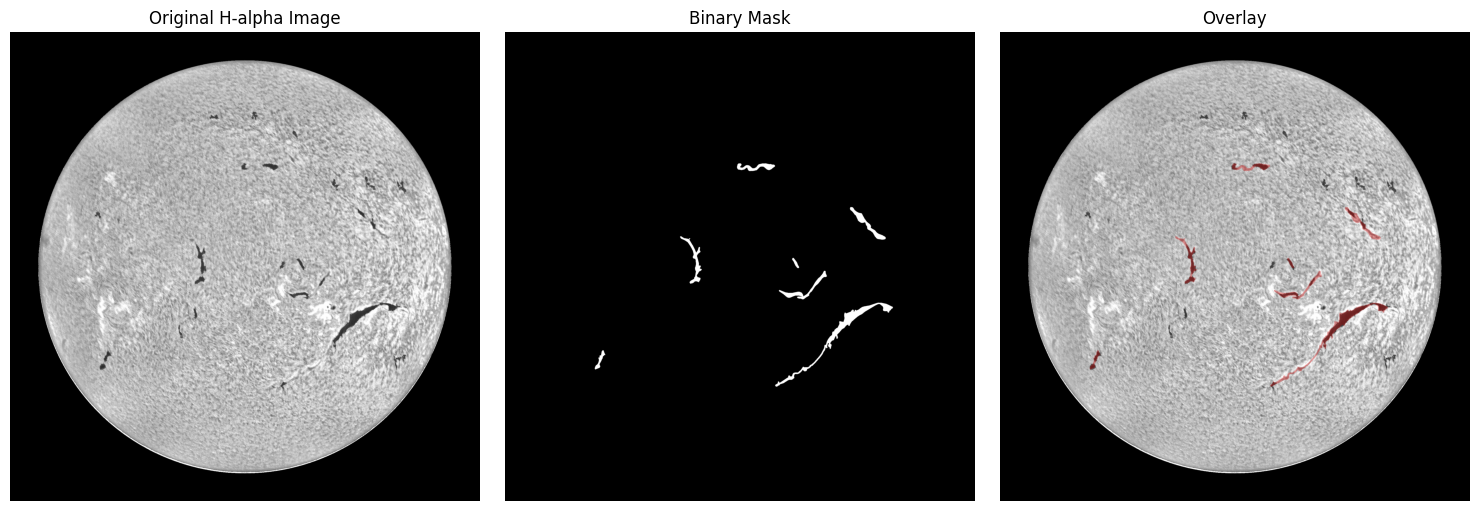

In [ ]:
visualize_mask_overlay(
    image_dir="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs",
    mask_dir="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/unet-labels",
    image_id="050102-20150116082034Lh"  # ← your actual COCO image ID
)


DATASET CLASS IN PYTORCH

In [ ]:


def index_images_by_id(image_dir, extensions=(".jpg", ".jpeg", ".png", ".tif")):
    """Recursively index images by image_id (filename without extension)."""
    image_index = {}
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(extensions):
                image_id = os.path.splitext(file)[0]
                image_index[image_id] = os.path.join(root, file)
    return image_index

class FilamentDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_index = index_images_by_id(image_dir)
        self.mask_dir = mask_dir
        self.image_ids = sorted(self.image_index.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = self.image_index[image_id]
        mask_path = os.path.join(self.mask_dir, f"{image_id}.png")

        image = Image.open(img_path).convert("L")  # grayscale
        mask = Image.open(mask_path).convert("L")  # binary mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()

        return image, mask


In [ ]:
def split_dataset_indices(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5
    random.seed(seed)

    total_size = len(dataset)
    indices = list(range(total_size))
    random.shuffle(indices)

    train_end = int(train_ratio * total_size)
    val_end = train_end + int(val_ratio * total_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    return train_indices, val_indices, test_indices


In [ ]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=4, shuffle_train=True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)  # batch_size=1 for full-res eval
    return train_loader, val_loader, test_loader


In [ ]:


# Resize for train/val
train_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Keep original resolution for test
test_transform = transforms.Compose([
    transforms.ToTensor()
])


 #Define directories
image_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs"
mask_dir = "/content/drive/MyDrive/filament-detection-project/data/YOLO-data/unet-labels"

# Step 1: Load full dataset without transforms just to get consistent index splits
full_dataset = FilamentDataset(image_dir=image_dir, mask_dir=mask_dir, transform=None)
train_idx, val_idx, test_idx = split_dataset_indices(full_dataset)

# Step 2: Apply different transforms per split
train_dataset = Subset(FilamentDataset(image_dir, mask_dir, transform=train_val_transform), train_idx)
val_dataset   = Subset(FilamentDataset(image_dir, mask_dir, transform=train_val_transform), val_idx)
test_dataset  = Subset(FilamentDataset(image_dir, mask_dir, transform=test_transform), test_idx)

# Step 3: Create loaders using your function
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=8)


In [ ]:
#inspect a batch of sample
images, masks = next(iter(train_loader))
print(images.shape)  # [B, 1, 256, 256]
print(masks.shape)   # [B, 1, 256, 256]
images = images.to(device, non_blocking=True)
masks = masks.to(device, non_blocking=True)


torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


U-NET MODEL

In [ ]:

# Create a UNet with 1 input channel and 1 output channel (e.g., for binary mask)
model = smp.Unet(
    encoder_name="resnet18",   # encoder
    encoder_weights=None,
    in_channels=1,             # grayscale input
    classes=1                  # output mask
)


TRAIN U-NET

Using device: cuda
Model is on: cuda:0
Epoch 1/50 - Train Loss: 1.4156 - Val Loss: 0.5237
Epoch 2/50 - Train Loss: 1.1995 - Val Loss: 0.9277
Epoch 3/50 - Train Loss: 1.1665 - Val Loss: 0.4554
Epoch 4/50 - Train Loss: 1.1587 - Val Loss: 0.4153
Epoch 5/50 - Train Loss: 1.0948 - Val Loss: 0.4839
Epoch 6/50 - Train Loss: 1.0484 - Val Loss: 0.4566
Epoch 7/50 - Train Loss: 1.0255 - Val Loss: 0.5024
Epoch 8/50 - Train Loss: 1.0026 - Val Loss: 0.4943
Epoch 9/50 - Train Loss: 0.9759 - Val Loss: 0.4911
Epoch 10/50 - Train Loss: 0.9729 - Val Loss: 0.4852
Epoch 11/50 - Train Loss: 0.9472 - Val Loss: 0.5084
Epoch 12/50 - Train Loss: 0.9119 - Val Loss: 0.5208
Epoch 13/50 - Train Loss: 0.8827 - Val Loss: 0.5263
Epoch 14/50 - Train Loss: 0.8837 - Val Loss: 0.9379
Epoch 15/50 - Train Loss: 0.9015 - Val Loss: 0.5219
Epoch 16/50 - Train Loss: 0.8689 - Val Loss: 0.5136
Epoch 17/50 - Train Loss: 0.8695 - Val Loss: 0.5136
Epoch 18/50 - Train Loss: 0.8508 - Val Loss: 0.5727
Epoch 19/50 - Train Loss: 0.8146 -

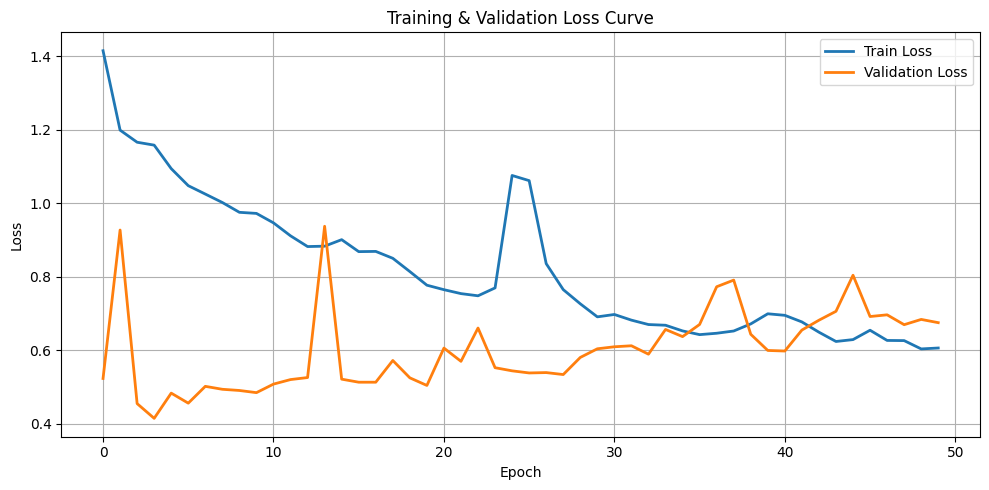

In [ ]:


# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Move model to GPU ---
model = model.to(device)  #  model must be defined before this line
print("Model is on:", next(model.parameters()).device)  # Should say cuda:0

# --- Loss and optimizer ---
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training ---
epochs = 50  # Change to 25+ when you're ready

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for img, mask in train_loader:
        img = img.to(device, non_blocking=True)        # [B, 1, H, W]
        mask = mask.to(device, non_blocking=True)      # [B, 1, H, W]

        pred = model(img)
        loss = loss_fn(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


EVALUATION

In [ ]:
def compute_metrics(pred, target, threshold=0.5):
    """
    Computes pixel-level accuracy, precision, recall, and F1-score.
    pred and target are both [B, 1, H, W] tensors.
    """
    pred = torch.sigmoid(pred)  # convert logits to probs
    pred = (pred > threshold).float()

    TP = (pred * target).sum().item()
    TN = ((1 - pred) * (1 - target)).sum().item()
    FP = (pred * (1 - target)).sum().item()
    FN = ((1 - pred) * target).sum().item()

    epsilon = 1e-7
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)

    return accuracy, precision, recall, f1


In [ ]:
model.eval()
total_acc, total_prec, total_rec, total_f1 = 0, 0, 0, 0
n_batches = 0

with torch.no_grad():
    for img, mask in test_loader:
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)  # logits
        acc, prec, rec, f1 = compute_metrics(pred, mask)

        total_acc += acc
        total_prec += prec
        total_rec += rec
        total_f1 += f1
        n_batches += 1

# Average across batches
avg_acc = total_acc / n_batches
avg_prec = total_prec / n_batches
avg_rec = total_rec / n_batches
avg_f1 = total_f1 / n_batches

print(f"\n Test Set Evaluation:")
print(f"Accuracy:  {avg_acc:.4f}")
print(f"Precision: {avg_prec:.4f}")
print(f"Recall:    {avg_rec:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")



🔍 Test Set Evaluation:
Accuracy:  0.9945
Precision: 0.7276
Recall:    0.6457
F1 Score:  0.6758


In [ ]:


# === Define Test Transform ===
transform_test = transforms.Compose([
    transforms.ToTensor()  # No resizing — keeps original image size
])

# === Load Test Dataset ===
test_dataset = FilamentDataset(
    image_dir="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/gong-processed-jpgs",
    mask_dir="/content/drive/MyDrive/filament-detection-project/data/YOLO-data/unet-labels",
    transform=transform_test
)

# === Create Test DataLoader ===
test_loader = DataLoader(
    test_dataset,
    batch_size=1,         # Use 1 for visualization
    shuffle=False,
    num_workers=2
)

# === Visualization Function ===
def visualize_prediction(model, dataloader, device, threshold=0.5):
    model.eval()

    with torch.no_grad():
        for img, mask in dataloader:
            img = img.to(device)
            mask = mask.to(device)

            pred = model(img)
            pred = torch.sigmoid(pred)
            pred = (pred > threshold).float()

            # Select first sample in batch
            img = img[0].cpu().squeeze().numpy()      # [H, W]
            mask = mask[0].cpu().squeeze().numpy()    # [H, W]
            pred = pred[0].cpu().squeeze().numpy()    # [H, W]

            # Plot views
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))

            axs[0].imshow(img, cmap='gray')
            axs[0].set_title("Original H-alpha Image")

            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title("Ground Truth Mask")

            axs[2].imshow(pred, cmap='gray')
            axs[2].set_title("Predicted Mask")

            # Overlay predicted contour on original image (no fill)
            axs[3].imshow(img, cmap='gray')
            axs[3].contour(pred, levels=[0.5], colors='red', linewidths=1.5)
            axs[3].set_title("Overlay: Prediction Contour")

            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
            break  # Show only 1 image


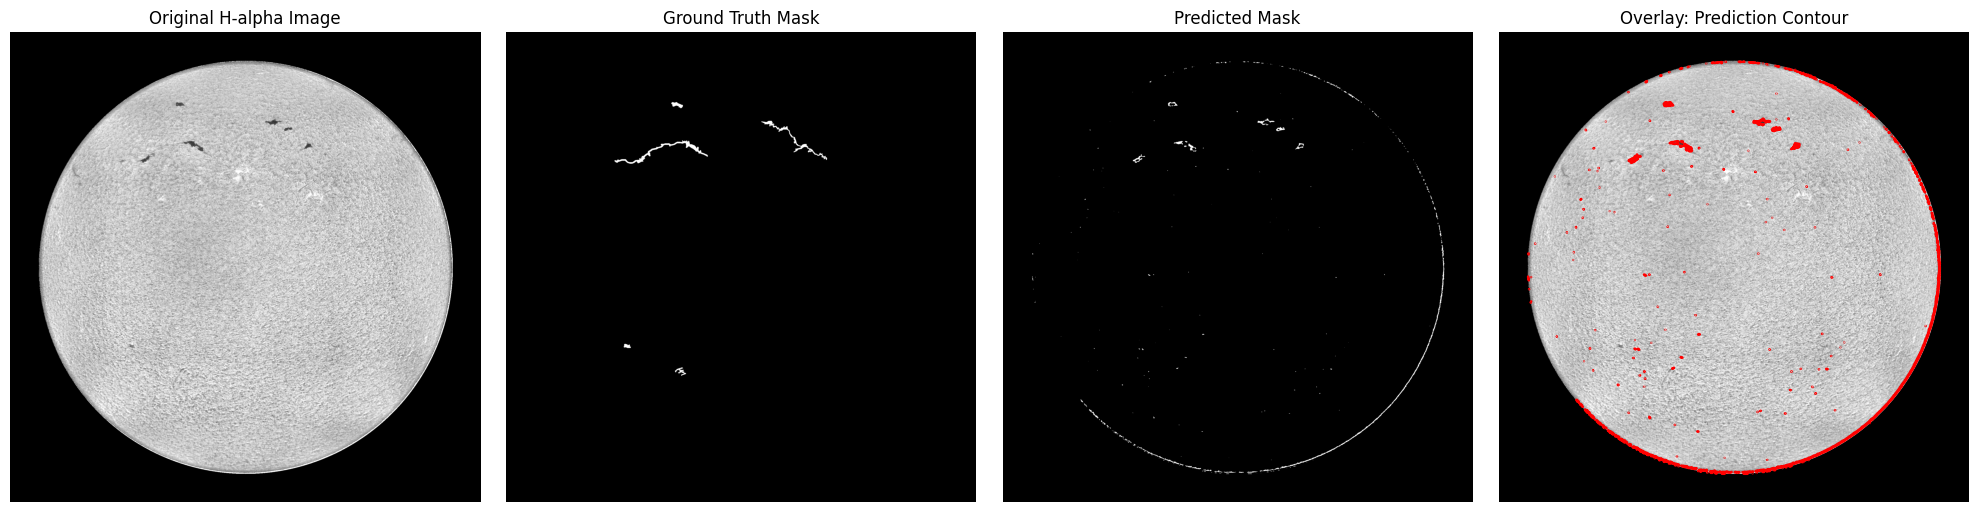

In [ ]:
visualize_prediction(
    model=model,
    dataloader=test_loader,  # or any loader you want to sample from
    device=device
)
